# Extraction des facteurs risque de l'insufissance rénale chronique 

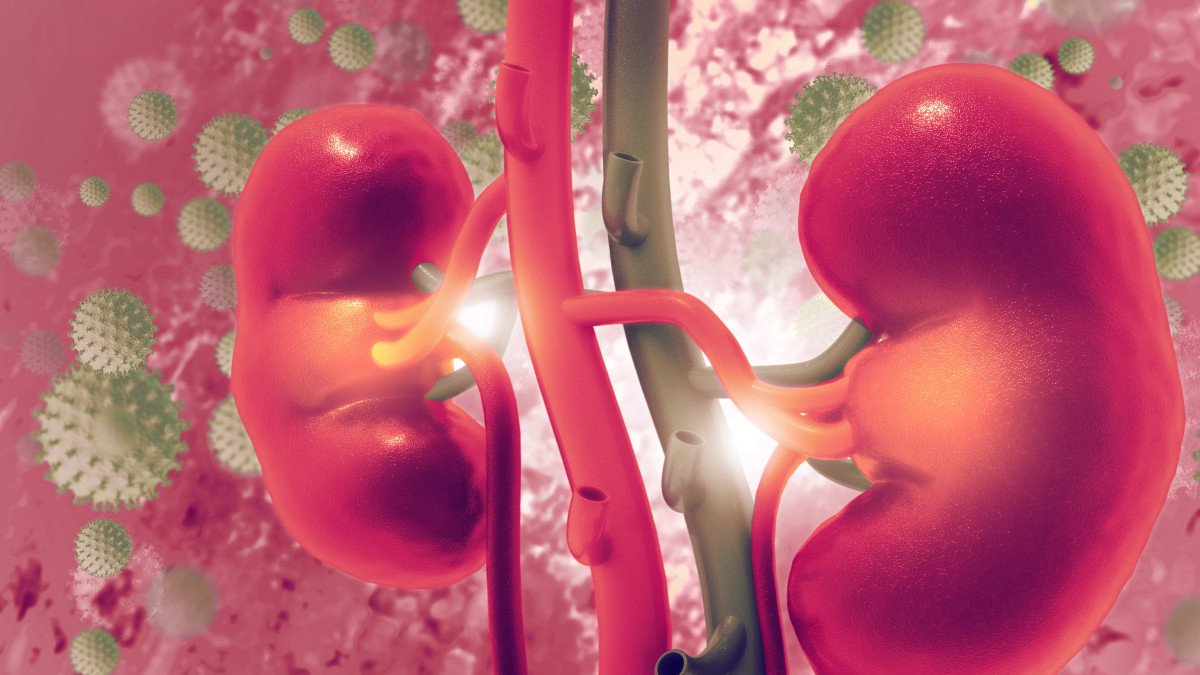

Le processus d'analyse suivit dans ce notebook est le suivant 

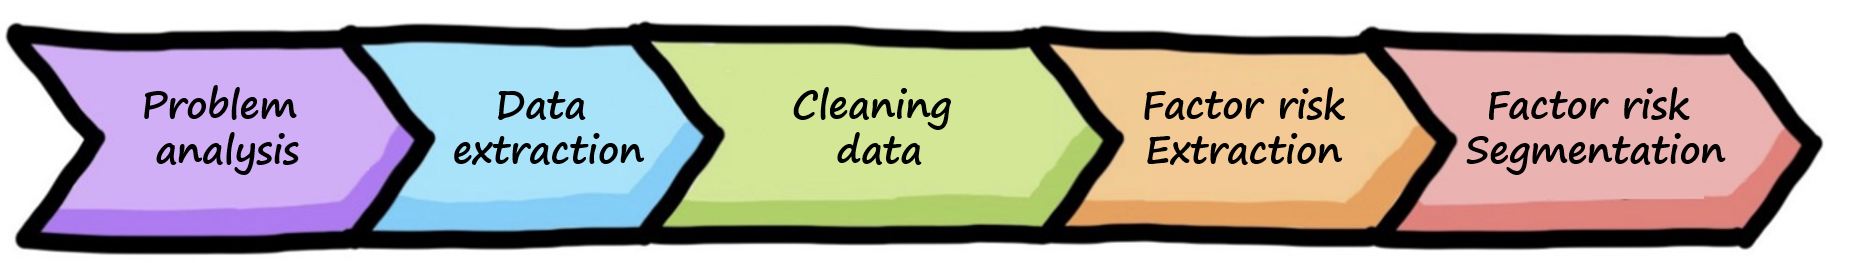

# Importation du code

Le code pour executer ce jupyter notebook étant dans un githum repository, la première des choses a faire est de synchroniser les deux environnements

Crédentials pour le githum (si le token a expiré, merci de me contacter pour en générer un autre )

In [24]:
!git config --global user.email "benraisdotlamine@gmail.com"
Token='KeyTokenFoundInTheEmail'

le jupyter notebook étant exécuté a partir de google colab, les liens y sont donc relatifs.

In [31]:
%cd /content/drive/MyDrive/Wema_CodeChallenge/
!git init
!git remote remove origin
!git remote add origin https://{Token}@github.com/benraisdotlamine/Wema_CodeChallenge.git
!git pull origin master
%cd /content/drive/MyDrive/Wema_CodeChallenge/PythonPart

/content/drive/MyDrive/Wema_CodeChallenge
Reinitialized existing Git repository in /content/drive/MyDrive/Wema_CodeChallenge/.git/
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/benraisdotlamine/Wema_CodeChallenge
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
Updating cac260b..01cd33f
Fast-forward
 PythonPart/PlottingFunctions.py | 6 +++---
 1 file changed, 3 insertions(+), 3 deletions(-)
/content/drive/MyDrive/Wema_CodeChallenge/PythonPart


Import necessary packages for the rest of this jupyter Notebook

In [4]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif,f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


In [5]:
from numpy import nan 
from pandas import to_numeric
import math
import scipy.stats 

importation des modules spécifiques

In [32]:
import imp

import PlottingFunctions
imp.reload(PlottingFunctions)

import AnalyseFunctions
imp.reload(AnalyseFunctions)

import UtilityModule
imp.reload(UtilityModule)

<module 'UtilityModule' from '/content/drive/MyDrive/Wema_CodeChallenge/PythonPart/UtilityModule.py'>

Le but de ce jupyter notebook est de traiter le CKD : "Chronic Kidney Desease" (Maladie rénale chronique) et de mettre en place des approches qui nous donneront plus d'information sur : 
- les facteurs de risque du CKD
- les différents types de CKD basée sur leurs symptomes  

détails sur la question  (source wiki)

*Il existe des facteurs de risques. Tout d’abord il y a l’augmentation forte de la **protéinurie**, dans les atteintes glomérulaires (**forte concentration de protéine dans les urines**). On recense aussi l’**hypertension artérielle**, qui réduit significativement l’espérance de vie si elle est non traitée, et du même coup est la conséquence d'une maladie rénale elle-même (80 % des hypertensions apparaissent avec l'atteinte rénale, et disparaissent quasi totalement deux à trois mois après le début de l'épuration extra-rénale, en étant une composante volémique[Quoi ?]). Enfin, il a été constaté que le **tabagisme** favorise la progression des maladies rénales, et que l’arrêt du tabac ralentissait celle de l’IRC. Au stade terminal, l'absorption de liquides peut s’avérer dangereuse, puisqu'il y a risque d'œdème aigu du poumon, surtout dans le cas où la diurèse est réduite, voire nulle de par certaines atteintes du rein, notamment les atteintes glomérulaires, suivies par les atteintes vasculaires, et à très moindre degré par les atteintes interstitielles et parenchymateuses. Les patients doivent donc limiter fortement les boissons. Sans oublier un autre versant du danger alimentaire chez l'insuffisant rénal chronique dialysé, celui des **aliments riches en potassium**, qui est dangereux pour le cœur, car il cause un trouble électrique dès la moindre élévation de ses valeurs (par exemple : bananes, fruits secs dont le cacao, donc chocolat, dattes, jus de fruits concentrés).*


L'hypothèse de départ ainsi inclus les facteurs risques suivants : 


1.   Concertration des protéines dans les urines
2.   l'hypertension artérielle
3.   le tabagisme
4.   consommation des aliments riches en potasium

Voyons ce que la base de données a a offrir.





---



# Extraction des donneés


Le téléchargement de la base de données a été effectué à partir de ce [lien](https://archive.ics.uci.edu/ml/datasets/Risk+Factor+prediction+of+Chronic+Kidney+Disease)

Le fichier chronic_kidney_disease.arff a été exploité

Remarque : avant importation, ces modifications ont été apporté au fichier:
- Suppression de l'espace dans la ligne 60
- Suppression de la virgule de plus dans la ligne 399

In [8]:
CKD_dataframe=UtilityModule.LoadDataFrame('/content/drive/MyDrive/Wema_CodeChallenge/Data/chronic_kidney_disease.arff')

Vérifier quelques valeurs ... 

In [9]:
CKD_dataframe.head()

age    bp        sg    al    su        rbc           pc            pcc  \
0  48.0  80.0  b'1.020'  b'1'  b'0'       b'?'    b'normal'  b'notpresent'   
1   7.0  50.0  b'1.020'  b'4'  b'0'       b'?'    b'normal'  b'notpresent'   
2  62.0  80.0  b'1.010'  b'2'  b'3'  b'normal'    b'normal'  b'notpresent'   
3  48.0  70.0  b'1.005'  b'4'  b'0'  b'normal'  b'abnormal'     b'present'   
4  51.0  80.0  b'1.010'  b'2'  b'0'  b'normal'    b'normal'  b'notpresent'   

              ba    bgr  ...   pcv    wbcc  rbcc     htn      dm    cad  \
0  b'notpresent'  121.0  ...  44.0  7800.0   5.2  b'yes'  b'yes'  b'no'   
1  b'notpresent'    NaN  ...  38.0  6000.0   NaN   b'no'   b'no'  b'no'   
2  b'notpresent'  423.0  ...  31.0  7500.0   NaN   b'no'  b'yes'  b'no'   
3  b'notpresent'  117.0  ...  32.0  6700.0   3.9  b'yes'   b'no'  b'no'   
4  b'notpresent'  106.0  ...  35.0  7300.0   4.6   b'no'   b'no'  b'no'   

     appet      pe     ane   class  
0  b'good'   b'no'   b'no'  b'ckd'  
1  b'good'   b'no'   b'no'  b'ckd'  
2  b'poor'   b'no'  b'yes'  b'ckd'  
3  b'poor'  b'yes'  b'yes'  b'ckd'  
4  b'good'   b'no'   b'no'  b'ckd'  

[5 rows x 25 columns]

Le fait d'avoir des valeurs en "byte type" n'est pas recommendé, il est nécessaire de les caster vers leurs types respectifs. 
Exemple, l'attribut :"sg" est une valeurs qui devrait être de type float mais elle est maintenant de type byte

In [14]:
CKD_dataframe[['sg','class']]

sg      class
0    b'1.020'     b'ckd'
1    b'1.020'     b'ckd'
2    b'1.010'     b'ckd'
3    b'1.005'     b'ckd'
4    b'1.010'     b'ckd'
..        ...        ...
395  b'1.020'  b'notckd'
396  b'1.025'  b'notckd'
397  b'1.020'  b'notckd'
398  b'1.025'  b'notckd'
399  b'1.025'  b'notckd'

[400 rows x 2 columns]

In [15]:
type(CKD_dataframe['sg'][0])

bytes

Pour convertir le tout, il suffit de lancer ce code 

In [8]:
def CastDataframe():
  CKD_dataframe['sg']=CKD_dataframe['sg'].str.decode('utf-8')
  CKD_dataframe['sg']=CKD_dataframe['sg'].replace('?',nan).astype('float64')

  CKD_dataframe['al']=CKD_dataframe['al'].str.decode('utf-8')
  CKD_dataframe['al']=to_numeric(CKD_dataframe['al'].replace('?',nan), errors='coerce')

  CKD_dataframe['su']=CKD_dataframe['su'].str.decode('utf-8')
  CKD_dataframe['su']=to_numeric(CKD_dataframe['su'].replace('?',nan), errors='coerce')

  CKD_dataframe['rbc']=CKD_dataframe['rbc'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['pc']=CKD_dataframe['pc'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['pcc']=CKD_dataframe['pcc'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['ba']=CKD_dataframe['ba'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['htn']=CKD_dataframe['htn'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['dm']=CKD_dataframe['dm'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['cad']=CKD_dataframe['cad'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['appet']=CKD_dataframe['appet'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['pe']=CKD_dataframe['pe'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['ane']=CKD_dataframe['ane'].str.decode('utf-8').replace('?',nan)

  CKD_dataframe['class']=CKD_dataframe['class'].str.decode('utf-8').replace('?',nan)

CastDataframe()

Cette fois ci les valeurs sont bel et bien dans leurs types respectifs, le préfix b' n'apparait plus 

In [17]:
CKD_dataframe.head()

age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...   pcv    wbcc  rbcc  htn   dm  cad  appet   pe  ane class  
0  121.0  ...  44.0  7800.0   5.2  yes  yes   no   good   no   no   ckd  
1    NaN  ...  38.0  6000.0   NaN   no   no   no   good   no   no   ckd  
2  423.0  ...  31.0  7500.0   NaN   no  yes   no   poor   no  yes   ckd  
3  117.0  ...  32.0  6700.0   3.9  yes   no   no   poor  yes  yes   ckd  
4  106.0  ...  35.0  7300.0   4.6   no   no   no   good   no   no   ckd  

[5 rows x 25 columns]

Afin de se familiariser avec les types de valeurs dont nous disposons et leurs types, voici le code suivant :

In [52]:
for col in list(CKD_dataframe.columns):
  print(col,'\t',type(list(CKD_dataframe[col].dropna().sample(1))[0]))

age 	 <class 'float'>
bp 	 <class 'float'>
sg 	 <class 'float'>
al 	 <class 'float'>
su 	 <class 'float'>
rbc 	 <class 'str'>
pc 	 <class 'str'>
pcc 	 <class 'str'>
ba 	 <class 'str'>
bgr 	 <class 'float'>
bu 	 <class 'float'>
sc 	 <class 'float'>
sod 	 <class 'float'>
pot 	 <class 'float'>
hemo 	 <class 'float'>
pcv 	 <class 'float'>
wbcc 	 <class 'float'>
rbcc 	 <class 'float'>
htn 	 <class 'str'>
dm 	 <class 'str'>
cad 	 <class 'str'>
appet 	 <class 'str'>
pe 	 <class 'str'>
ane 	 <class 'str'>
class 	 <class 'str'>


# Traitement des données manquantes

Combien de lignes y a il dans le Dataframe ? 

In [53]:
All_Rows=CKD_dataframe['class'].count()

Parmis ces valeurs, combiens sont manquantes ? 
Utiliser la fonction isna() pour extraire les valeurs manquante par attribut comme ceci : 


In [54]:
CKD_dataframe.isna().sum().sort_values(ascending=False)

rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

Pour une meilleure visualisation des pertes, un pourcentage de valeur manquante par attribut est calculé 

In [55]:
CKD_dataframe.isna().sum().sort_values(ascending=False)/CKD_dataframe['class'].count()*100

rbc      38.00
rbcc     32.75
wbcc     26.50
pot      22.00
sod      21.75
pcv      17.75
pc       16.25
hemo     13.00
su       12.25
sg       11.75
al       11.50
bgr      11.00
bu        4.75
sc        4.25
bp        3.00
age       2.25
ba        1.00
pcc       1.00
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

Pour lister les valeurs non manquante dans une colonne spécifique, il suffit d'utiliser la fonction dropna()

In [56]:
CKD_dataframe['rbc'].dropna()

2      normal
3      normal
4      normal
7      normal
8      normal
        ...  
395    normal
396    normal
397    normal
398    normal
399    normal
Name: rbc, Length: 248, dtype: object

Afin de remplir les valeurs manquantes, nous allons mettre en place un system aléatoire basée sur la classe. En d'autre termes, une valeur null sera remplacé par une valeur aléatoire sachant qu'ils appartienne a la même classe 

Ceci nous apporte un degré de challenge supplémentaire du fait que des variables dispose de pourcentage important de valeurs manquantes, exemple :
rbc      38.00%
rbcc     32.75%
wbcc     26.50%
pot      22.00%
sod      21.75%
pcv      17.75%
pc       16.25%

Cette partie de remplissage des variables est extrêmement délicate et ne doit en aucun cas être traité aussi aisément dans des environnements de productions. 

Afin d'avancer dans le process, nous allons, dans notre cas, les remplacer par des valeurs existante, comme expliqué.


Nous remarquons que la ligne 1 de l'attribut rbc est une valeur manquante

In [57]:
CKD_dataframe.at[1,'rbc']

nan

et que dans cette ligne, la classification est : ckd

In [58]:
CKD_dataframe.at[1,'class']

'ckd'

de ce fait, nous allons prendre une valeur aléatoire a partir du sous groupe de données dont la classe est ckd comme suit : 

In [59]:
TmpDF=CKD_dataframe[CKD_dataframe['class']=='ckd'].dropna().sample(1)['rbc']
CKD_dataframe.at[1,'rbc']=TmpDF.to_numpy()[0]
CKD_dataframe.at[1,'rbc']

'normal'

Nous allons maintenant généraliser pour toutes les données de la dataframe comme suit : 

In [11]:
ColName = CKD_dataframe.columns.values.tolist()

In [12]:
def FillMissingValues(printing=False):
  for col in ColName:
    if printing:
      print(col)
    AnalyseFunctions.FillAllMissingValues(CKD_dataframe,col,['ckd','notckd'])
FillMissingValues(True)

age
bp
sg
al
su
rbc
pc
pcc
ba
bgr
bu
sc
sod
pot
hemo
pcv
wbcc
rbcc
htn
dm
cad
appet
pe
ane
class


Vérifier quelques résultats

In [66]:
CKD_dataframe.sample(10)

age    bp     sg   al   su       rbc        pc         pcc          ba  \
193  32.0  90.0  1.025  1.0  0.0  abnormal  abnormal  notpresent  notpresent   
336  25.0  60.0  1.020  0.0  0.0    normal    normal  notpresent  notpresent   
367  68.0  60.0  1.025  0.0  0.0    normal    normal  notpresent  notpresent   
349  35.0  70.0  1.025  0.0  0.0    normal    normal  notpresent  notpresent   
187   3.0  60.0  1.010  2.0  0.0    normal    normal  notpresent  notpresent   
140  69.0  70.0  1.010  0.0  4.0  abnormal    normal  notpresent  notpresent   
130  50.0  90.0  1.010  2.0  0.0    normal  abnormal     present     present   
174  54.0  70.0  1.010  4.0  0.0    normal    normal  notpresent  notpresent   
114  12.0  60.0  1.015  3.0  0.0  abnormal  abnormal     present  notpresent   
264  42.0  80.0  1.020  0.0  0.0    normal    normal  notpresent  notpresent   

       bgr  ...   pcv     wbcc  rbcc  htn   dm  cad  appet   pe  ane   class  
193  123.0  ...  15.0   2600.0   2.8  yes  yes   no   poor  yes  yes     ckd  
336  119.0  ...  40.0   9200.0   5.2   no   no   no   good   no   no  notckd  
367  125.0  ...  50.0   6700.0   6.1   no   no   no   good   no   no  notckd  
349   82.0  ...  52.0   9400.0   6.1   no   no   no   good   no   no  notckd  
187   94.0  ...  34.0  12300.0   4.9   no   no   no   good   no   no     ckd  
140  256.0  ...  20.0  11000.0   2.9   no   no   no   good   no   no     ckd  
130  128.0  ...  22.0  16300.0   2.7   no   no   no   poor  yes  yes     ckd  
174  111.0  ...  35.0   8600.0   4.6   no   no   no   good   no   no     ckd  
114   86.0  ...  33.0  10300.0   3.7   no   no   no   good   no   no     ckd  
264  132.0  ...  50.0   5000.0   4.5   no   no   no   good   no   no  notckd  

[10 rows x 25 columns]

Vérifier l'ensemble des valeurs :

In [67]:
CKD_dataframe.isna().sum().sort_values(ascending=False)/CKD_dataframe['class'].count()*100

age      0.0
pot      0.0
ane      0.0
pe       0.0
appet    0.0
cad      0.0
dm       0.0
htn      0.0
rbcc     0.0
wbcc     0.0
pcv      0.0
hemo     0.0
sod      0.0
bp       0.0
sc       0.0
bu       0.0
bgr      0.0
ba       0.0
pcc      0.0
pc       0.0
rbc      0.0
su       0.0
al       0.0
sg       0.0
class    0.0
dtype: float64

Vu que nous avons maintenant traité toues les valeurs manquantes, nous passons a la seconde étape qui consiste en une visualisation des données.

# Visualisation des données

Afin de connaitre mieux la distribution de la base de données, nous allons dans cette section visualiser la distribution des attributs, leurs types, ainsi que leurs corrélations

Visualisation de la distribution

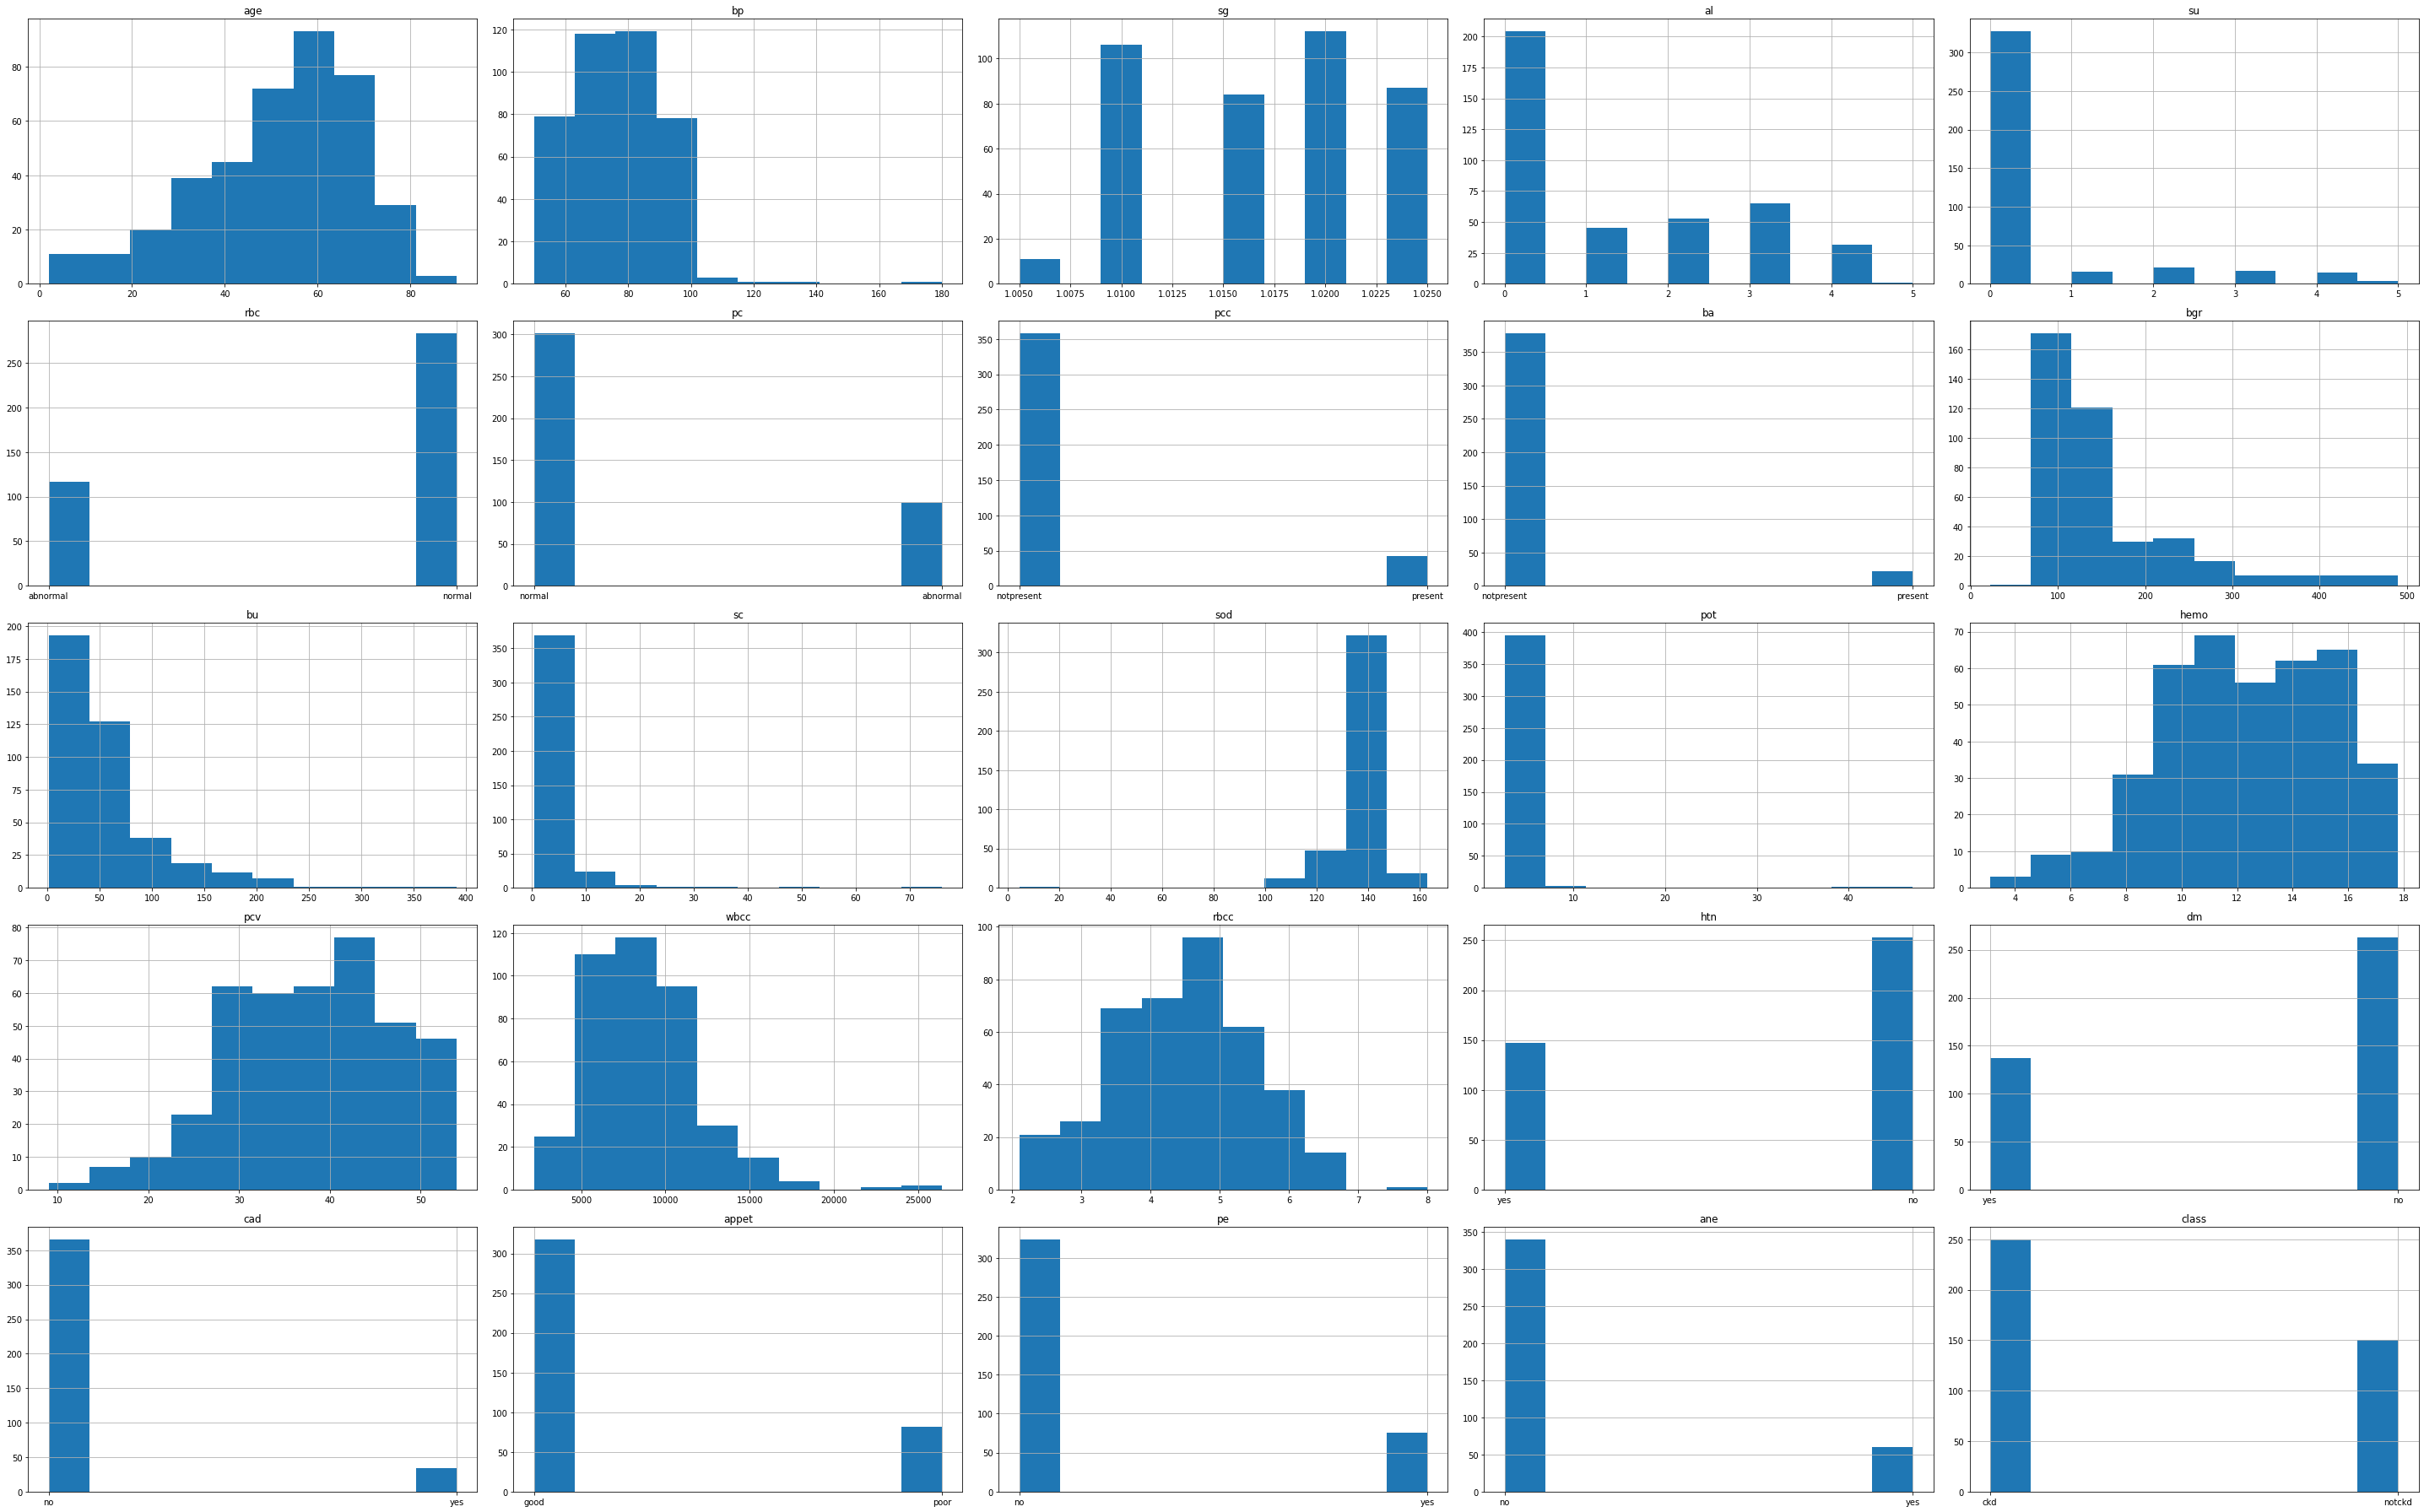

In [68]:
PlottingFunctions.PlottingAllColumns(CKD_dataframe,ColName)

Pour visualiser un seul attribut avec un autre type de graphique : 

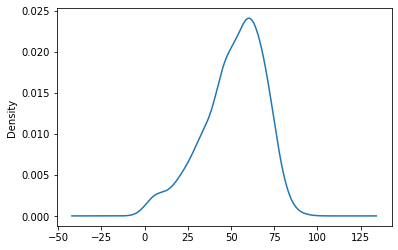

In [69]:
PlottingFunctions.plotColumn(CKD_dataframe,'age','kde')

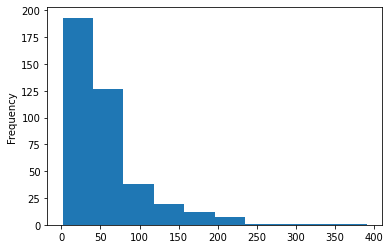

In [70]:
PlottingFunctions.plotColumn(CKD_dataframe,'bu')

La visualisation des données étant terminer, nous passons maintenant a leurs analyse

Pour une meilleure visualisation, nous pouvons diviser les colonnes en deux catégories : Colonnes numériques et colonnes Ordinales comme suit : 

In [114]:
NumericalCol=UtilityModule.getAllNumericCol(CKD_dataframe)

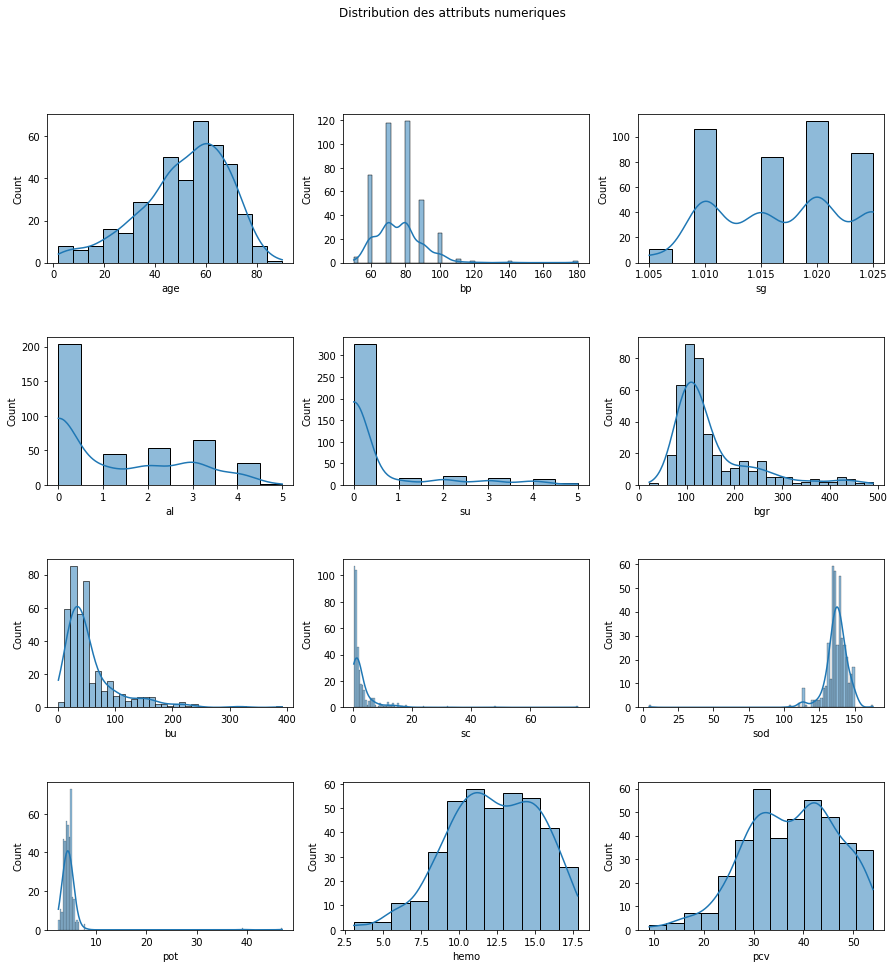

In [115]:
PlottingFunctions.NumericalValueDistribution(CKD_dataframe,NumericalCol)

In [116]:
NominalCol=[col for col in CKD_dataframe.columns if col not in NumericalCol]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

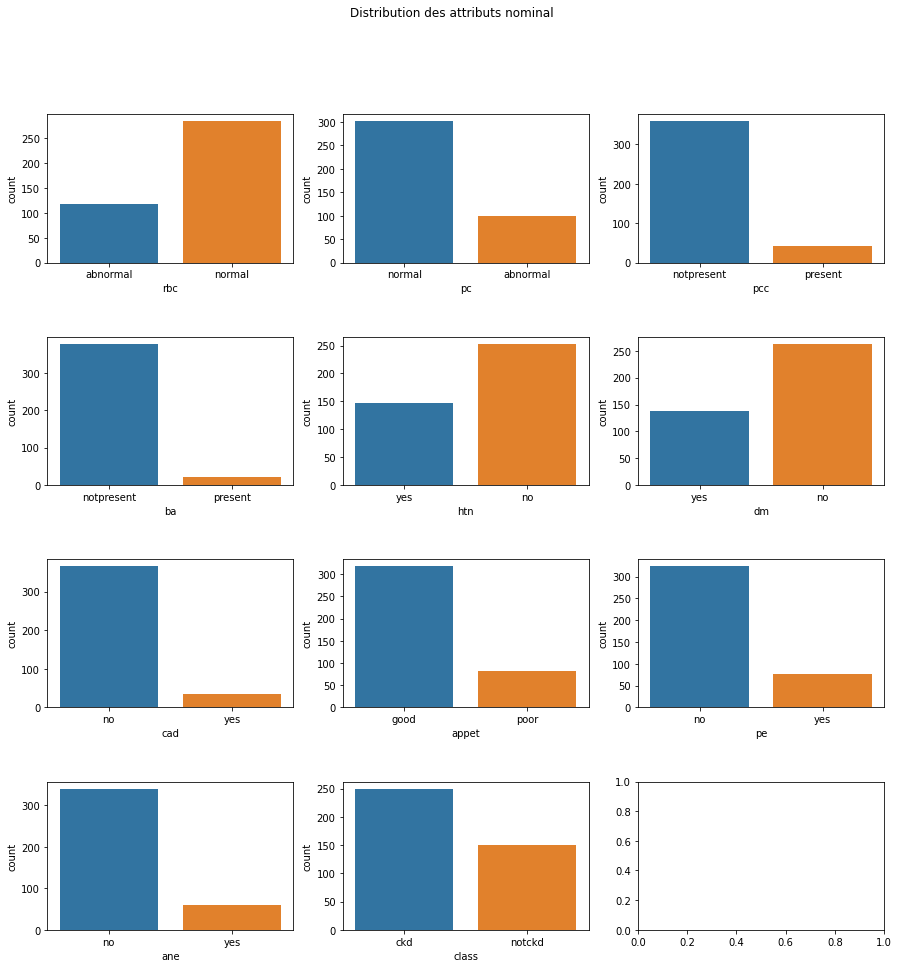

In [124]:
PlottingFunctions.NominalValueDistribution(CKD_dataframe,NominalCol)

Les distributions nous paraissent pas uniforme, nous devons considérer lors de prochains analyses des procédures de normalisation.

# Analyse des données

Dans cette section, nous allons mettre en place différentes approaches pour analyser les donner, commençant par des exemples simpliste vers des approches plus rigides

## Extraction des facteurs risques approche 1 

Dans cette première approche, nous allons extraires les facteurs risques de la ckd en analysant la différence moyenne pour les valeurs numériques et un delta de count pour les valeurs non numérique de chaque attribut suivant une ségrégation des classes. Pour cela, nous allons utiliser principalement la fonction `RelationshipInNumbers` présente dans le module `AnalyseFunctions`

Regardons la relation entre l'age et le fait d'être CKD ou pas en lançant le code suivant

In [165]:
AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class','age')

count       mean   min   max         var
class                                           
ckd       250  54.644000   2.0  90.0  301.555486
notckd    150  46.533333  12.0  80.0  242.733781

Cette fonction nous retourne pleins d'information sur la relation entre les deux variables. Des valeurs comme le *count*, *la moyenne*, *le minimum*, *le maximum* et la *variance* sont présenté.

Nous remarquon dans ce petit exemple que la moyenne d'age entre les patients CKD et les personnes Non_CKD est quasi similaire. 
En d'autre termes, pour une distribution allant de *2* à *90*. La moyenne d'age des patients CKD est de *54* ans et pour les personnes non atteinte par le CKD est de *46* ans. 


Une différence peu significative. D'autant plus que les valeurs maximum et minimums sont quasi similaire avec une distribution de données homogène représenté par la variance

Dans ce second exemple, nous effectuons la mêmle opération pour une autre variable ▶ 'su' (Sucre) en relation avec la classe finale (CKD, notCKD)

In [81]:
AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class','su')

count   mean  min  max       var
class                                   
ckd       250  0.756  0.0  5.0  1.807695
notckd    150  0.000  0.0  0.0  0.000000

Nous remarquons qu'il n'ya **aucun** patient non CKD qui a un problème de diabète (sucre). Or, pour une distribution entre 0 et 5, la moyenne des patient CKD dispose d'un taux en sucre de 0.7 avec une variance de 1.8.
Nous pouvons conclure qu'il existe une corrélation entre ces deux variabes

Une troisème varible que nous testons est l'albumine (al) avec une approche similaire ⏩

In [83]:
AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class','sod')

count     mean    min    max         var
class                                           
ckd       250  133.942    4.5  163.0  119.487586
notckd    150  141.640  135.0  150.0   23.144698

Nous remarquons que la relation entre les patiens CKD et les personnes non atteinte par le CKD vis a vis du taux de sodium est négligeable. Le taux de saudium n'affecte pas l'apparition du CKD. 

Nous confirmons cette analyse par les valeurs de la moyennes de cette valeurs pour les deux groupes de personnes (CKD, NotCKD) qui est respectivement : *133.9* et *141.6*. 

La variance du taux de sodium étant plus importante pour les patient CKD, toutefois, je pense que cette valeur est peu significative du fait qu'il y a tout simplement plus de valeurs pour cette classe ▶ plus de cas ▶ plus de distribution 



---



En ce qui concerne les valeurs non numérique, cette même fonction s'adapte et nous retourne cette fois ci le nombre des patients CKD et non CKD par rapport a chaque valeur nominale de la variable comme le démontre l'exemple suivant avec la variable **pc** (pus cell*)

*:a collection of dead, white blood cells that accumulates when the body's immune system activates in response to an infection.

In [84]:
AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class','pc')

0
(ckd, normal)       151
(ckd, abnormal)      99
(notckd, normal)    150
(notckd, abnormal)    0

Exemple de colonne numérique

In [168]:
Observation_Col= [col for col in CKD_dataframe.columns if col!='class']

In [169]:
AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class','sc')

count      mean  min   max        var
class                                        
ckd       250  4.436600  0.5  76.0  46.793565
notckd    150  0.869333  0.4   1.2   0.064422

Exemple de colonne non numérique

In [170]:
AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class','ba')

0
(ckd, notpresent)     228
(ckd, present)         22
(notckd, notpresent)  150
(notckd, present)       0

Commençons par les colonnes numériques. Nous allons dans un premier temps normaliser les valeurs. Plusieurs manières de faire les choses s'offrent a nous: 
-Normalisation moyenne
-Normalisation minmax
-Normalisation avec Sklearn

In [125]:
for col in NumericalCol:
  AnalyseFunctions.normalize_function_mean(CKD_dataframe,col)

In [126]:
TrackingDict1={}
for col in NumericalCol:
  Res=AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class',col)
  TrackingDict1[col]=abs(Res['mean'][0]-Res['mean'][1])

Après cela, nous ponvons afficher le dictionnaire de manière inversé pour voir les valeurs qui affecte le plus le CKD

In [128]:
TrackingDict1=dict(sorted(TrackingDict1.items(), key=lambda item: item[1],reverse=True))

Avec ce type de normalisation, l'ordre ci-dessus a été retourné en ce qui concerne les facteurs risk pour les patient atteinte de CKD

In [129]:
TrackingDict1

{'hemo': 1.5699871341173561,
 'pcv': 1.4994048204694532,
 'sg': 1.4909693847998775,
 'rbcc': 1.4077497488535224,
 'al': 1.3485803085511892,
 'bgr': 0.8335571800640572,
 'bu': 0.781919760846288,
 'sod': 0.7810736214404068,
 'su': 0.6728578843027673,
 'sc': 0.629994900909114,
 'bp': 0.5823569695203479,
 'wbcc': 0.48325754869280885,
 'age': 0.45025196507438614,
 'pot': 0.1338759002032525}

Avec cette première approche, nous remarquons que les attributs les plus influants pour les patients CKD sont : 
- hemo (concentration de l'hémoglobine)
- pcv (packed cell volume)
- sg (specific gravity)
- rbcc (red blood cell count)
- al (albumin)

Après cette première analyse, nous allons essayer maintenant de changer la fonction de normalisation et voir les résultats qui seront retournés. La normalisation utilisée cette fois ci est : la normalisation par min_max

In [130]:
CKD_dataframe=UtilityModule.LoadDataFrame('/content/drive/MyDrive/WemanityCodeChallenge/Data/chronic_kidney_disease.arff')
CastDataframe()
FillMissingValues()
for col in NumericalCol:
  AnalyseFunctions.normalize_function_minmax(CKD_dataframe,col)

In [131]:
TrackingDict2={}
for col in NumericalCol:
  Res=AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class',col)
  TrackingDict2[col]=abs(Res['mean'][0]-Res['mean'][1])

In [132]:
TrackingDict2=dict(sorted(TrackingDict2.items(), key=lambda item: item[1],reverse=True))

In [133]:
TrackingDict2

{'sg': 0.4296666666666664,
 'al': 0.3856,
 'hemo': 0.3164535147392291,
 'pcv': 0.30856296296296304,
 'rbcc': 0.23548022598870055,
 'su': 0.1592,
 'bgr': 0.1550854700854701,
 'bu': 0.10398151476251605,
 'age': 0.09383333333333332,
 'bp': 0.064,
 'wbcc': 0.06248484848484845,
 'sod': 0.0516971608832808,
 'sc': 0.04773280423280423,
 'pot': 0.00876104868913858}

Avec cette seconde normalisation basées sur le minmax, nous remarquons que les attributs les plus influants pour les patients CKD sont :
- sg (specific gravity)
- al (albumin)
- hemo (concentration de l'hémoglobine)
- pcv (packed cell volume)
- rbcc (red blood cell count)

Les memes attributs avec un ordonancement différent.

La troisième normalisation que nous allons voir est la normalisation sklearn.

In [134]:
CKD_dataframe=UtilityModule.LoadDataFrame('/content/drive/MyDrive/WemanityCodeChallenge/Data/chronic_kidney_disease.arff')
CastDataframe()
FillMissingValues()

In [135]:
AnalyseFunctions.Normalize_sklearn(CKD_dataframe,CKD_dataframe.columns)

In [136]:
TrackingDict3={}
for col in NumericalCol:
  Res=AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class',col)
  TrackingDict3[col]=abs(Res['mean'][0]-Res['mean'][1])

In [137]:
TrackingDict3=dict(sorted(TrackingDict3.items(), key=lambda item: item[1],reverse=True))

In [138]:
TrackingDict3

{'hemo': 43.809333333333335,
 'bgr': 32.832,
 'bu': 27.81066666666667,
 'sc': 21.470666666666666,
 'rbcc': 14.271999999999998,
 'pcv': 13.338666666666665,
 'wbcc': 8.851999999999997,
 'age': 8.183999999999997,
 'sod': 7.254666666666665,
 'al': 1.88,
 'sg': 1.7293333333333332,
 'bp': 0.8426666666666667,
 'su': 0.764,
 'pot': 0.5026666666666699}

Avec cette troisième normalisation basées sur le sklearn, nous remarquons que les attributs les plus influants pour les patients CKD sont :
- hemo (Hémoglobine)
- bgr (blood glucose random)
- bu (blood urea)
- rbcc (red blood cell count)
- pcv (packed cell volume)

Nous remarquons d'autres variables qui rentre en jeux a cette étape d'analyse. Il est nécessaire de se remettre a d'autres outils de corrélation plus approfondi. 




Concaténation des trois résultats :

In [139]:
Dict={'Norm1':list(TrackingDict1.keys()),
      'Norm2':list(TrackingDict2.keys()),
      'Norm3':list(TrackingDict3.keys())}

df = pd.DataFrame(Dict)

df

Norm1 Norm2 Norm3
0   hemo    sg  hemo
1    pcv    al   bgr
2     sg  hemo    bu
3   rbcc   pcv    sc
4     al  rbcc  rbcc
5    bgr    su   pcv
6     bu   bgr  wbcc
7    sod    bu   age
8     su   age   sod
9     sc    bp    al
10    bp  wbcc    sg
11  wbcc   sod    bp
12   age    sc    su
13   pot   pot   pot



---

Nous passons maintenant aux valeurs nominales

En ce qui concerne les valeurs non numérique, nous effectuons la différence des counts

Récupérons l'ensemble des valeurs non numériques

In [140]:
NotNumericalCol=[Col for Col in CKD_dataframe if Col not in NumericalCol and Col!="class" ]

In [141]:
NotNumericalCol

['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [142]:
CKD_dataframe=UtilityModule.LoadDataFrame('/content/drive/MyDrive/WemanityCodeChallenge/Data/chronic_kidney_disease.arff')
CastDataframe()
FillMissingValues()

In [143]:
CKD_dataframe.head()

age    bp     sg   al   su       rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0    normal    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0  abnormal    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0    normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0    normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0    normal    normal  notpresent  notpresent   

     bgr  ...   pcv    wbcc  rbcc  htn   dm  cad  appet   pe  ane class  
0  121.0  ...  44.0  7800.0   5.2  yes  yes   no   good   no   no   ckd  
1   93.0  ...  38.0  6000.0   2.6   no   no   no   good   no   no   ckd  
2  423.0  ...  31.0  7500.0   3.9   no  yes   no   poor   no  yes   ckd  
3  117.0  ...  32.0  6700.0   3.9  yes   no   no   poor  yes  yes   ckd  
4  106.0  ...  35.0  7300.0   4.6   no   no   no   good   no   no   ckd  

[5 rows x 25 columns]

In [144]:
R=AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class','rbc')

In [145]:
TrackingDict={}
for col in NotNumericalCol:
  Res=AnalyseFunctions.RelationshipInNumbers(CKD_dataframe,'class',col)
  TrackingDict[col]=abs(Res[0][0]-Res[0][1]+Res[0][2]-Res[0][3])

In [146]:
dict(sorted(TrackingDict.items(), key=lambda item: item[1],reverse=True))

{'ba': 356,
 'cad': 332,
 'pcc': 316,
 'ane': 280,
 'pe': 248,
 'appet': 236,
 'pc': 200,
 'rbc': 166,
 'dm': 126,
 'htn': 106}

Nous expliquons ces résultats comme suit : tant que la différences entre les counts positifs et les counts négatifs est grande, tant que la corrélation est importante (sous réserve que les valeurs soient normalisées)

Les valeurs nominales qui intéragissent le plus avec le fait que la personne soit CKD sont : 
-  ba (bacteria)
-  cad (coronary artery disease)
-  pcc (pus cell clumps)
-  ane (Anemia)

Après cette première analyse pour le moins classique, nous passons vers la seconde approche qui utilise des outils plus spécialisé dans l'extraction des corrélations



---
Remarque ❗
Les données peuvent changer du fait que nous utilisons un remplacement aléatoire des données manquantes.

## Extraction des facteurs de risques Approache 2 (correlation des data)

Afin de ne manipuler les données comme bloque unique et ne plus les séparer entre valeurs numériques et non numérique, nous allons élaborer une codification des valeurs non numérique de manière a ce que 
(normal, present,yes,good) reçoivent la valeur 1

(abnormal, notpresent,no,poor) reçoivent la valeur 1

 valeurs numérique comme suit : 

Réinitialisation du dataframe

In [13]:
CKD_dataframe=UtilityModule.LoadDataFrame('/content/drive/MyDrive/WemanityCodeChallenge/Data/chronic_kidney_disease.arff')
CastDataframe()
FillMissingValues()

In [14]:
CKD_dataframe['rbc'] = CKD_dataframe.rbc.replace(['normal','abnormal'], ['1', '0'])
CKD_dataframe['pc'] = CKD_dataframe.pc.replace(['normal','abnormal'], ['1', '0'])
CKD_dataframe['pcc'] = CKD_dataframe.pcc.replace(['present','notpresent'], ['1', '0'])
CKD_dataframe['ba'] = CKD_dataframe.ba.replace(['present','notpresent'], ['1', '0'])
CKD_dataframe['htn'] = CKD_dataframe.htn.replace(['yes','no'], ['1', '0'])
CKD_dataframe['dm'] = CKD_dataframe.dm.replace(['yes','no'], ['1', '0'])
CKD_dataframe['cad'] = CKD_dataframe.cad.replace(['yes','no'], ['1', '0'])
CKD_dataframe['appet'] = CKD_dataframe.appet.replace(['good','poor'], ['1', '0'])
CKD_dataframe['pe'] = CKD_dataframe.pe.replace(['yes','no'], ['1', '0'])
CKD_dataframe['ane'] = CKD_dataframe.ane.replace(['yes','no'], ['1', '0'])


In [15]:
CKD_dataframe.head()

age    bp     sg   al   su rbc pc pcc ba    bgr  ...   pcv    wbcc  rbcc  \
0  48.0  80.0  1.020  1.0  0.0   0  1   0  0  121.0  ...  44.0  7800.0   5.2   
1   7.0  50.0  1.020  4.0  0.0   0  1   0  0  273.0  ...  38.0  6000.0   4.1   
2  62.0  80.0  1.010  2.0  3.0   1  1   0  0  423.0  ...  31.0  7500.0   3.9   
3  48.0  70.0  1.005  4.0  0.0   1  0   1  0  117.0  ...  32.0  6700.0   3.9   
4  51.0  80.0  1.010  2.0  0.0   1  1   0  0  106.0  ...  35.0  7300.0   4.6   

   htn  dm  cad  appet  pe ane class  
0    1   1    0      1   0   0   ckd  
1    0   0    0      1   0   0   ckd  
2    0   1    0      0   0   1   ckd  
3    1   0    0      0   1   1   ckd  
4    0   0    0      1   0   0   ckd  

[5 rows x 25 columns]

Nous allons maintenant illustrer les différente corrélation existantes entre les variable et les patient victime de CKD et ceux non victime de CKD
Ces premiers graphiques nous donne und distribution des différentes variables suivant la santé des patients (Orange=Patient CKD, Bleu = Patient Non CKD)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0.98, 'Data Distribution')

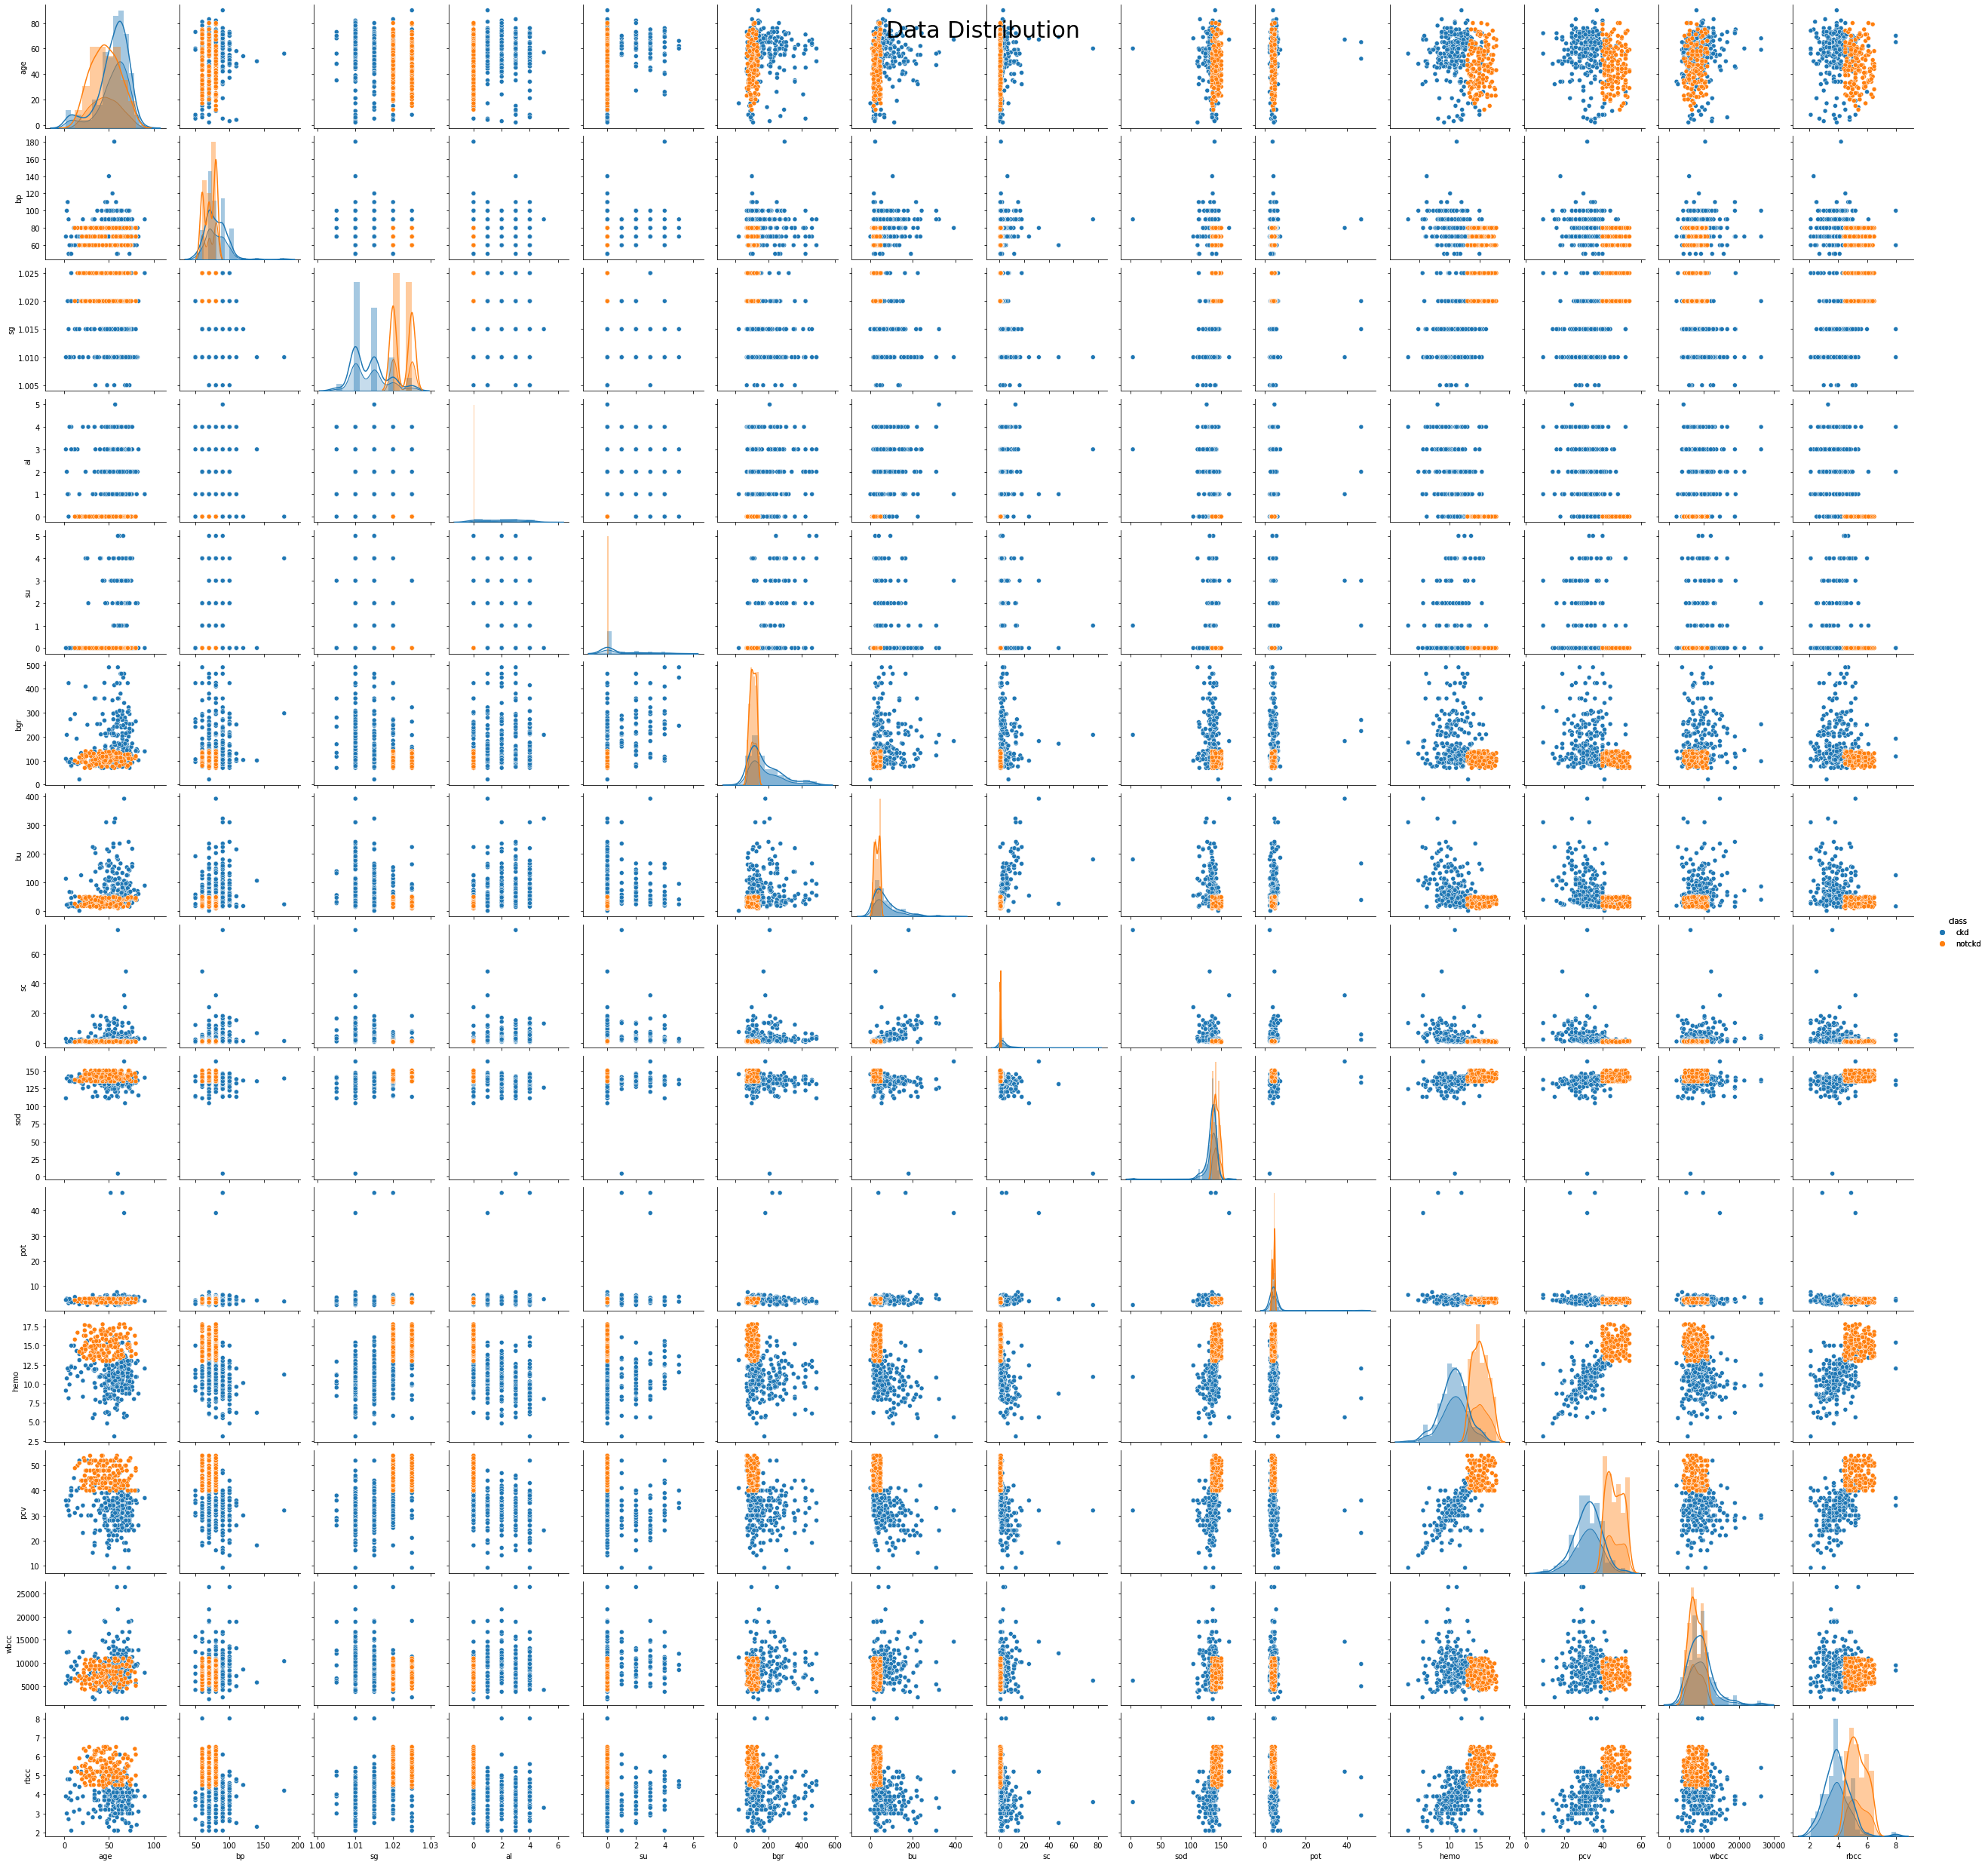

In [16]:
graph = sns.pairplot(CKD_dataframe,hue = 'class')

graph.map_diag(sns.distplot)
graph.add_legend()
graph.fig.suptitle('Data Distribution', fontsize = 30)


Après avoir eu cette première vision globale, nous allons maintenant effectuer des analyses plus détaillé. premièrement avec cette matrice de corrélation entre les variables 

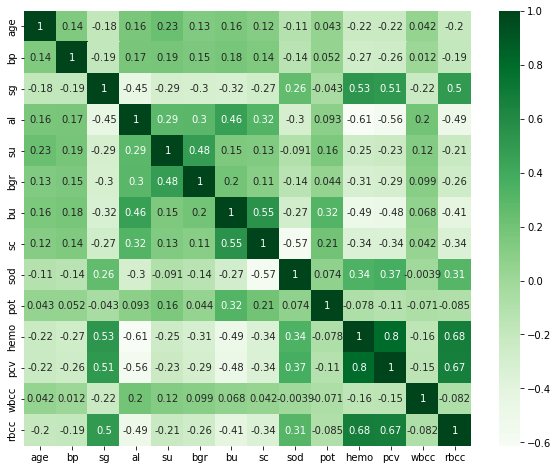

In [193]:
CKD_dataframe['class'] = CKD_dataframe.ane.replace(['1',',0'], ['ckd', 'notckd'])
PlottingFunctions.plotHeatmap(CKD_dataframe)

Ces graphique nous montre qu'une corrélation entre les attributs listées, nous allons investiguer chaque attribut de manière plus profonde.

### Relation entre l'age et le fait d'avoir ou pas une insuffisance rénale (-)

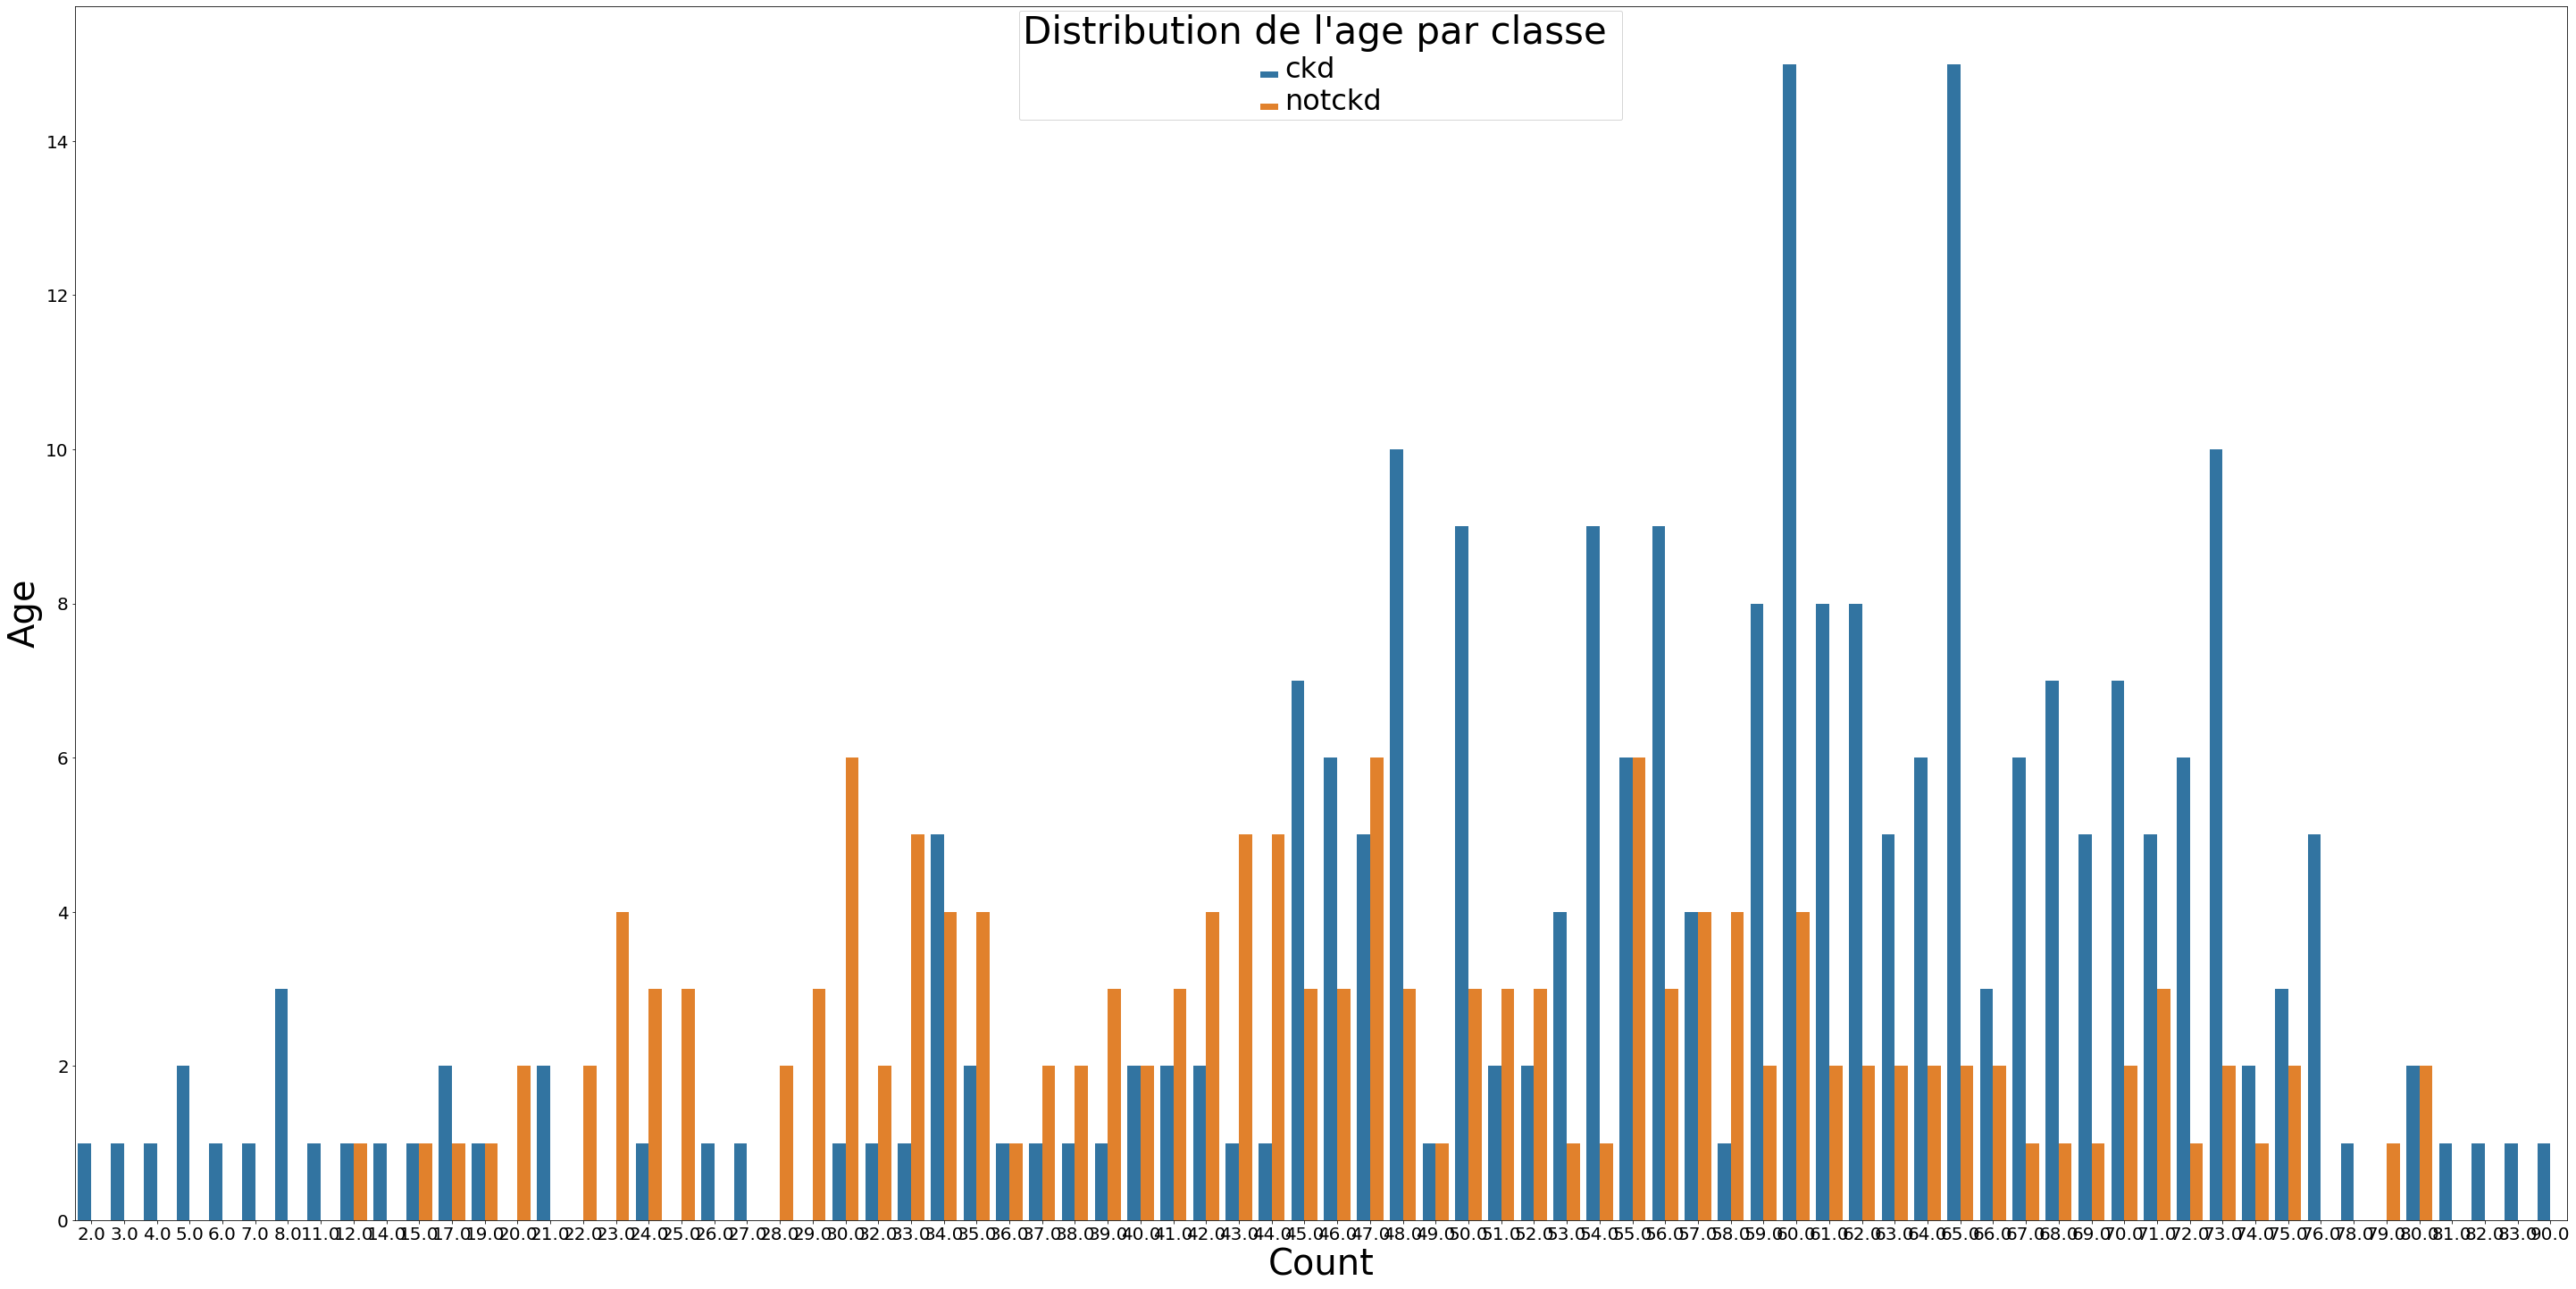

In [17]:
PlottingFunctions.PlotDistribution(CKD_dataframe,'age',"Distribution de l'age par classe ","Age")

calcul de la correlation 

In [18]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class','age')

age     count
age    1.000000  0.401761
count  0.401761  1.000000

calcul de la correlation avec les patient en bonne santé

In [19]:
age_corr = ['age', 'class']
age_corr1 = CKD_dataframe[age_corr]
age_corr_y = age_corr1[age_corr1['class'] == 'notckd'].groupby(['age']).size().reset_index(name = 'count')
age_corr_y.corr()

age     count
age    1.000000 -0.158817
count -0.158817  1.000000

nous remarquons une corrélation de 0.399. Nous pouvons conclure que la relation entre l'age et la class est relativement faible. 

### Relation entre le Diastolic Blood Pressure (bp) et le fait d'avoir ou pas une insuffisance rénale (-)

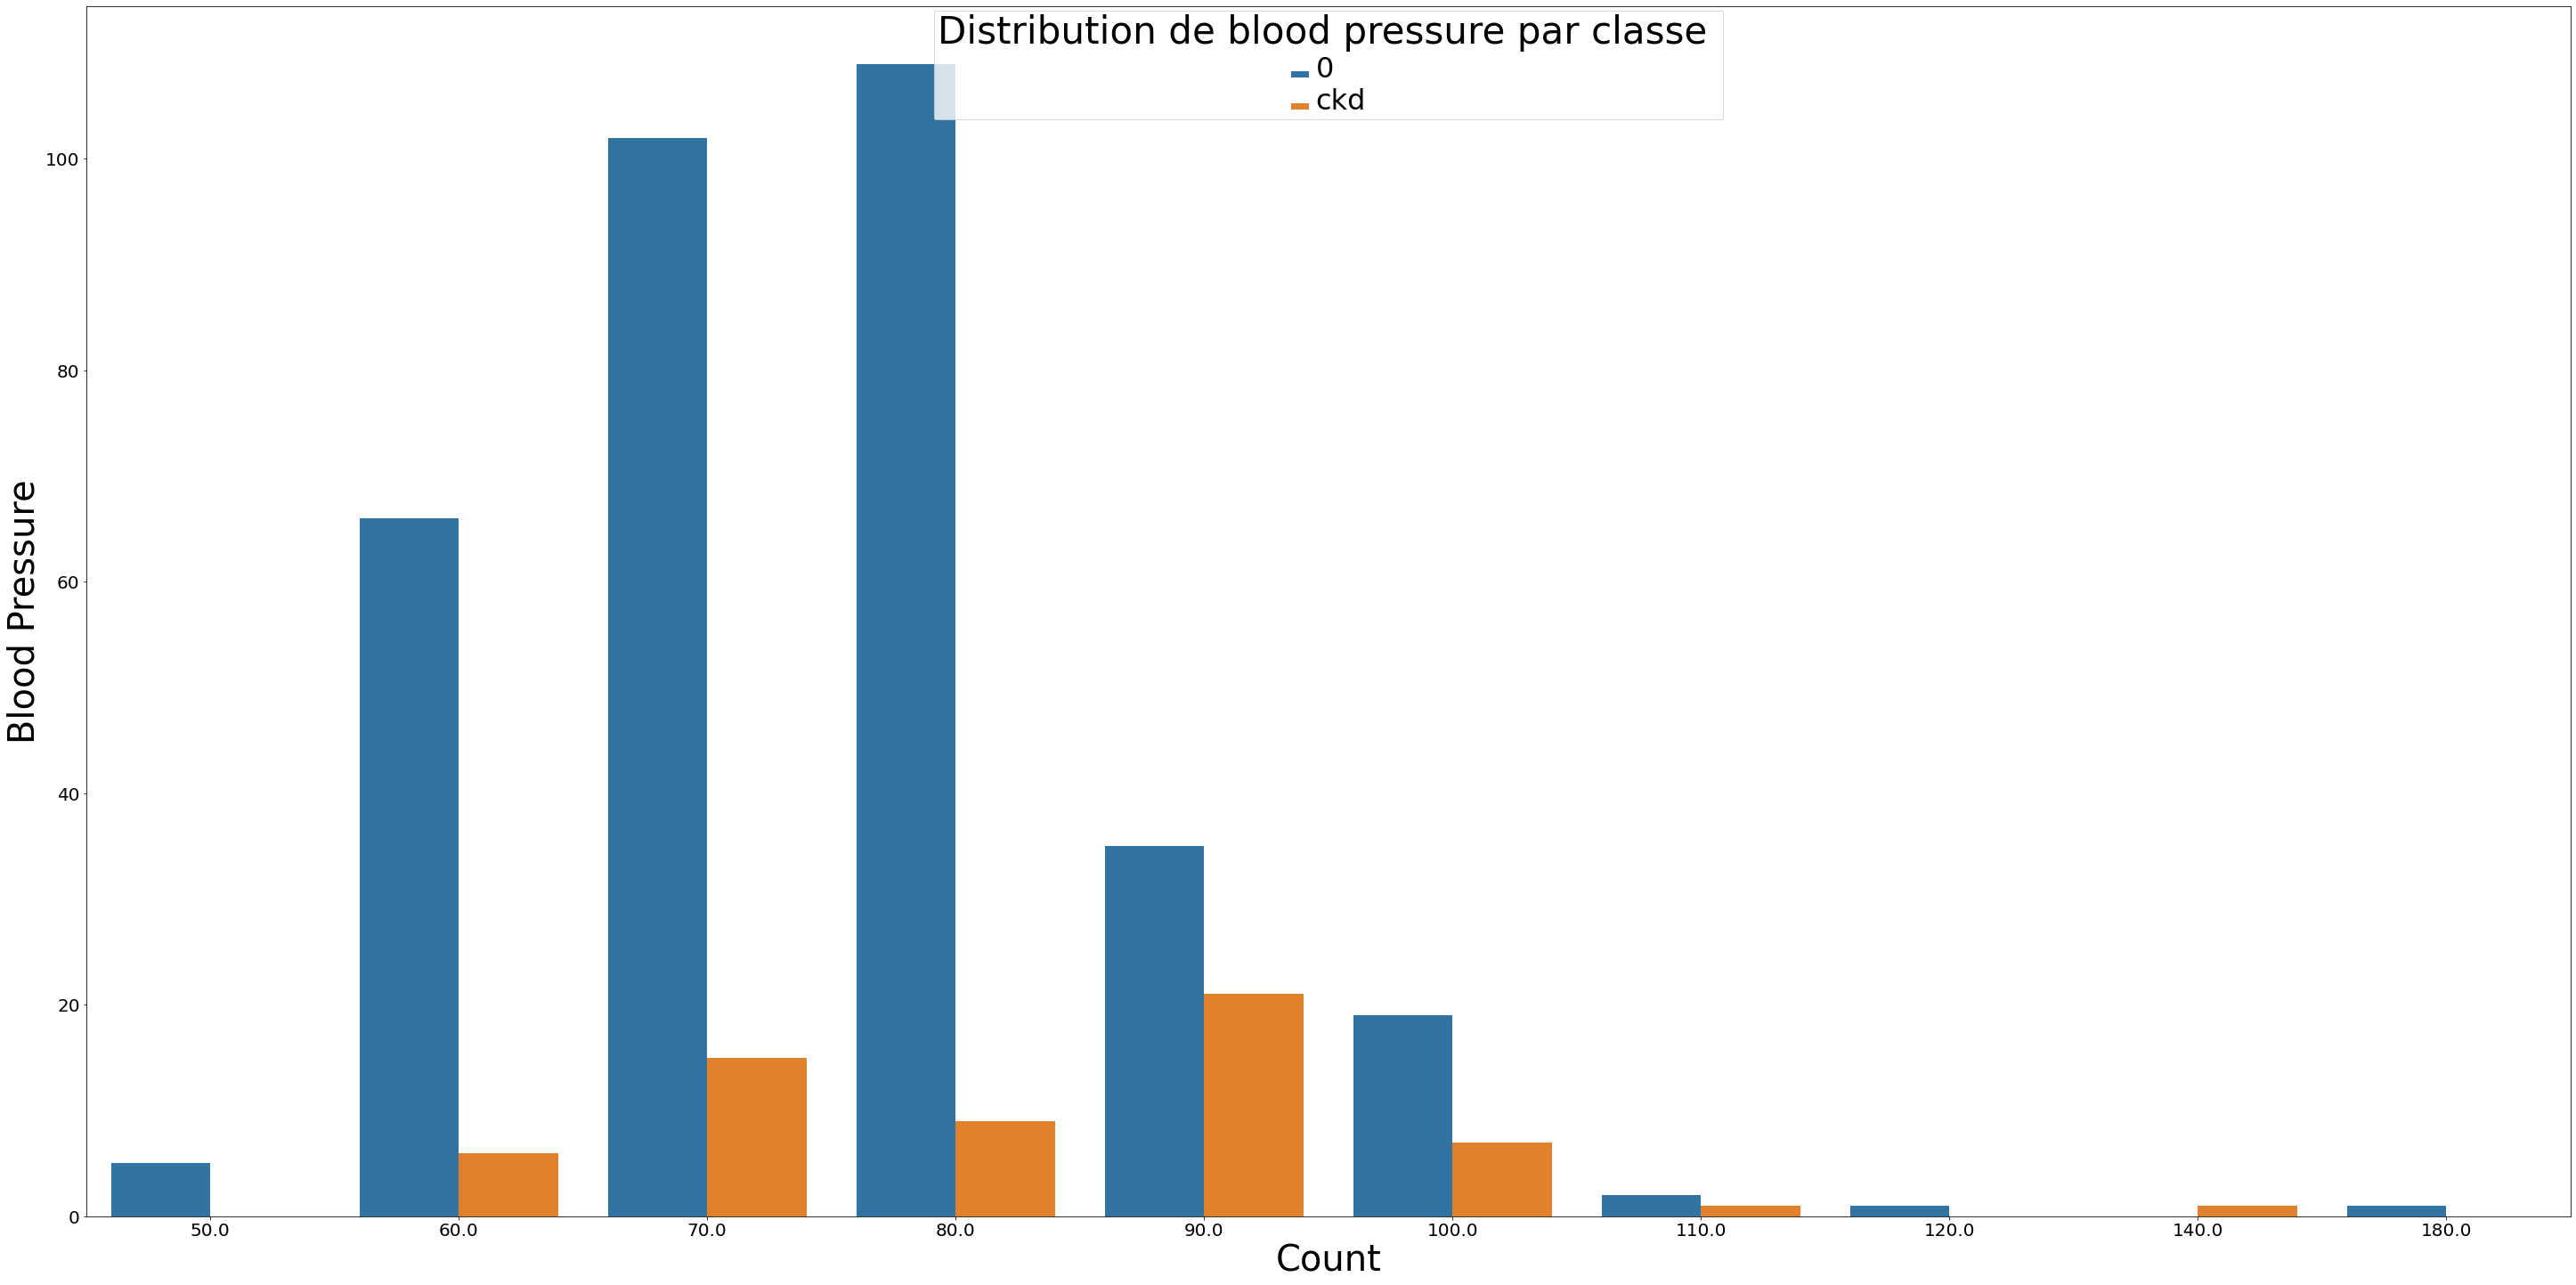

In [197]:
PlottingFunctions.PlotDistribution(CKD_dataframe,'bp',"Distribution de blood pressure par classe ","Blood Pressure")

In [20]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class','bp')

bp     count
bp     1.000000 -0.516339
count -0.516339  1.000000

La correlation est négative mais existe effectivement, nous avançons avec l'hypothèse que si la pression sanguine diminue, le risque d'avoir une insuffisance rénale augmente. Toutefois, il faut prendre ces résultats avec précaution car la relation entre la pression sanguine et de PAS avoir une insuffisance rénale est aussi forte, comme le démontre ces calcules

In [21]:
corr_suited = CKD_dataframe[['class','bp']]
(corr_suited[corr_suited['class'] == 'notckd'].groupby(['bp']).size().reset_index(name = 'count')).corr()


bp   count
bp     1.0000  0.7269
count  0.7269  1.0000

Si nous voulons avoir une meilleure représentation :

Text(0.5, 1.0, 'Correlation graph for bp and ckd patients')

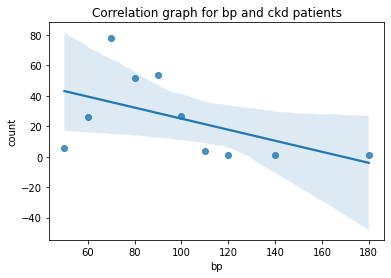

In [22]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby(['bp']).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = 'bp', y = 'count').set_title("Correlation graph for bp and ckd patients")

Text(0.5, 1.0, 'Correlation graph for bp and ckd patients')

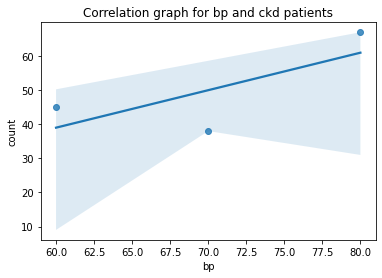

In [23]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'notckd'].groupby(['bp']).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = 'bp', y = 'count').set_title("Correlation graph for bp and ckd patients")

In [35]:
PlottingFunctions.violin(CKD_dataframe,'bp')

Le graphique en violon montre clairement que la corrélation entre bp (blood pressure) et la classe finale est relativement faible. 

### Relation entre le Specific gravity et le fait d'avoir ou pas une insuffisance rénale (+)

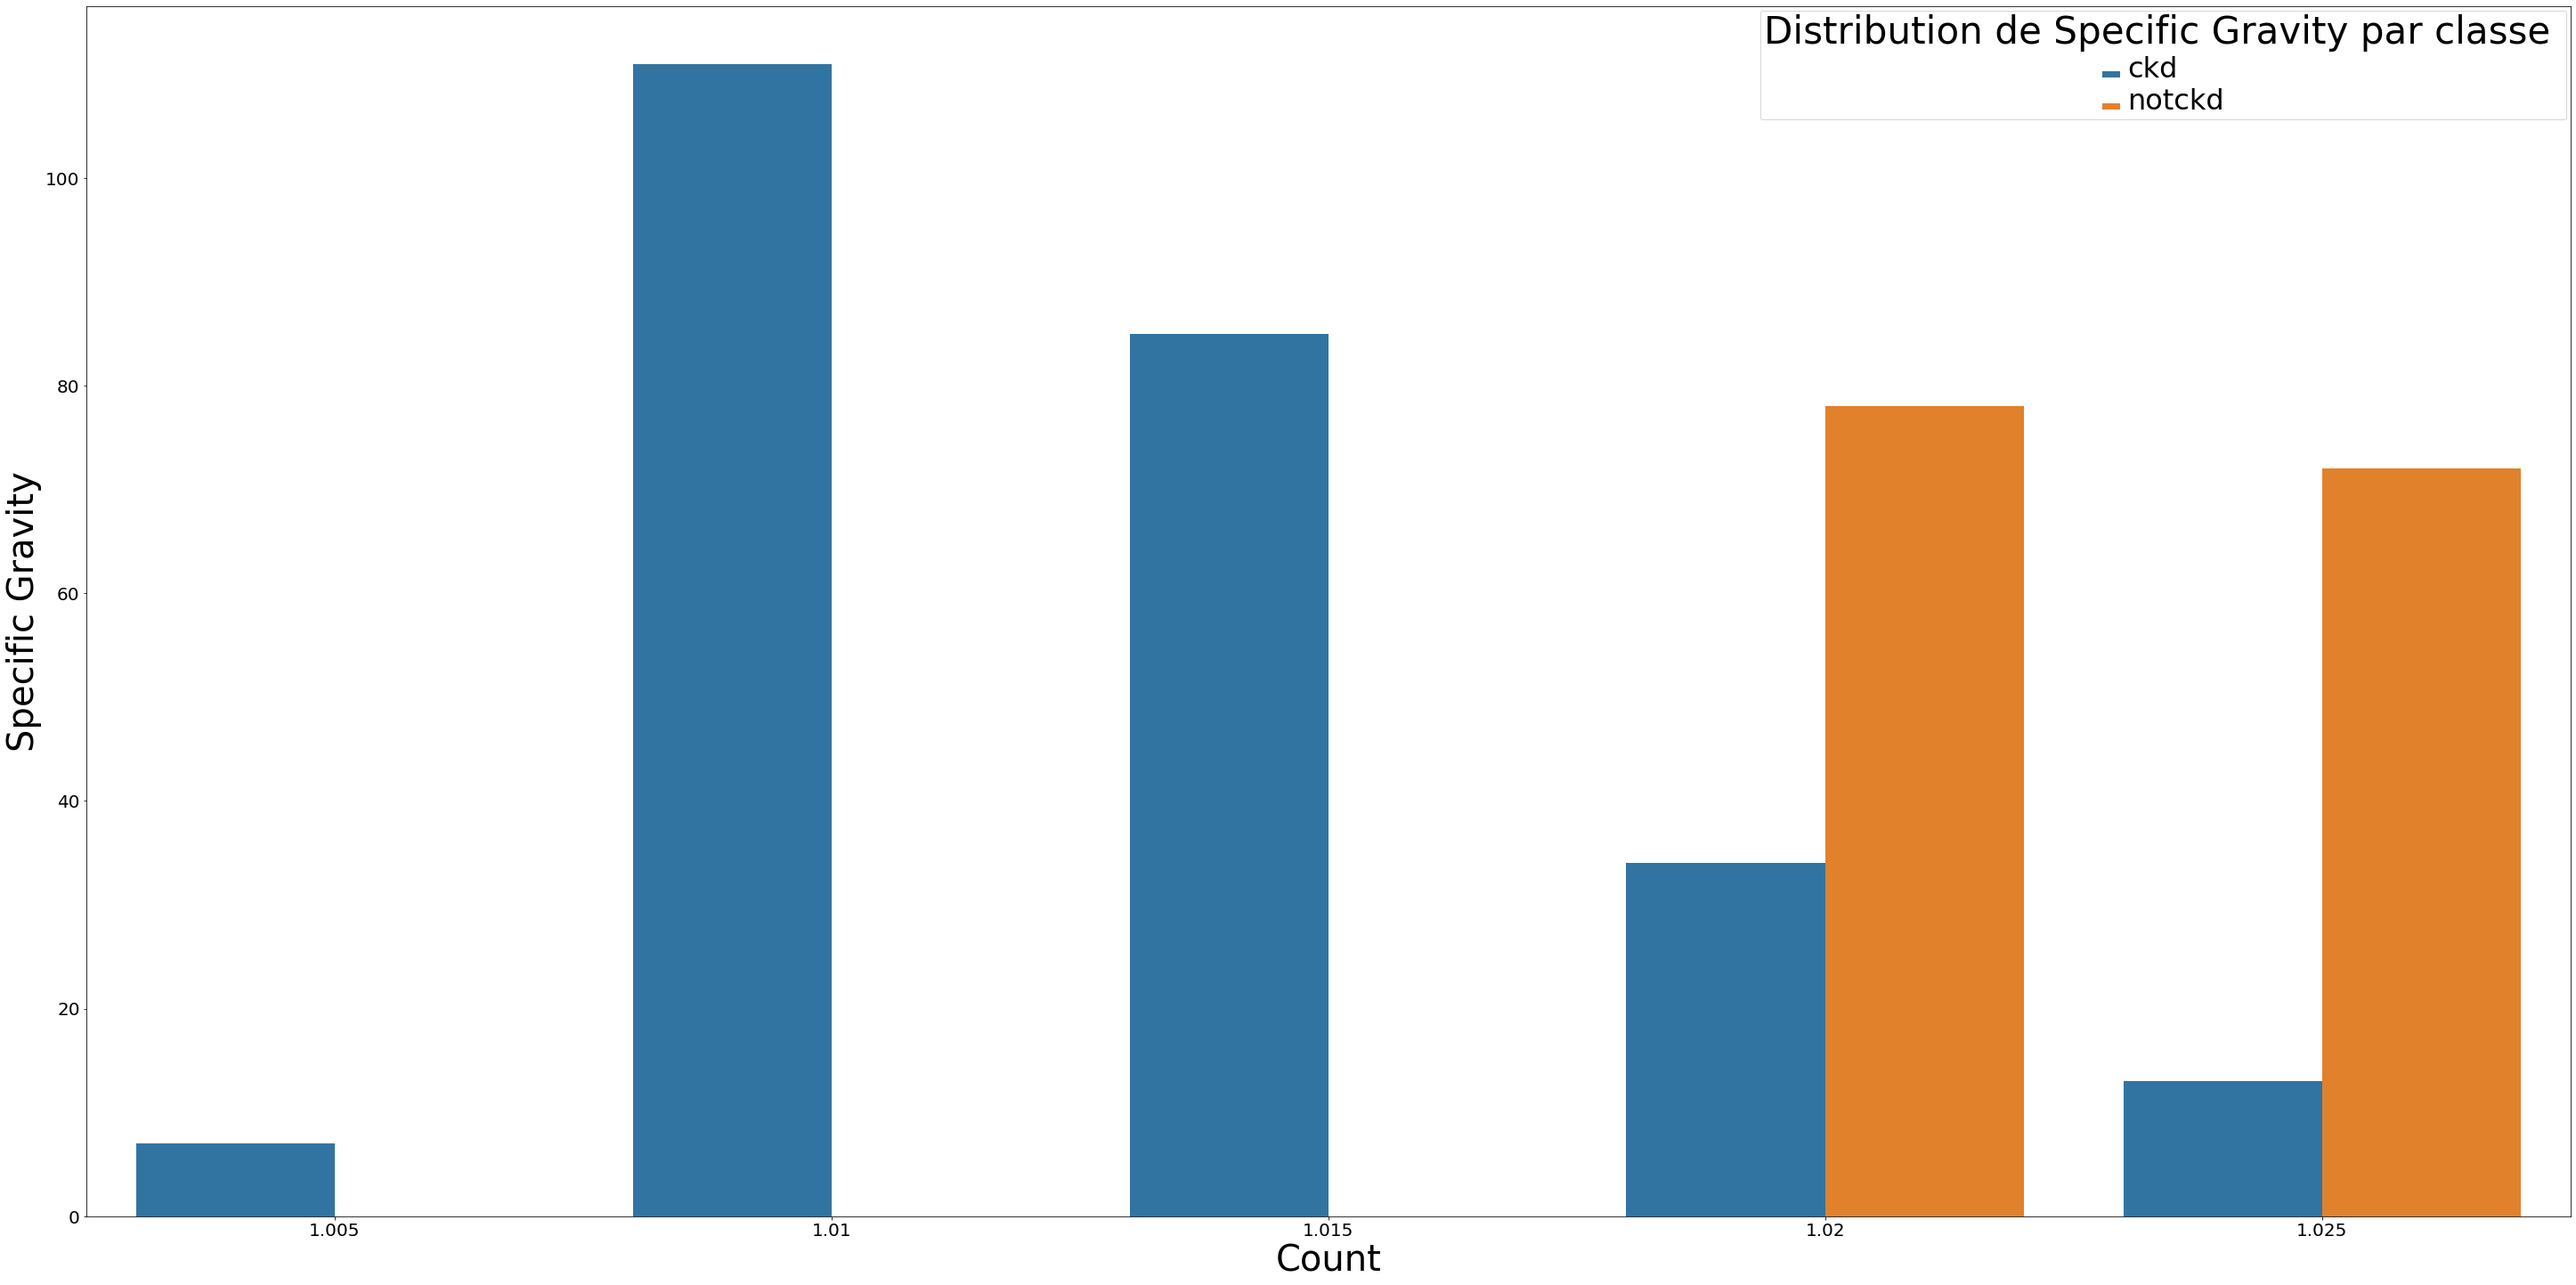

In [138]:
PlottingFunctions.PlotDistribution(CKD_dataframe,'sg',"Distribution de Specific Gravity par classe ","Specific Gravity")

In [139]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class','sg')

sg     count
sg     1.000000 -0.224005
count -0.224005  1.000000

Malgré que le graphique montre qu'il y'a une corrélation entre ces deux variables, la corrélation est trop peu élevé pour s'appuyer dessus. Toutefois, j'ai voulu invéstiguer un peu plus avec le graphique en dessous :

Text(0.5, 1.0, 'Correlation graph for sg and ckd patients')

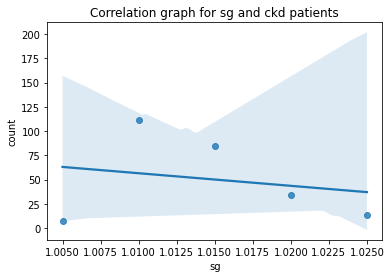

In [140]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby(['sg']).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = 'sg', y = 'count').set_title("Correlation graph for sg and ckd patients")

Nous remarquons que la corrélation overall est quasi stable, les valeurs 1.01 et 1.015 montrent quelques patient qui ont le CKD mais, cette valeur ne suit pas et retombe pour les valeurs 1.02 et 1.025.

Une meilleure investigation peu être faite a partir du graphique suivant 

In [141]:
PlottingFunctions.violin(CKD_dataframe,'sg')

Le graphique ci dessus nous montre que la corrélation négative entre la specific gravity et le fait qu'un patient soit CKD existe !

### Relation entre l'albumine et le fait d'avoir ou pas une insuffisance rénale (+)

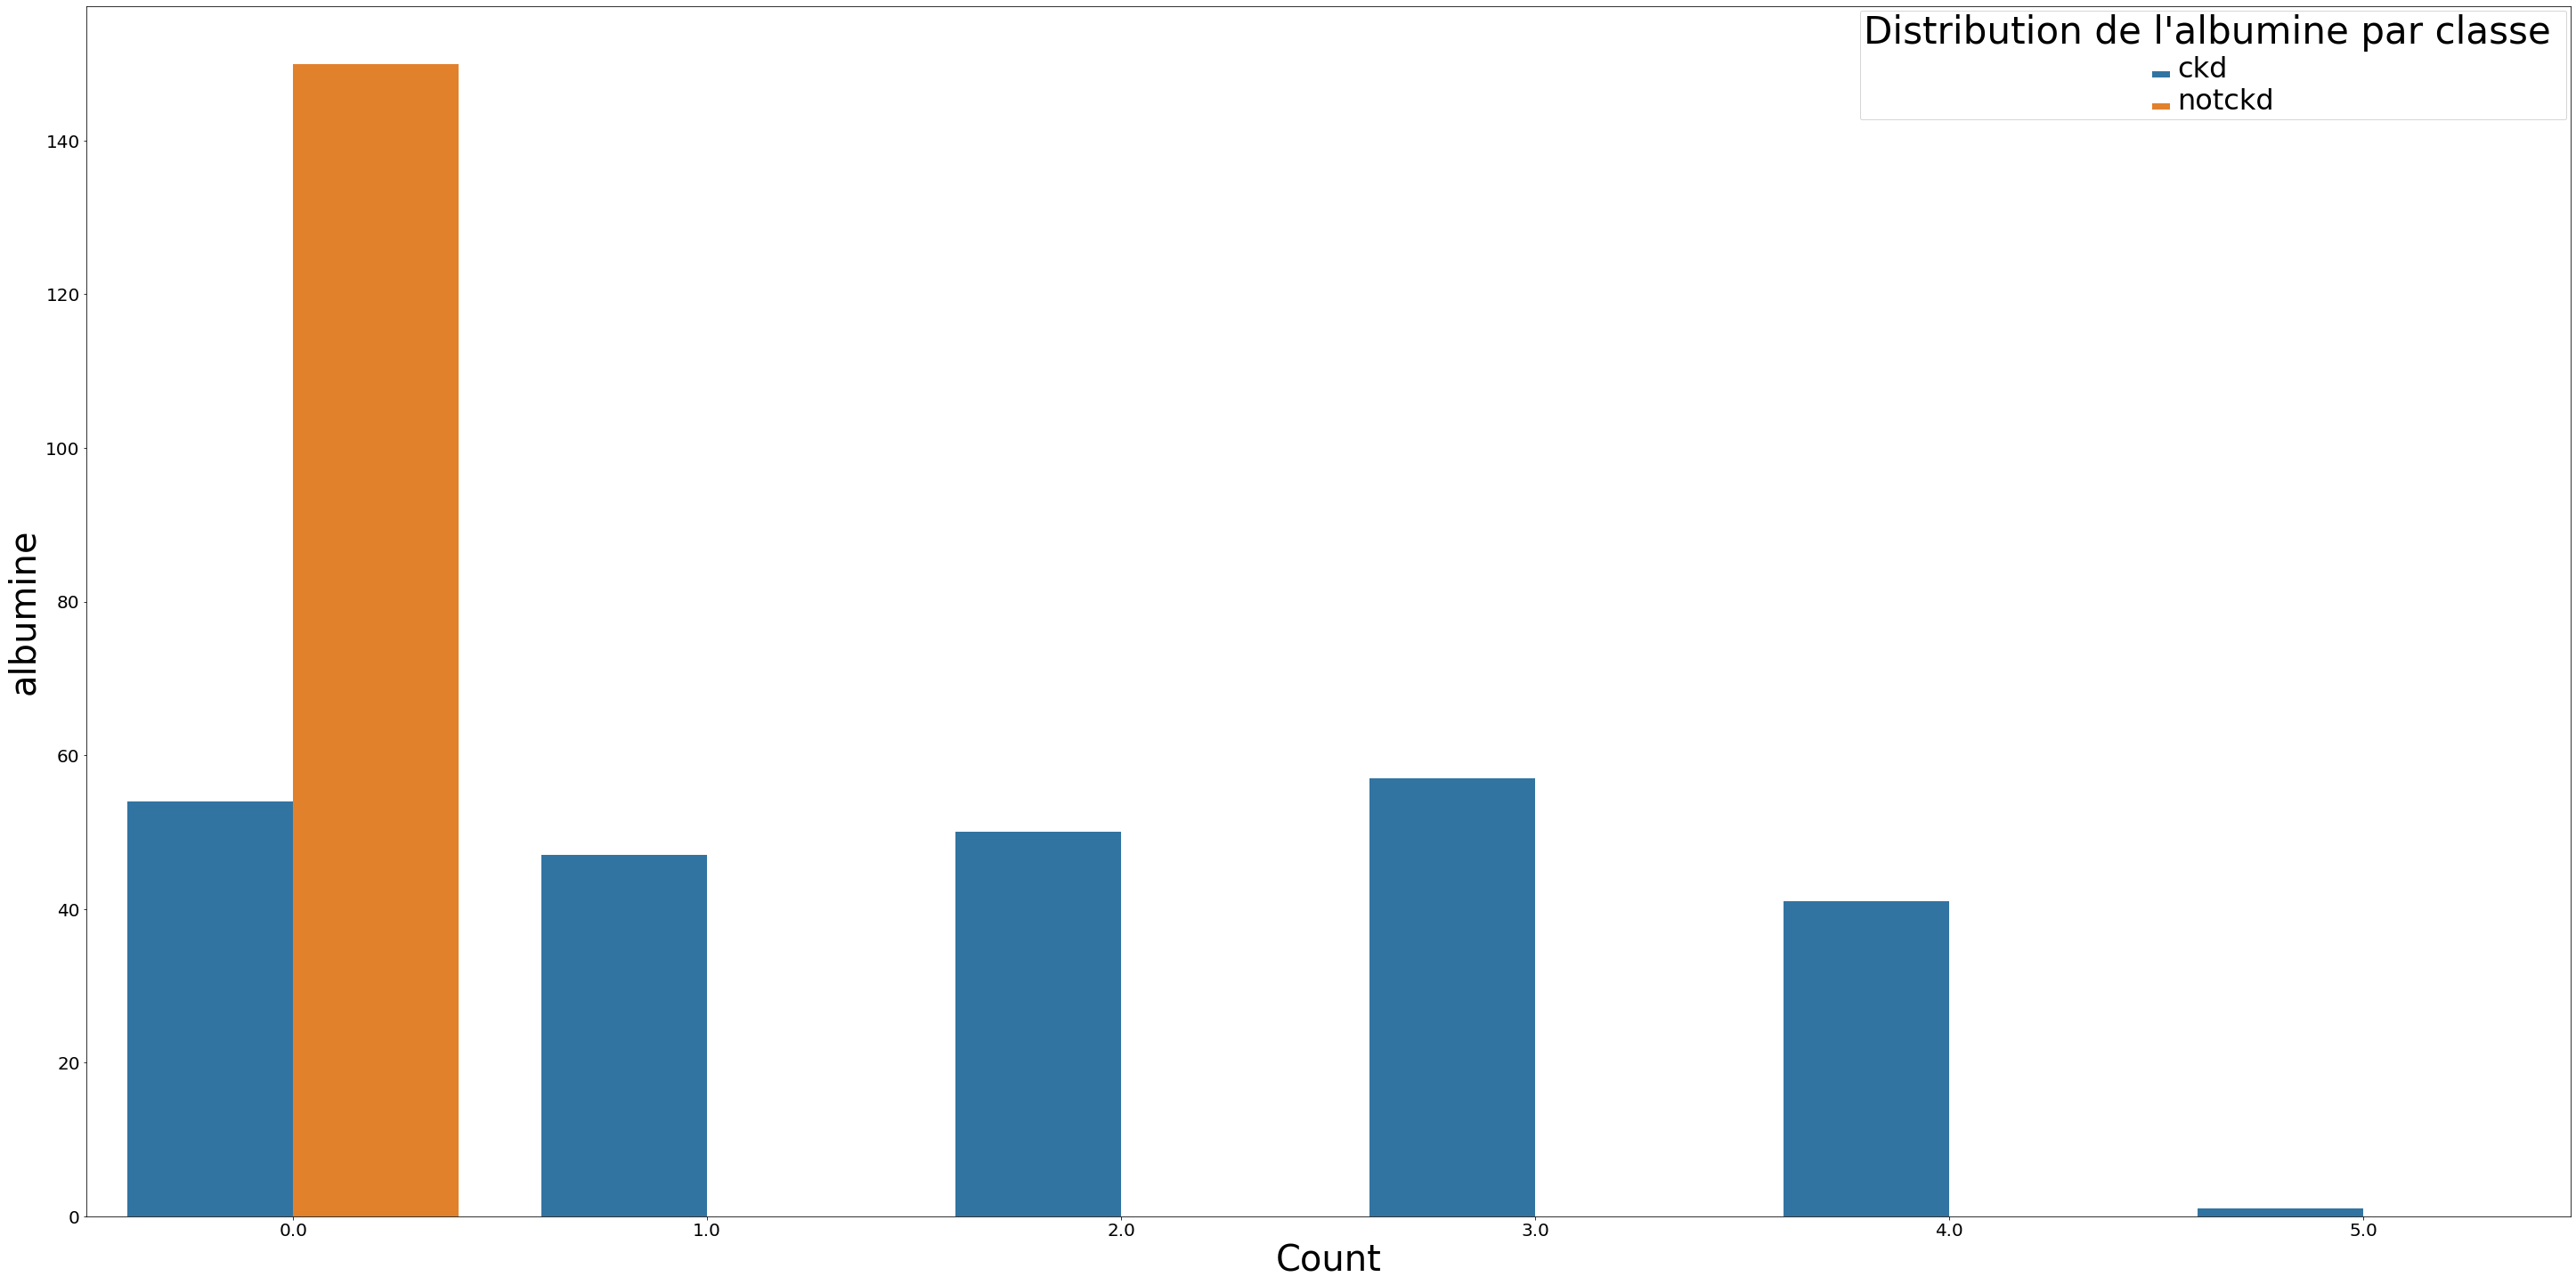

In [36]:
PlottingFunctions.PlotDistribution(CKD_dataframe,'al',"Distribution de l'albumine par classe ","albumine")

In [37]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class','al')

al     count
al     1.000000 -0.713216
count -0.713216  1.000000

Le graphique et la corrélation montrent les deux qu'il existe une relation certaine entre les deux variables. 
Lorsqu' l'albumine augmente, les cas d'inssufisance rénale diminues. 

Text(0.5, 1.0, 'Correlation graph for al vs chronic kidney disease')

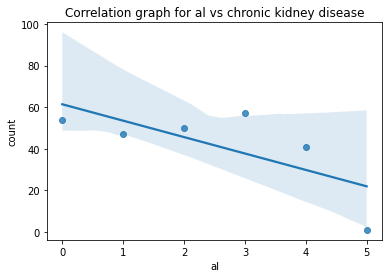

In [38]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby(['al']).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = 'al', y = 'count').set_title("Correlation graph for al vs chronic kidney disease")

Le graphique ci-dessus le confirme !

In [39]:
PlottingFunctions.violin(CKD_dataframe,'al')

Il est très claire qu'une albumine supérieur a 0 pousse les patient a avoir une insufisance rénale

### Relation entre le sucre et le fait d'avoir ou pas une insuffisance rénale (+)

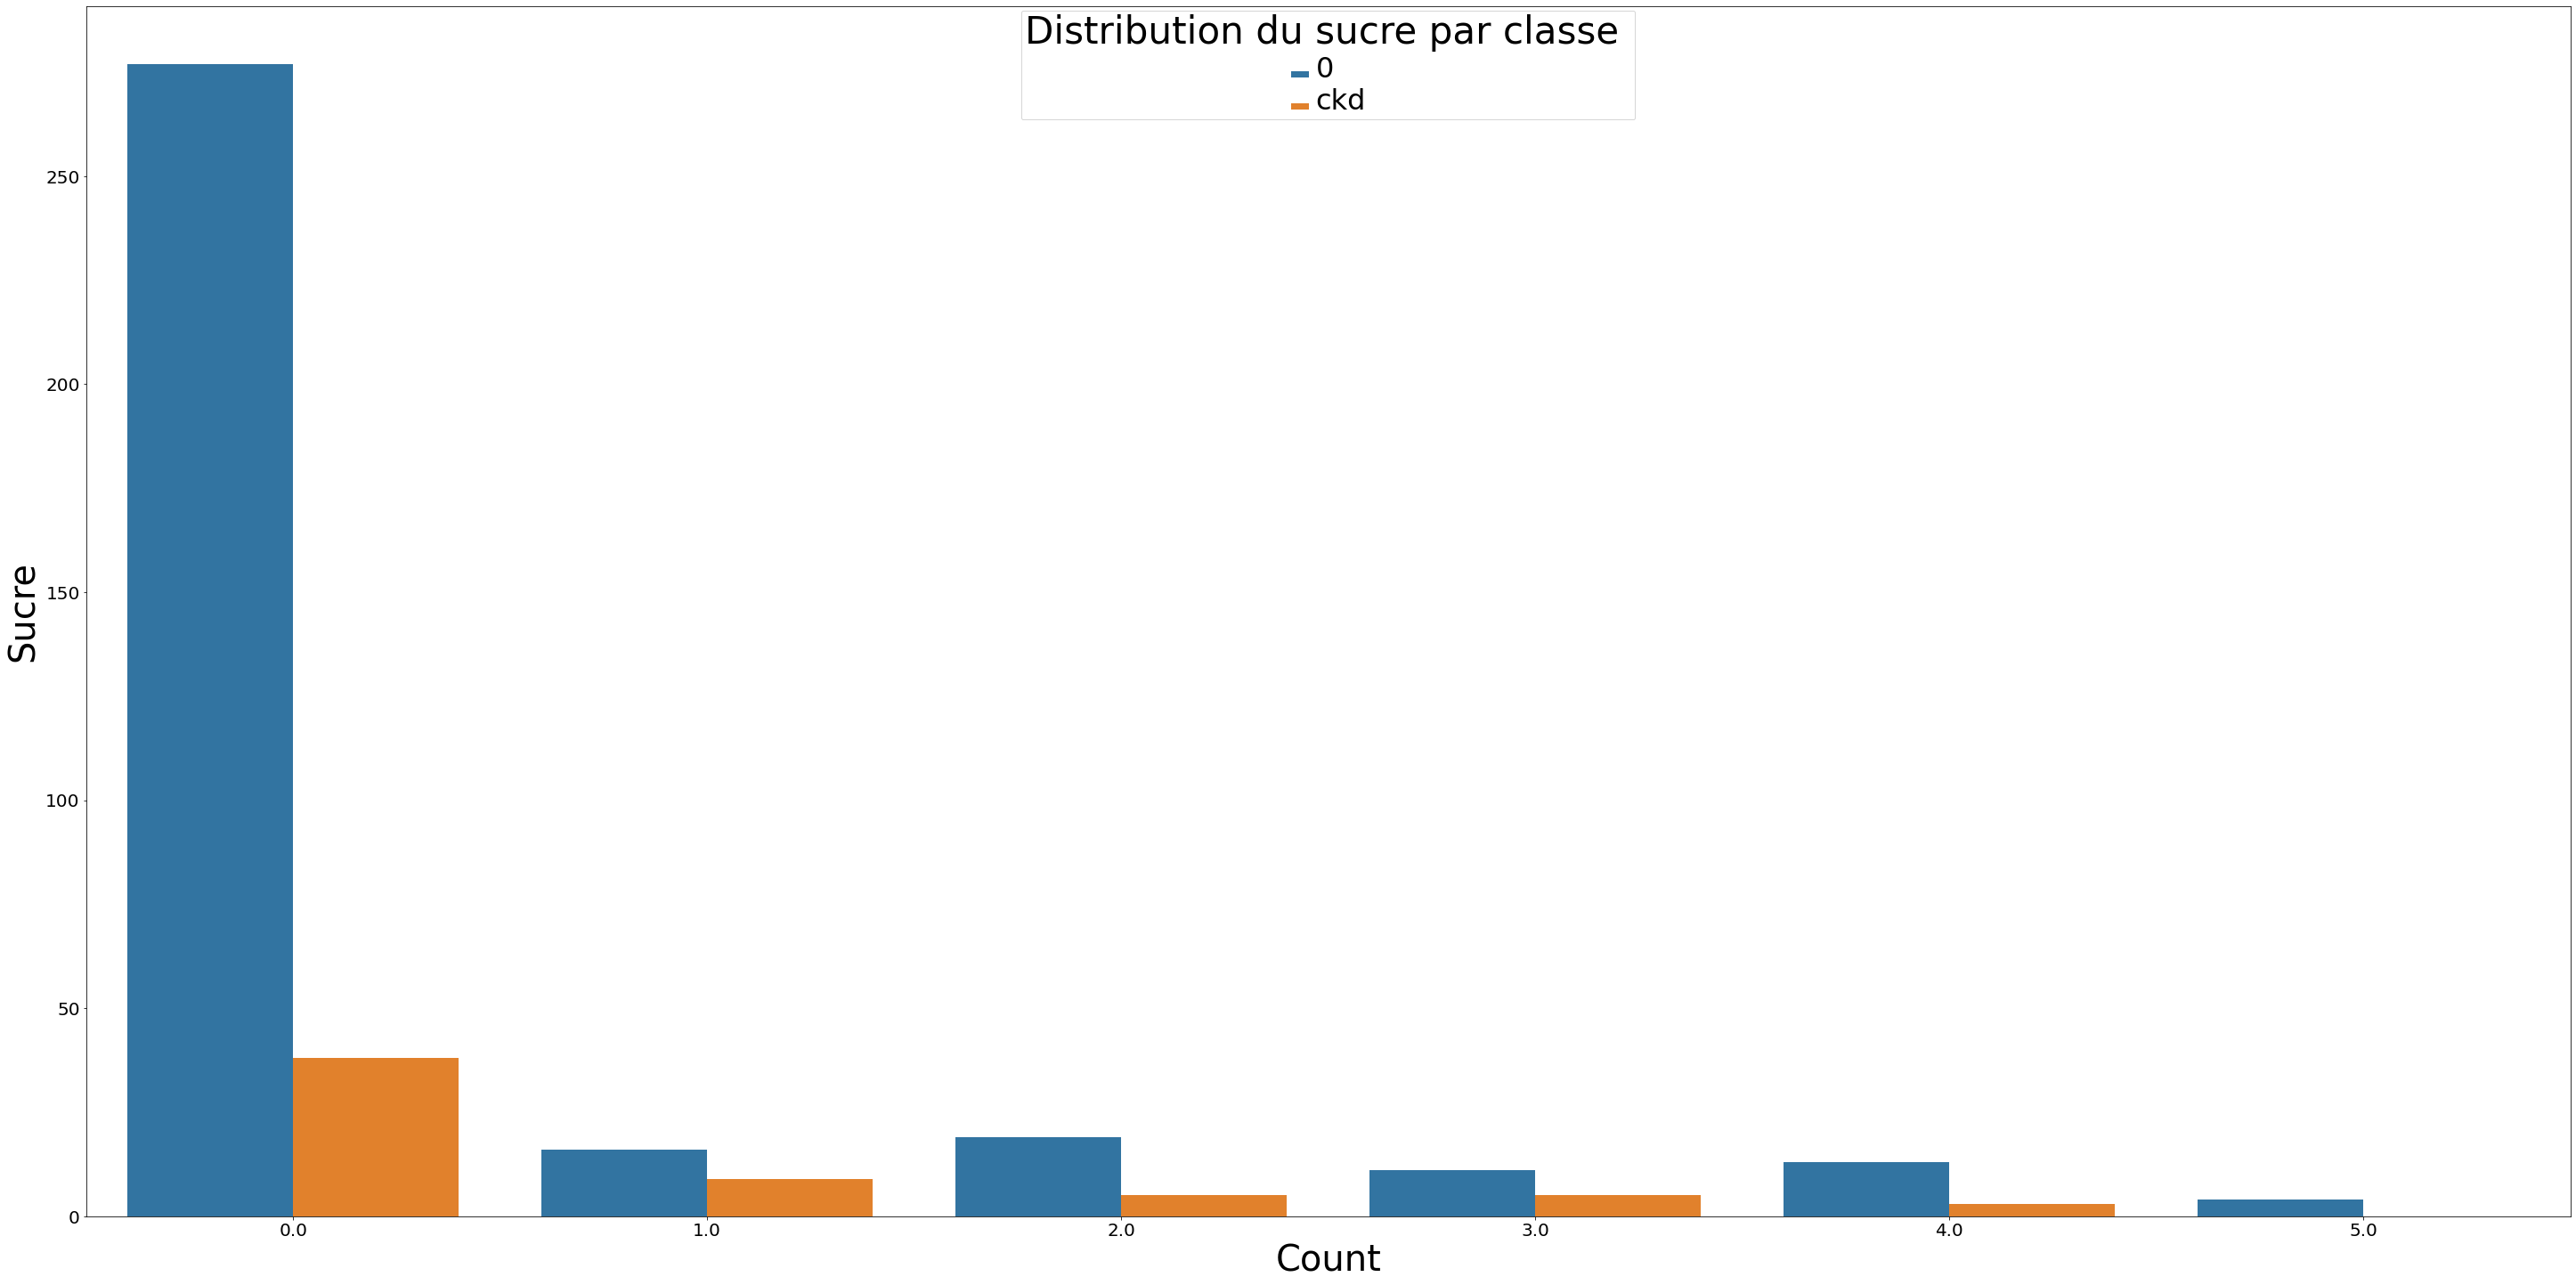

In [209]:
PlottingFunctions.PlotDistribution(CKD_dataframe,'su',"Distribution du sucre par classe ","Sucre")

In [210]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class','su')

su     count
su     1.000000 -0.796113
count -0.796113  1.000000

Text(0.5, 1.0, 'Correlation graph for al vs chronic kidney disease')

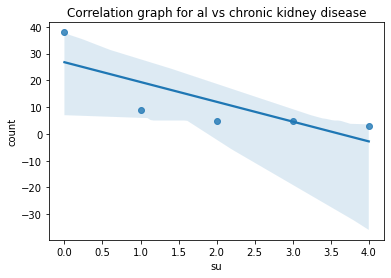

In [211]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby(['su']).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = 'su', y = 'count').set_title("Correlation graph for al vs chronic kidney disease")

In [43]:
PlottingFunctions.violin(CKD_dataframe,'su')

Constat similaire que pour l'albumine avec un peu moins d'effet. Mais l'existance d'une corrélation est bel et bien la. Les patient qui ont un taux de sucre sont CKD ! Toutefois, ce constat ne peut s'appliquer que sur notre distribution et n'est pas le cas dans la vrai vie. Ceux qui ont le sucre n'ont pas forcément une insufisance rénale

### Relation entre le red blood cells(rdc) et le fait d'avoir ou pas une insuffisance rénale (+)

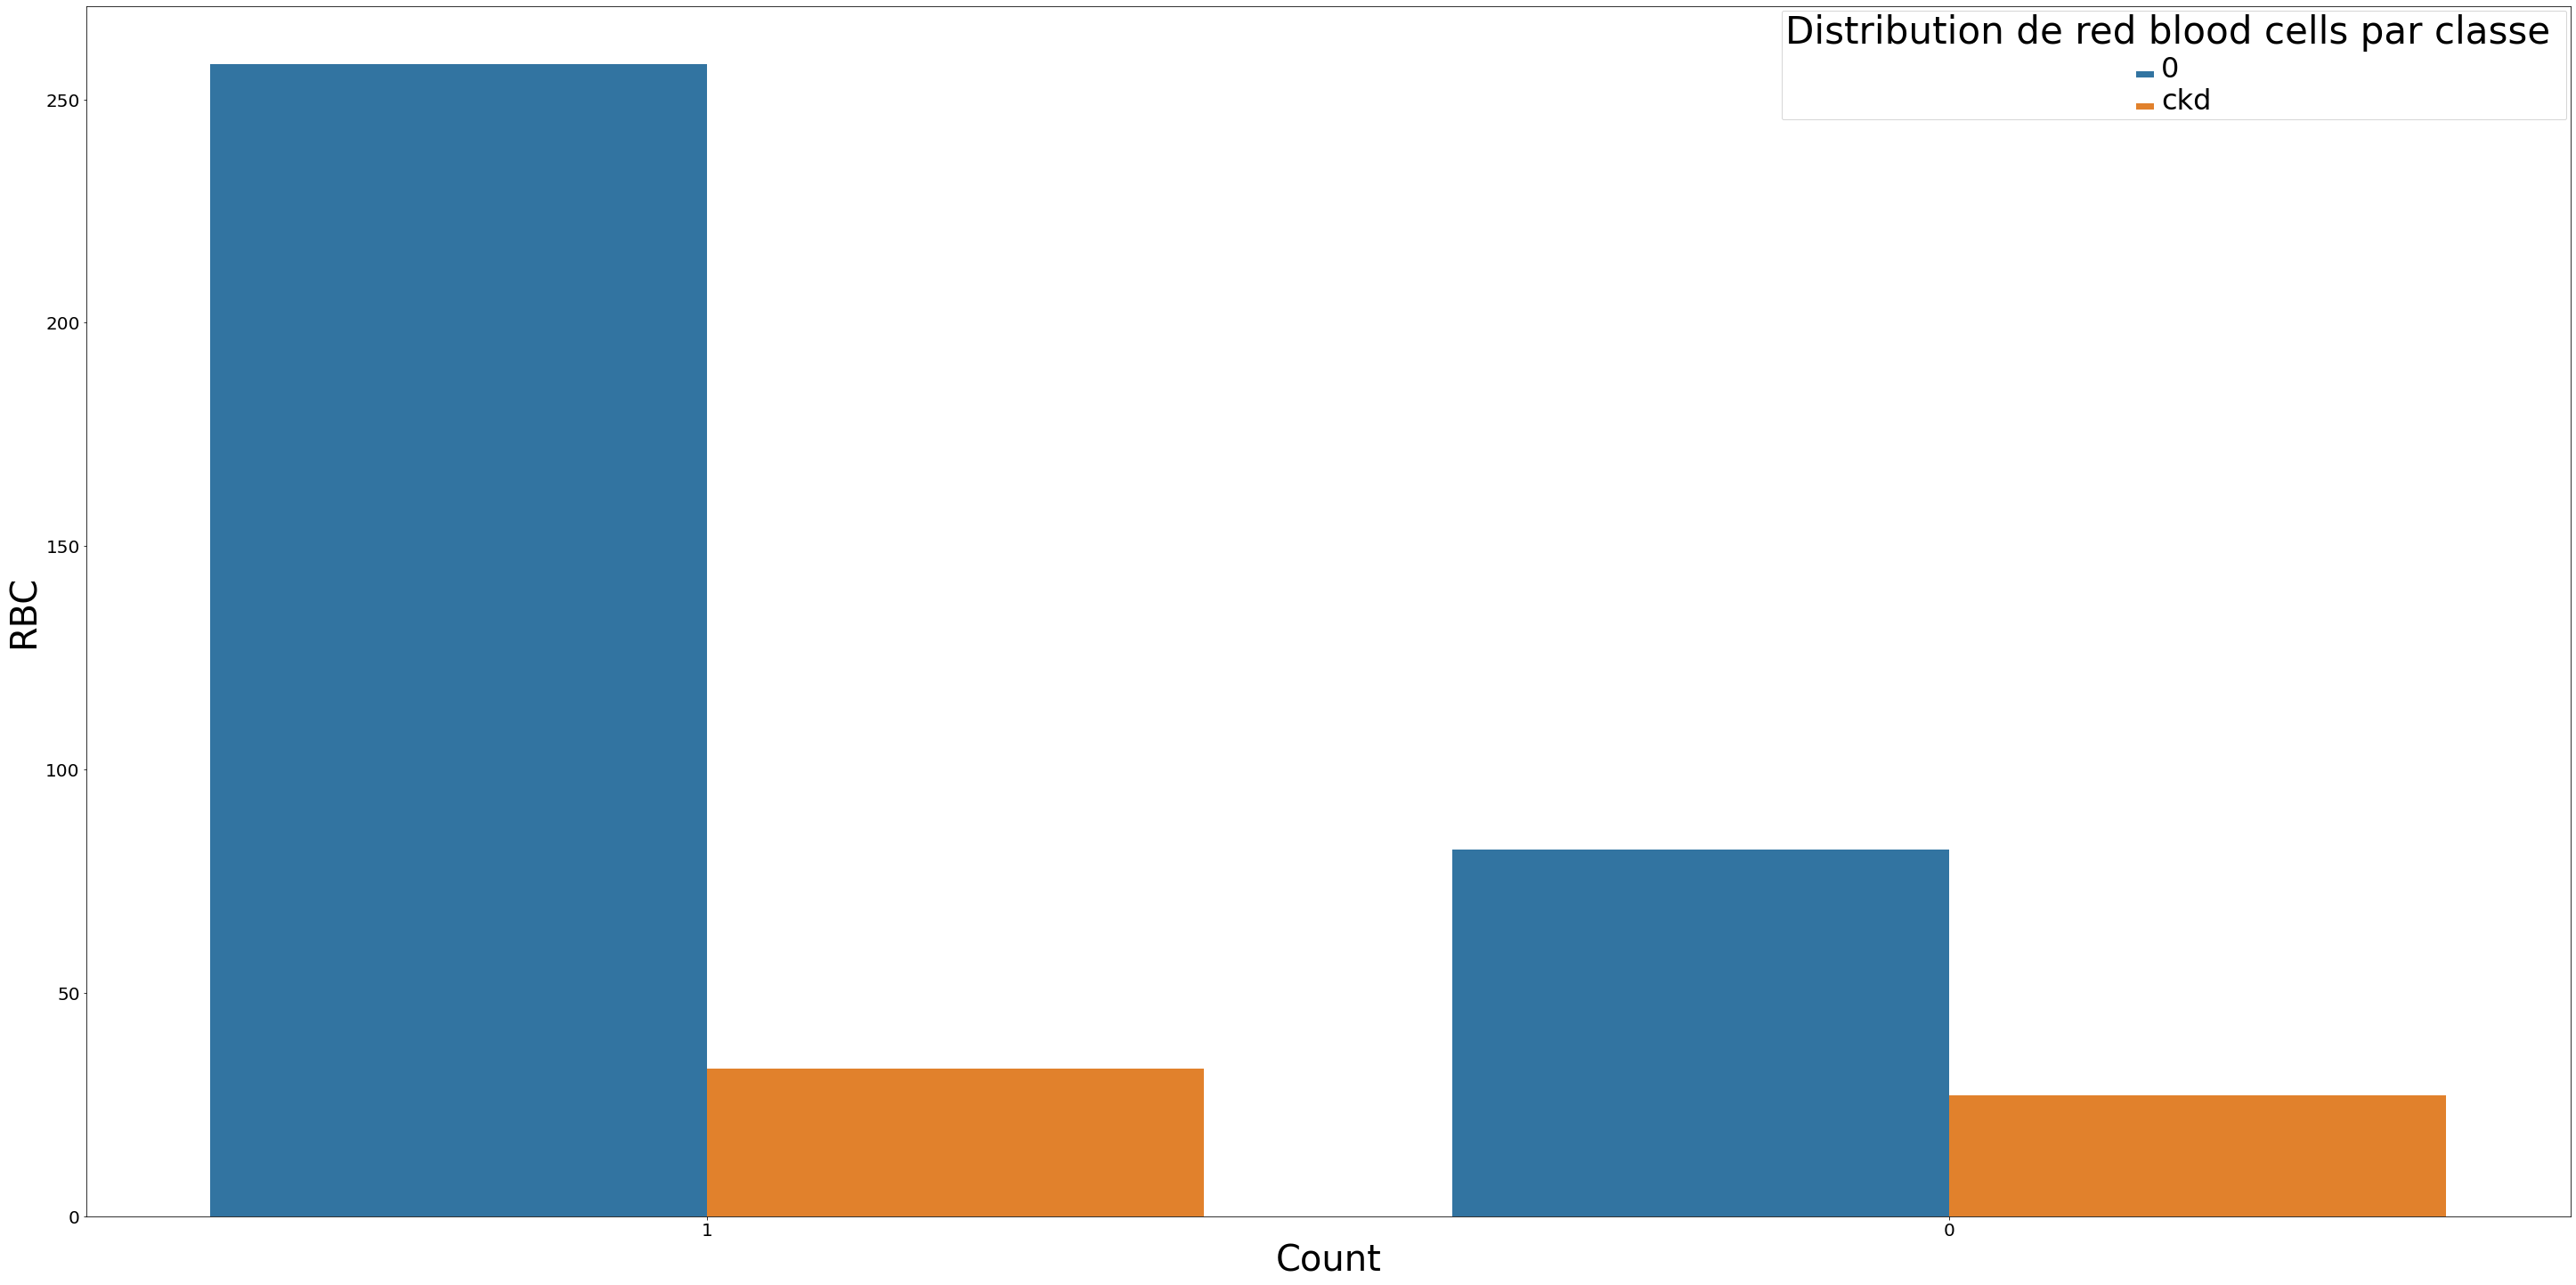

In [212]:
currentVariable='rbc'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de red blood cells par classe ","RBC")


En prennant en considération que rbc est une variable nominale transformée en une valeur numérique, il est préférable d'utiliser le Fisher exact test ( du fait que la population que nous disposons est assez petite)

In [44]:
cont = pd.crosstab(CKD_dataframe["rbc"],CKD_dataframe["class"])
scipy.stats.fisher_exact(cont)

(inf, 9.282913037232746e-24)

Le test retournée est positif "il existe une relation entre le rdc et le fait que la patient a une insufisance rénale"" du fait que la p-value retournée par le fisher exact test est inférieur a 0.05 (9.282913037232746e-24)


Pour en avoir le coeur net, nous procédons a la mise en place de ce graphique qui montre clairemnt une relation entre les patient ckd et une rbc inferieur a 1

In [47]:
PlottingFunctions.violin(CKD_dataframe,'rbc')

### Relation entre le pus cell (pc) et le fait d'avoir ou pas une insuffisance rénale (+)

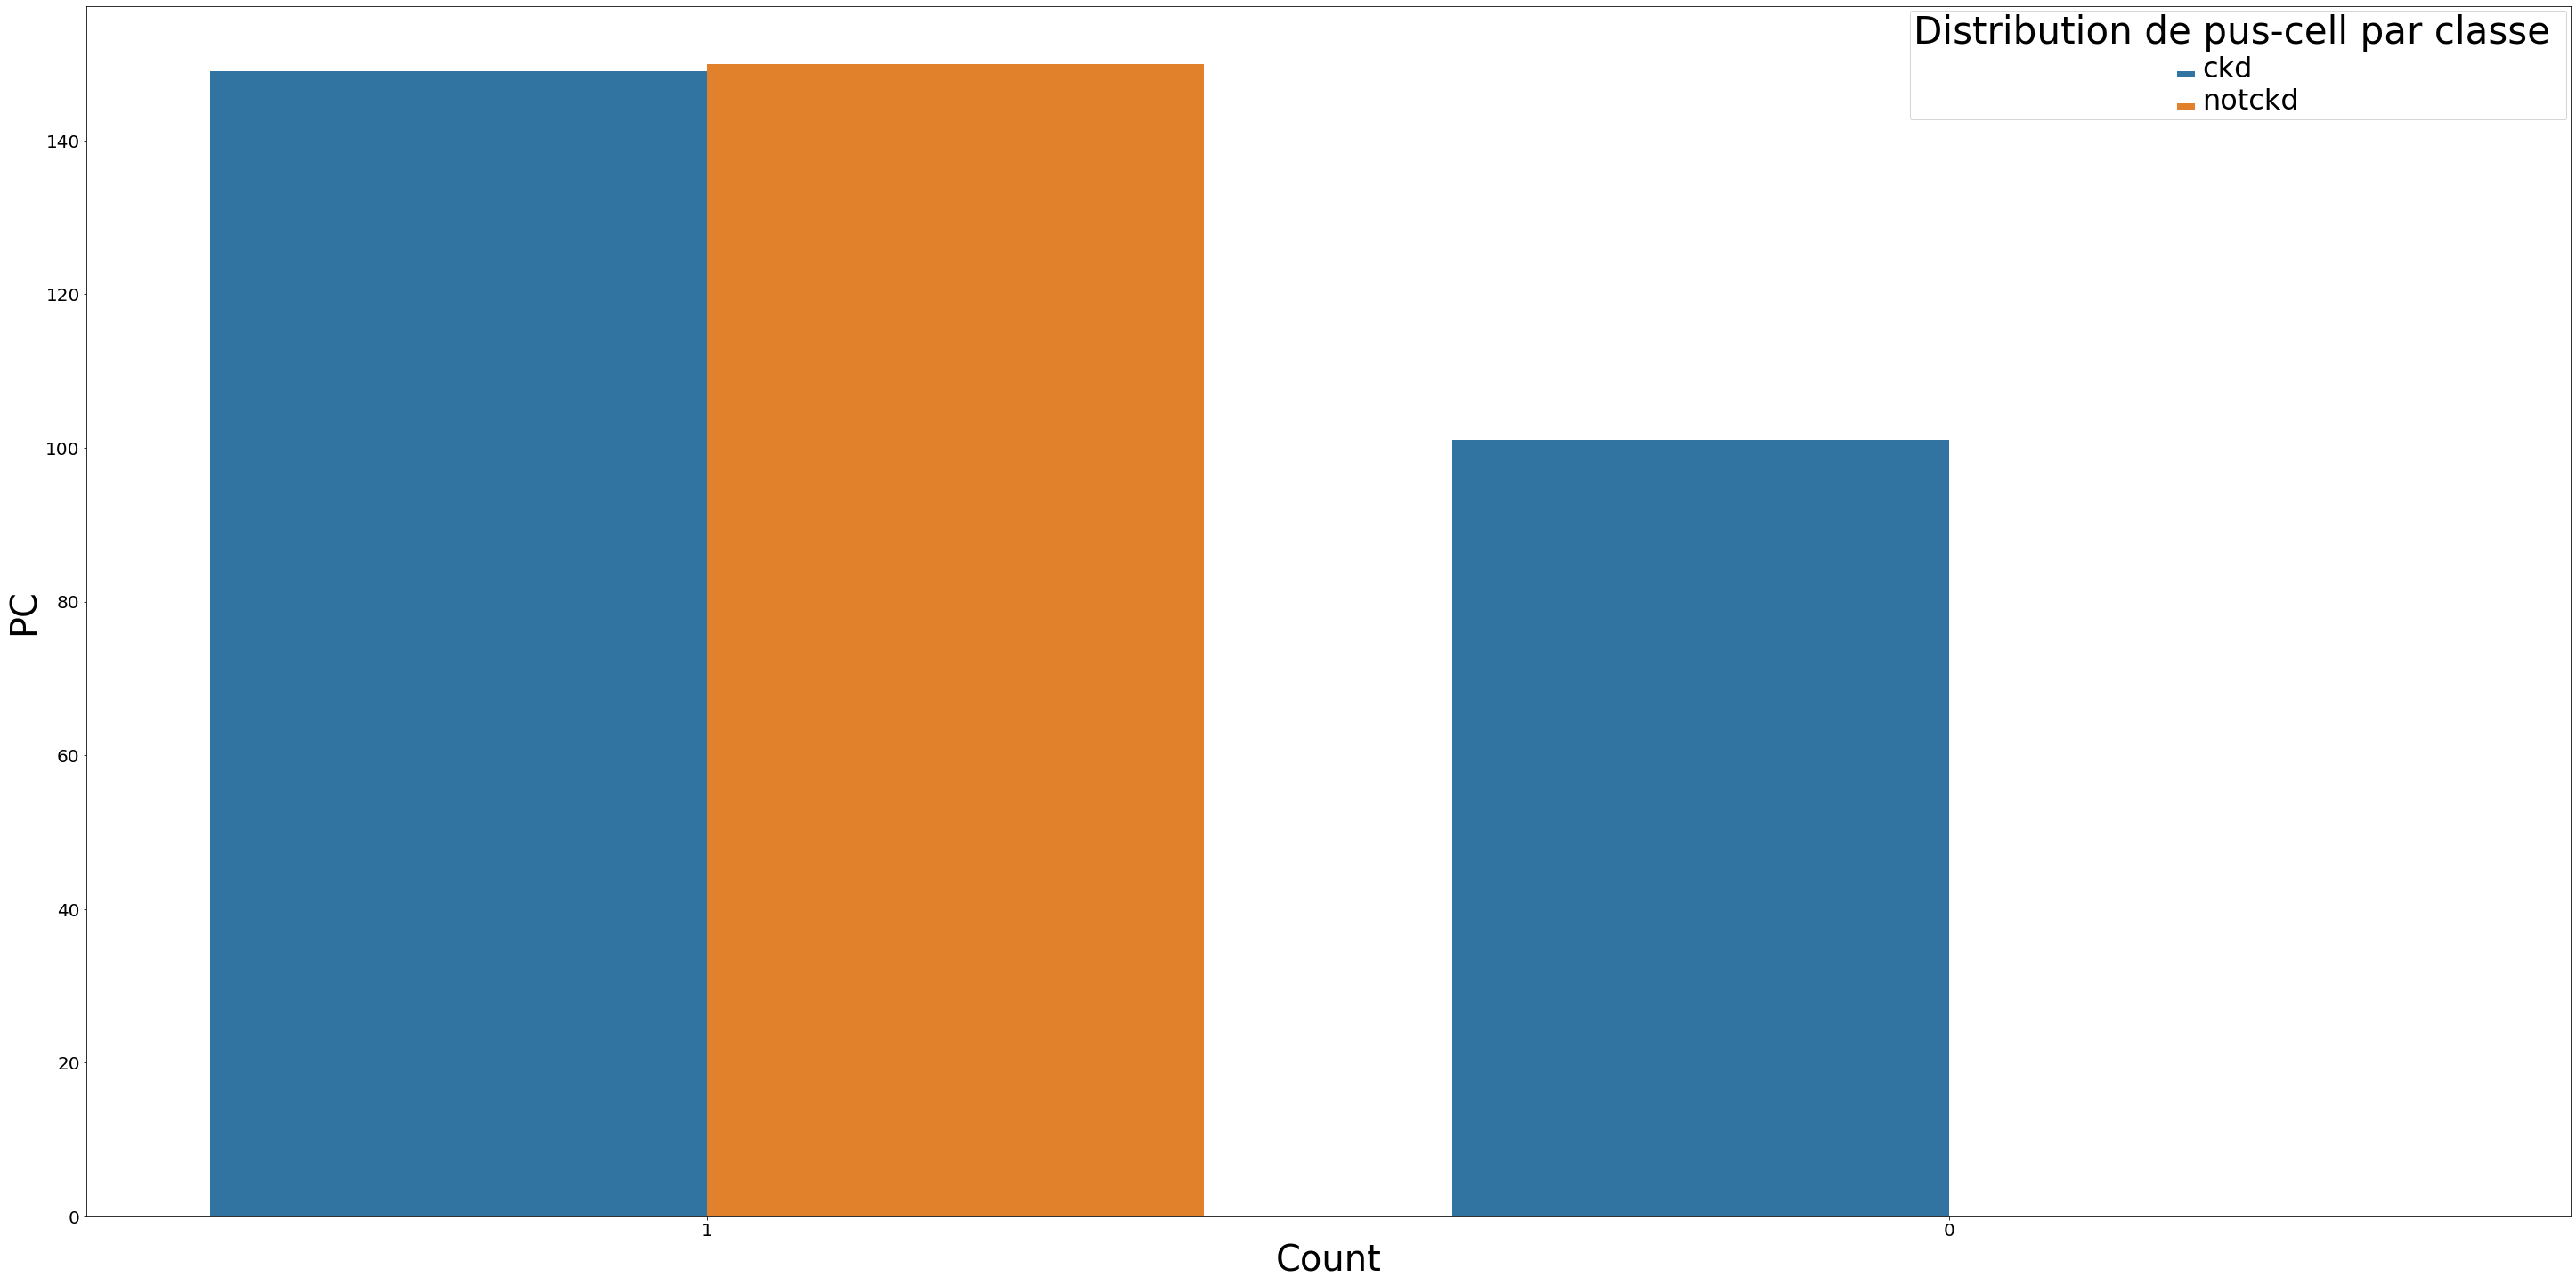

In [48]:
currentVariable='pc'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de pus-cell par classe ","PC")


Une valeur aussi nominal, un test similaire qu'au précédent est effectué. Cette fois ci, nous allons utilisé le `chi2_contingency`

In [49]:
cont = pd.crosstab(CKD_dataframe["pc"],CKD_dataframe["class"])
scipy.stats.chi2_contingency(cont)

(78.94389438943894, 6.389911451223653e-19, 1, array([[ 63.125,  37.875],
        [186.875, 112.125]]))

Aussi, nous remarquon ici que la p-value est inférieur a 0.05 (6.389911451223653e-19)
la relation entre ces deux variable est inévitable

### Relation entre le pus cell clumps (pcc) et le fait d'avoir ou pas une insuffisance rénale (+)

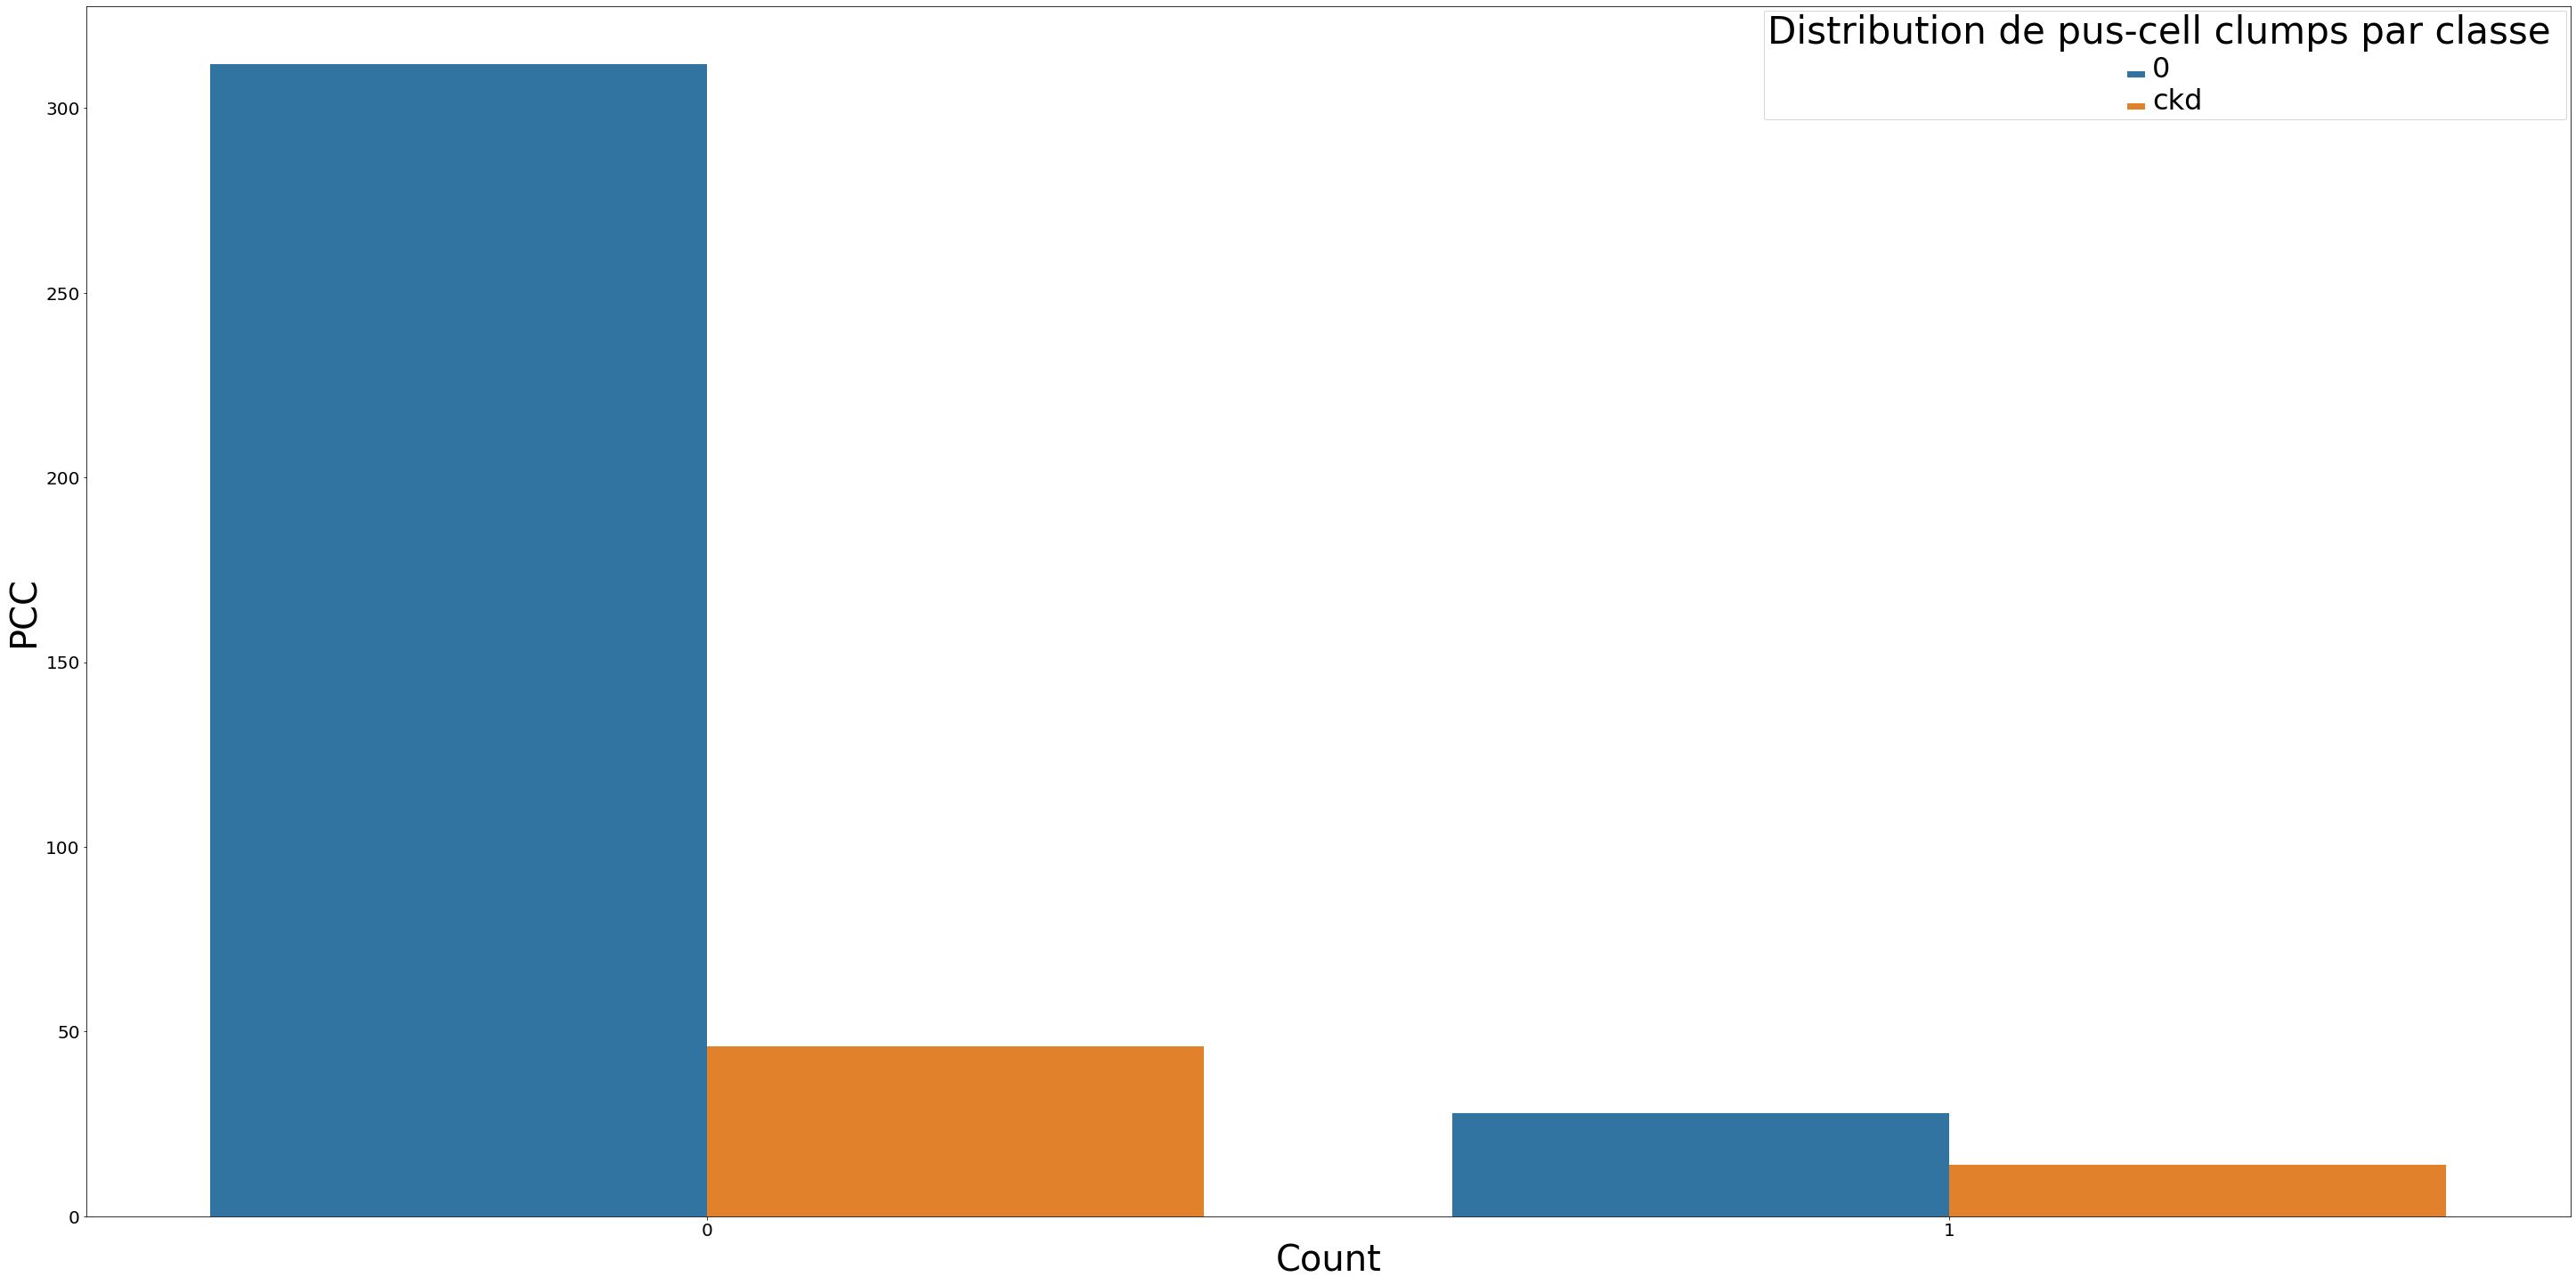

In [216]:
currentVariable='pcc'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de pus-cell clumps par classe ","PCC")

In [50]:
cont = pd.crosstab(CKD_dataframe["pcc"],CKD_dataframe["class"])
scipy.stats.chi2_contingency(cont)

(26.397091425024385, 2.779587257224494e-07, 1, array([[223.75, 134.25],
        [ 26.25,  15.75]]))

Meme remarque que pour la variable étudié précédemment avec cette fois ci une p-value de 2.779587257224494e-07. Toutefois le fait qu'il y'a trop peu de valeurs pour les patient avec pcc me met en doute.

### Relation entre le bacteria(ba) et le fait d'avoir ou pas une insuffisance rénale (-)


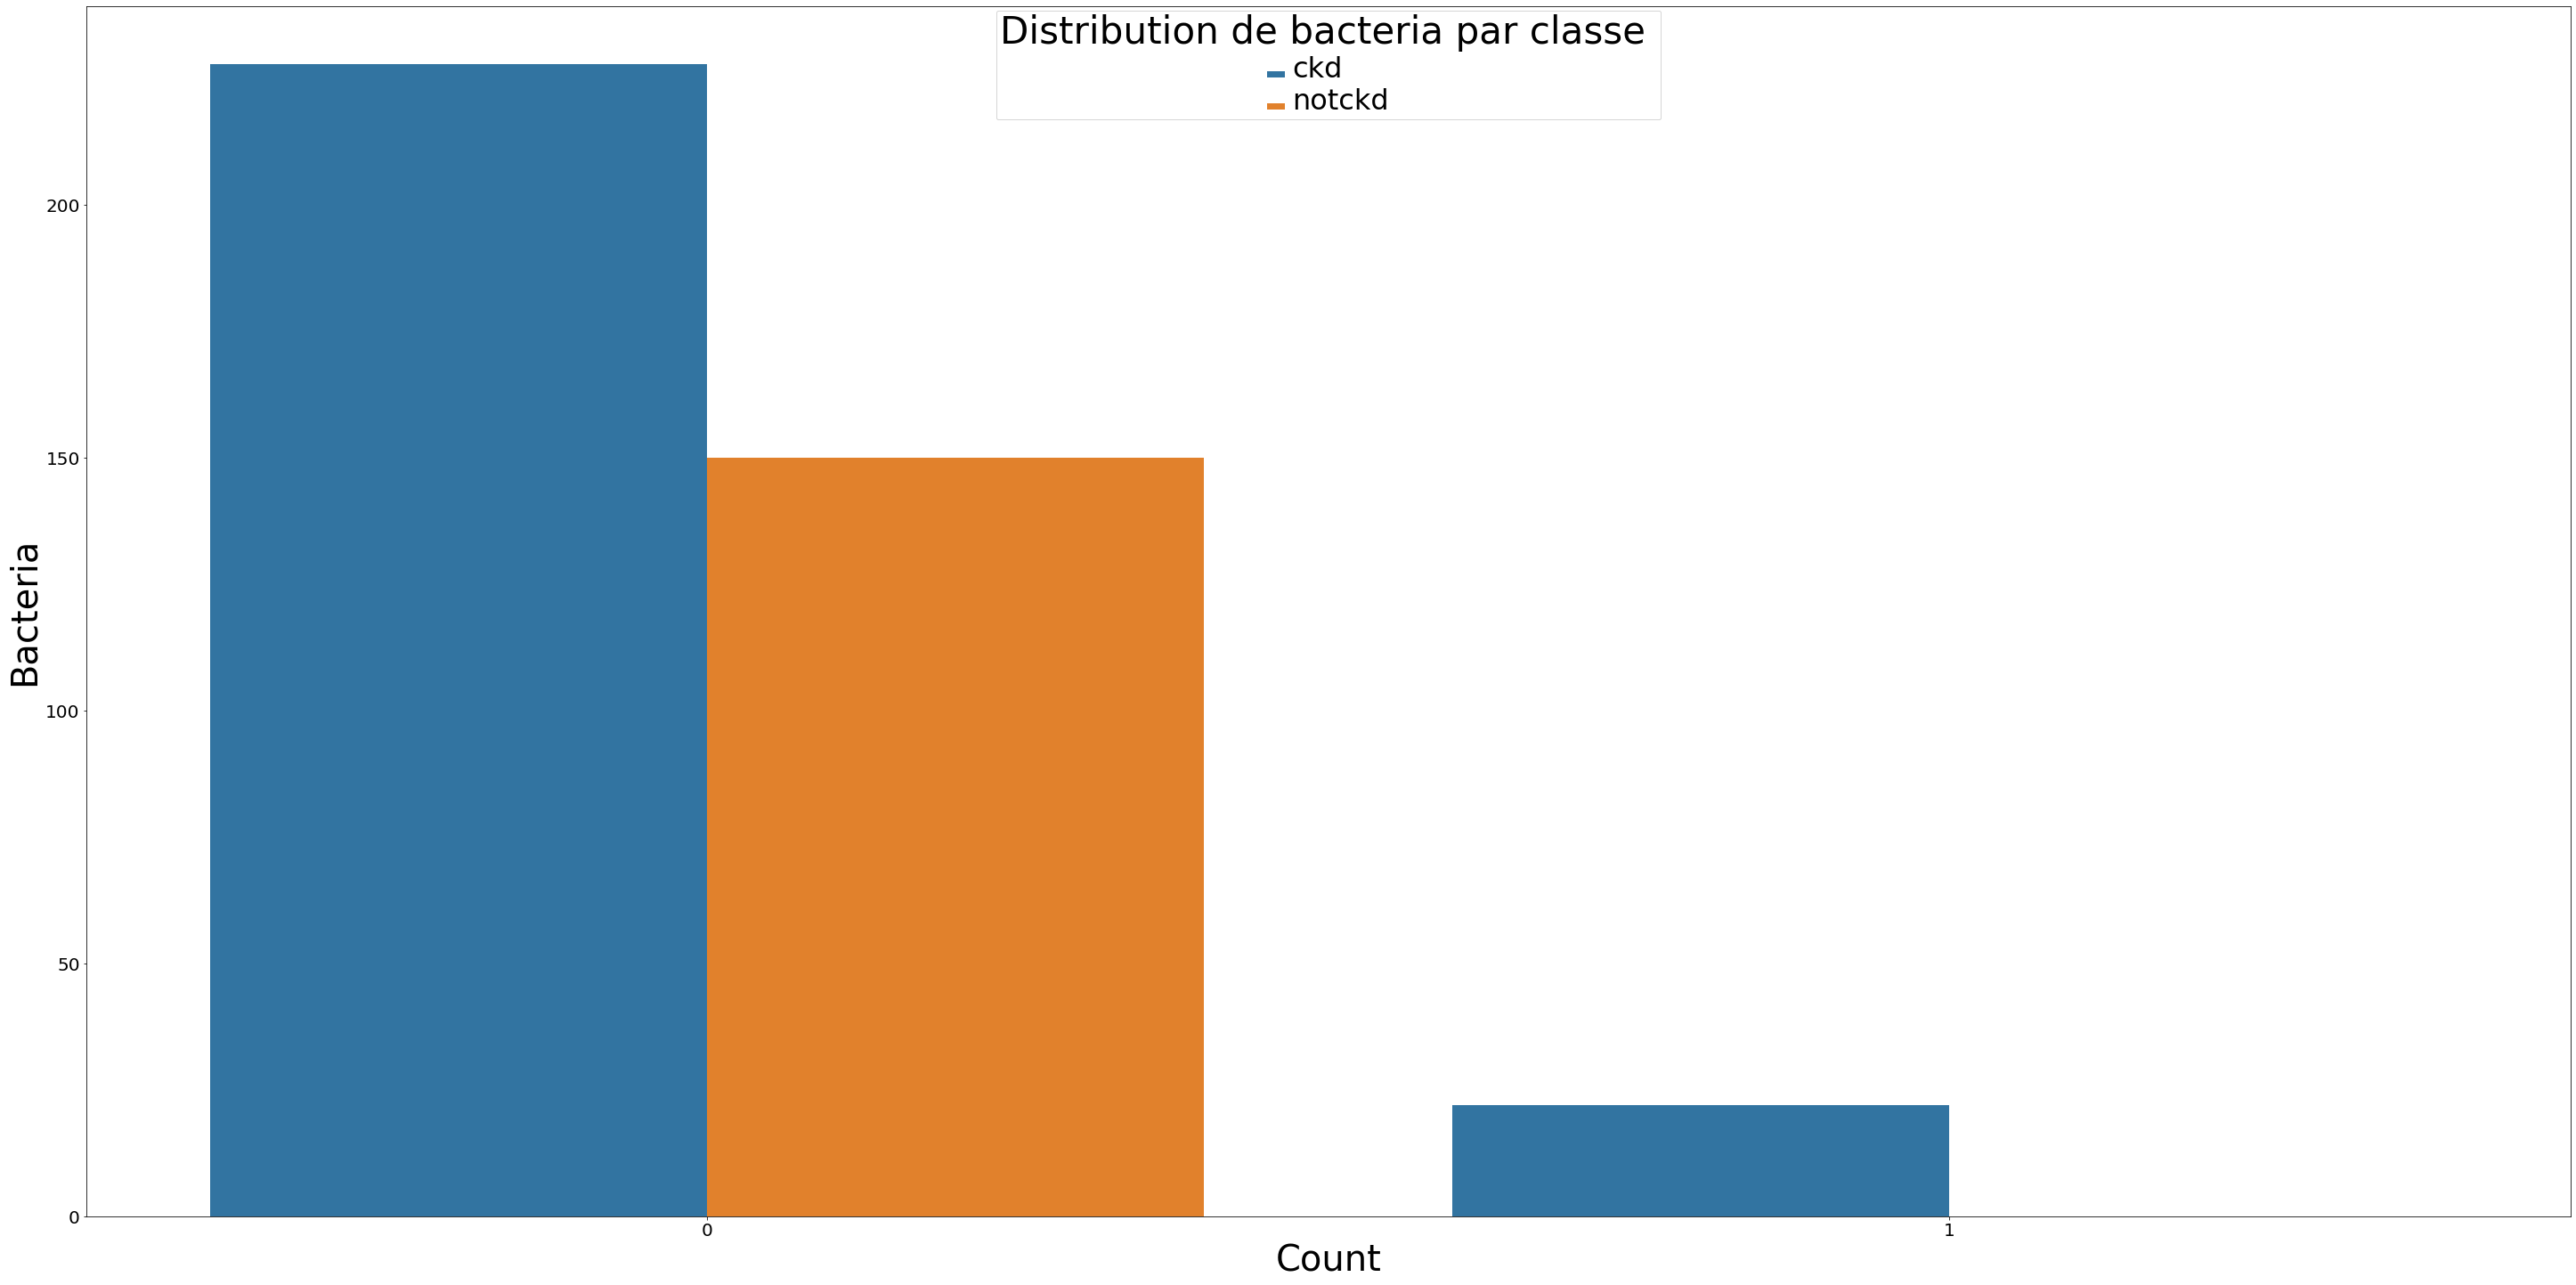

In [51]:
currentVariable='ba'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de bacteria par classe ","Bacteria")

Valeur nominale, nous effectuons une opération similaire cette fois ci avec le test de barnard_exact :

In [52]:
cont = pd.crosstab(CKD_dataframe["ba"],CKD_dataframe["class"])
scipy.stats.barnard_exact(cont)

BarnardExactResult(statistic=-3.737412737209251, pvalue=0.0001848872136221247)

l'hypothèse de départ étant le fait qu'il n'ya pas de relation entre la bactérie et le fait que le patient ait une insufisance rénale, la p-value étant fixé dans nos expérimentation a (0.005) calculé démontre le contraire avec une valeur de 0.00022774966995459675. La corrélation entre ces deux valeur existe 

Pour en avoir le coeur net, nous lançons plus d'investigation avec le graphique en violon

In [53]:
PlottingFunctions.violin(CKD_dataframe,'ba')

Très peu de patient qui dispose de CKD ont une attaque en bactérie or plusieurs patient CKD et non CKD n'ont pas d'attaque de bactérie. De ce fait, je pense qu'il serai plus lucide de dire que la corrélation est très faible 

### Relation entre le Blood Glucose Random (bgr) in mgs/dl cell clumps et le fait d'avoir ou pas une insuffisance rénale (+)

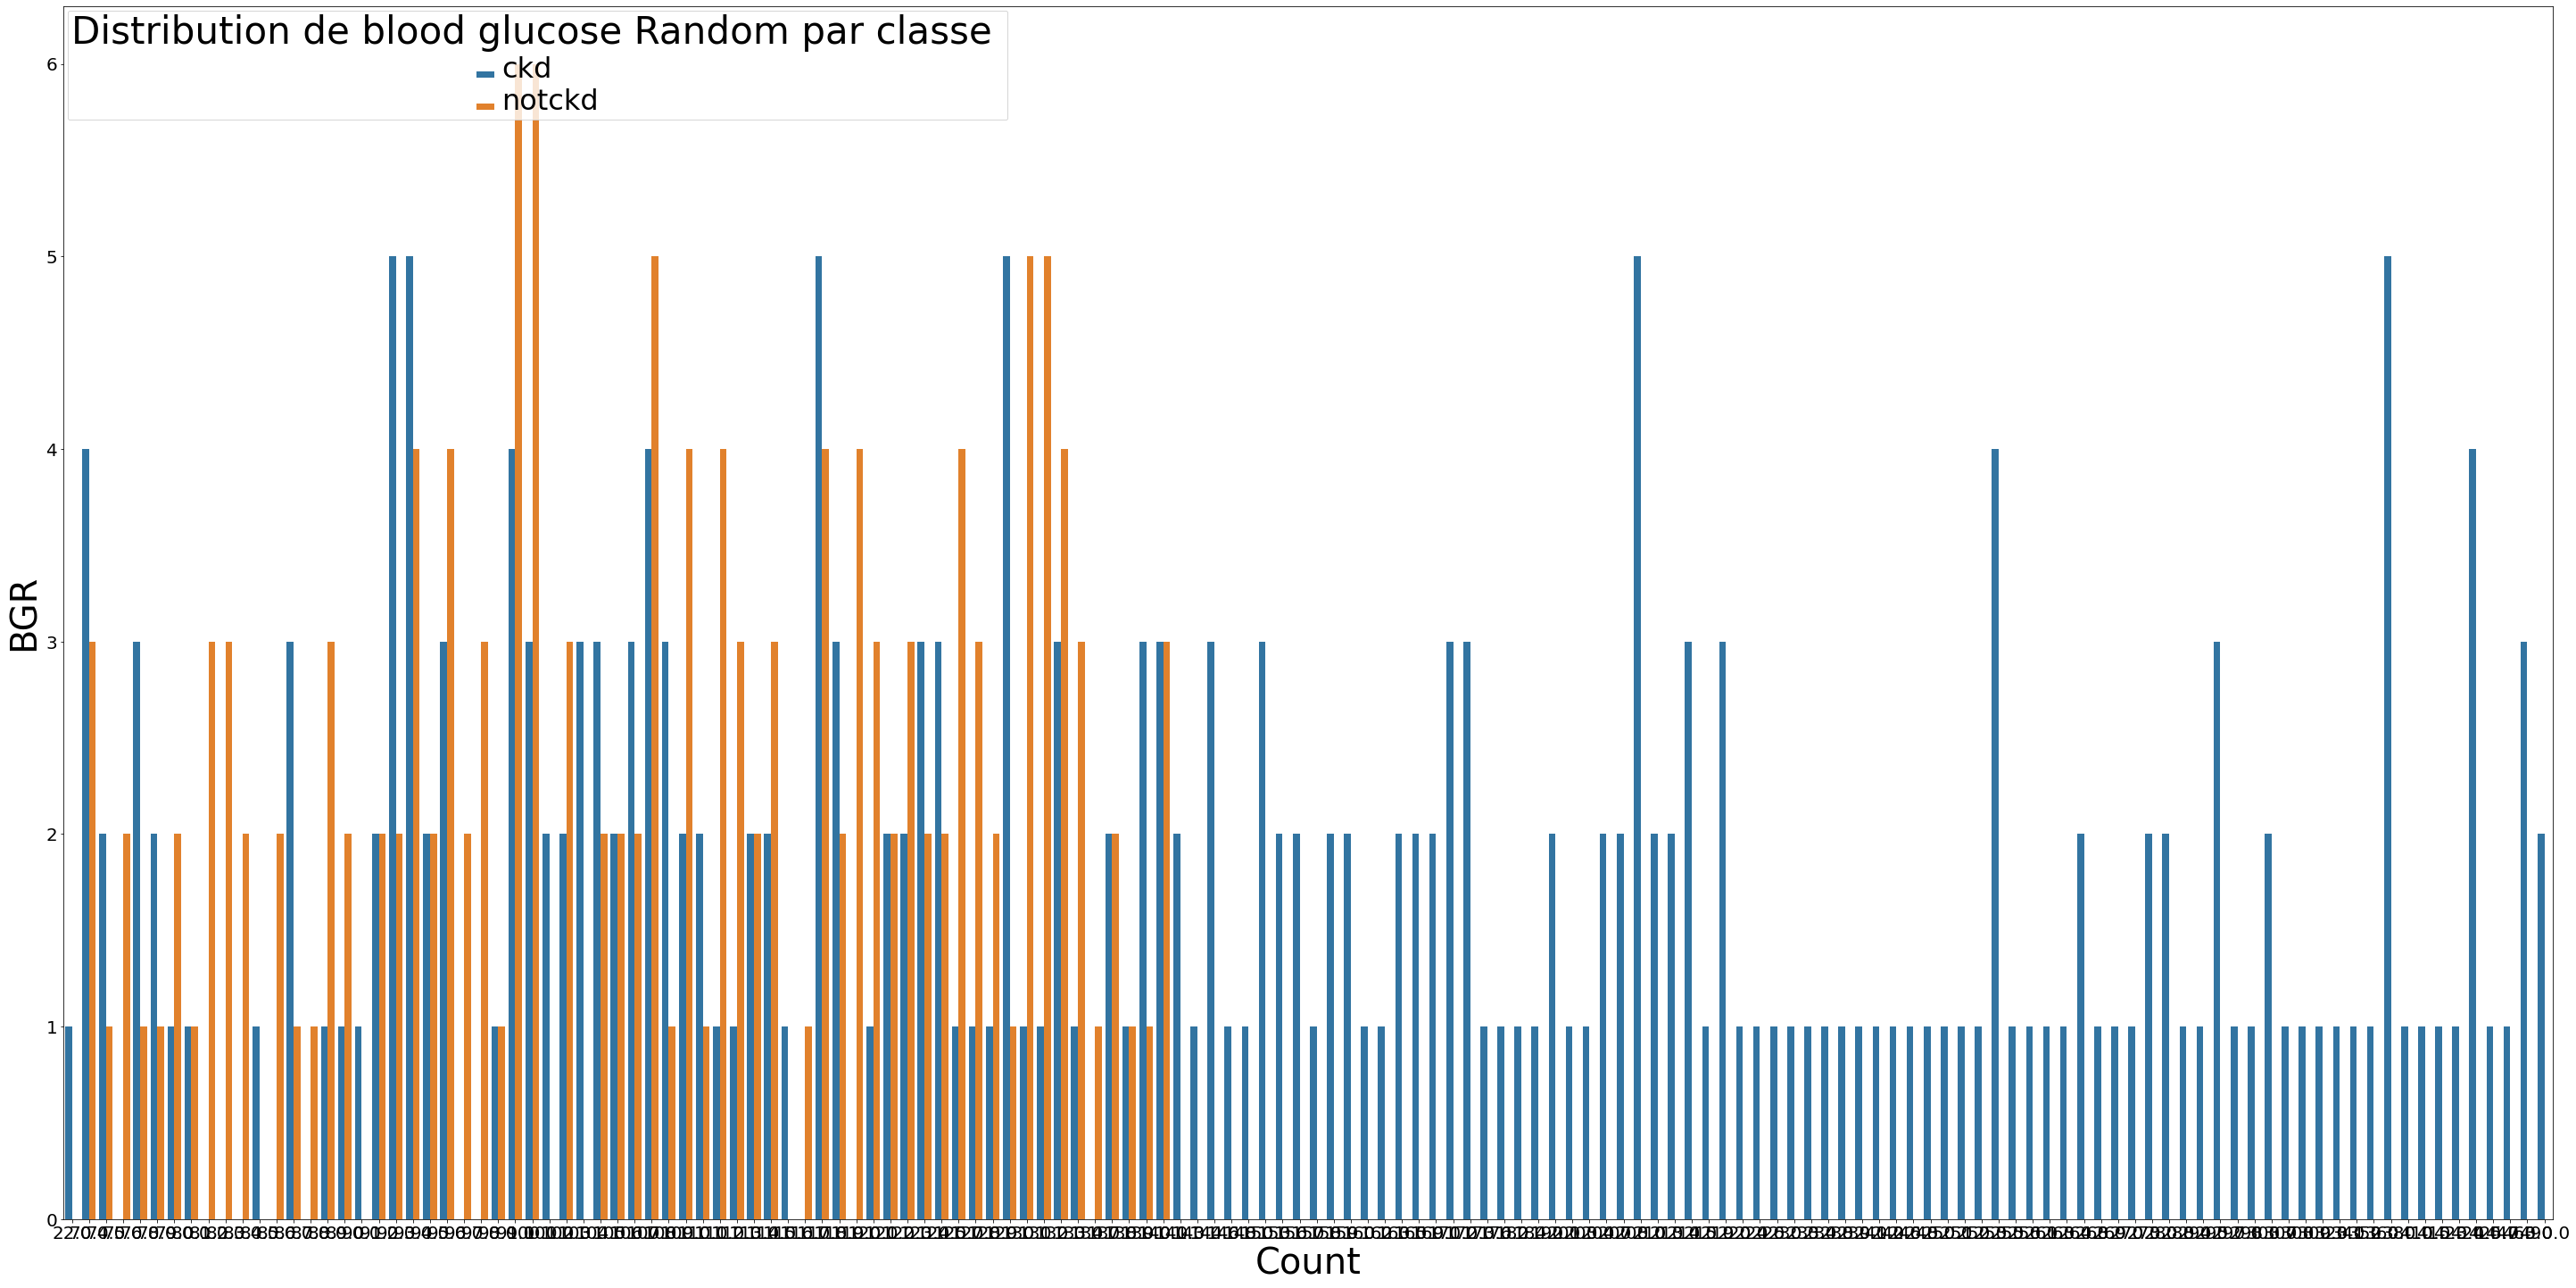

In [129]:
currentVariable='bgr'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de blood glucose Random par classe ","BGR")

In [130]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

bgr    count
bgr    1.00000 -0.21926
count -0.21926  1.00000

Un peu plus d'investigation ... 

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

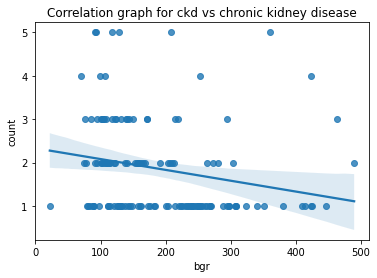

In [131]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby([currentVariable]).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = currentVariable, y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Nous remarquons qu'il existe une faible corrélation négative entre ces deux variable, les patient ckd et le bgr(blood glucose random). Pour une meilleure visualisation, voyons le violin graphe.

In [132]:
PlottingFunctions.violin(CKD_dataframe,'bgr')

Le graphique suivant nous montre que les patient CKD dispose d'un problème de glucose dans le sang. Les patient non ckd n'ont pas ce problème. Toutefois, ceci n'est vrai que pour cette distribution. Il n'est pas impossible de trouver des patient qui ont une concentration de glucose dans le sang et qui n'est pas ckd. Ceci dit, en ce qui concerne cette experimentation, je pense qu'il serait judicieux de considérer cette variable comme ayant une correlation avec la classe finale.

### Relation entre le Blood Urea (bu) et le fait d'avoir ou pas une insuffisance rénale (-)

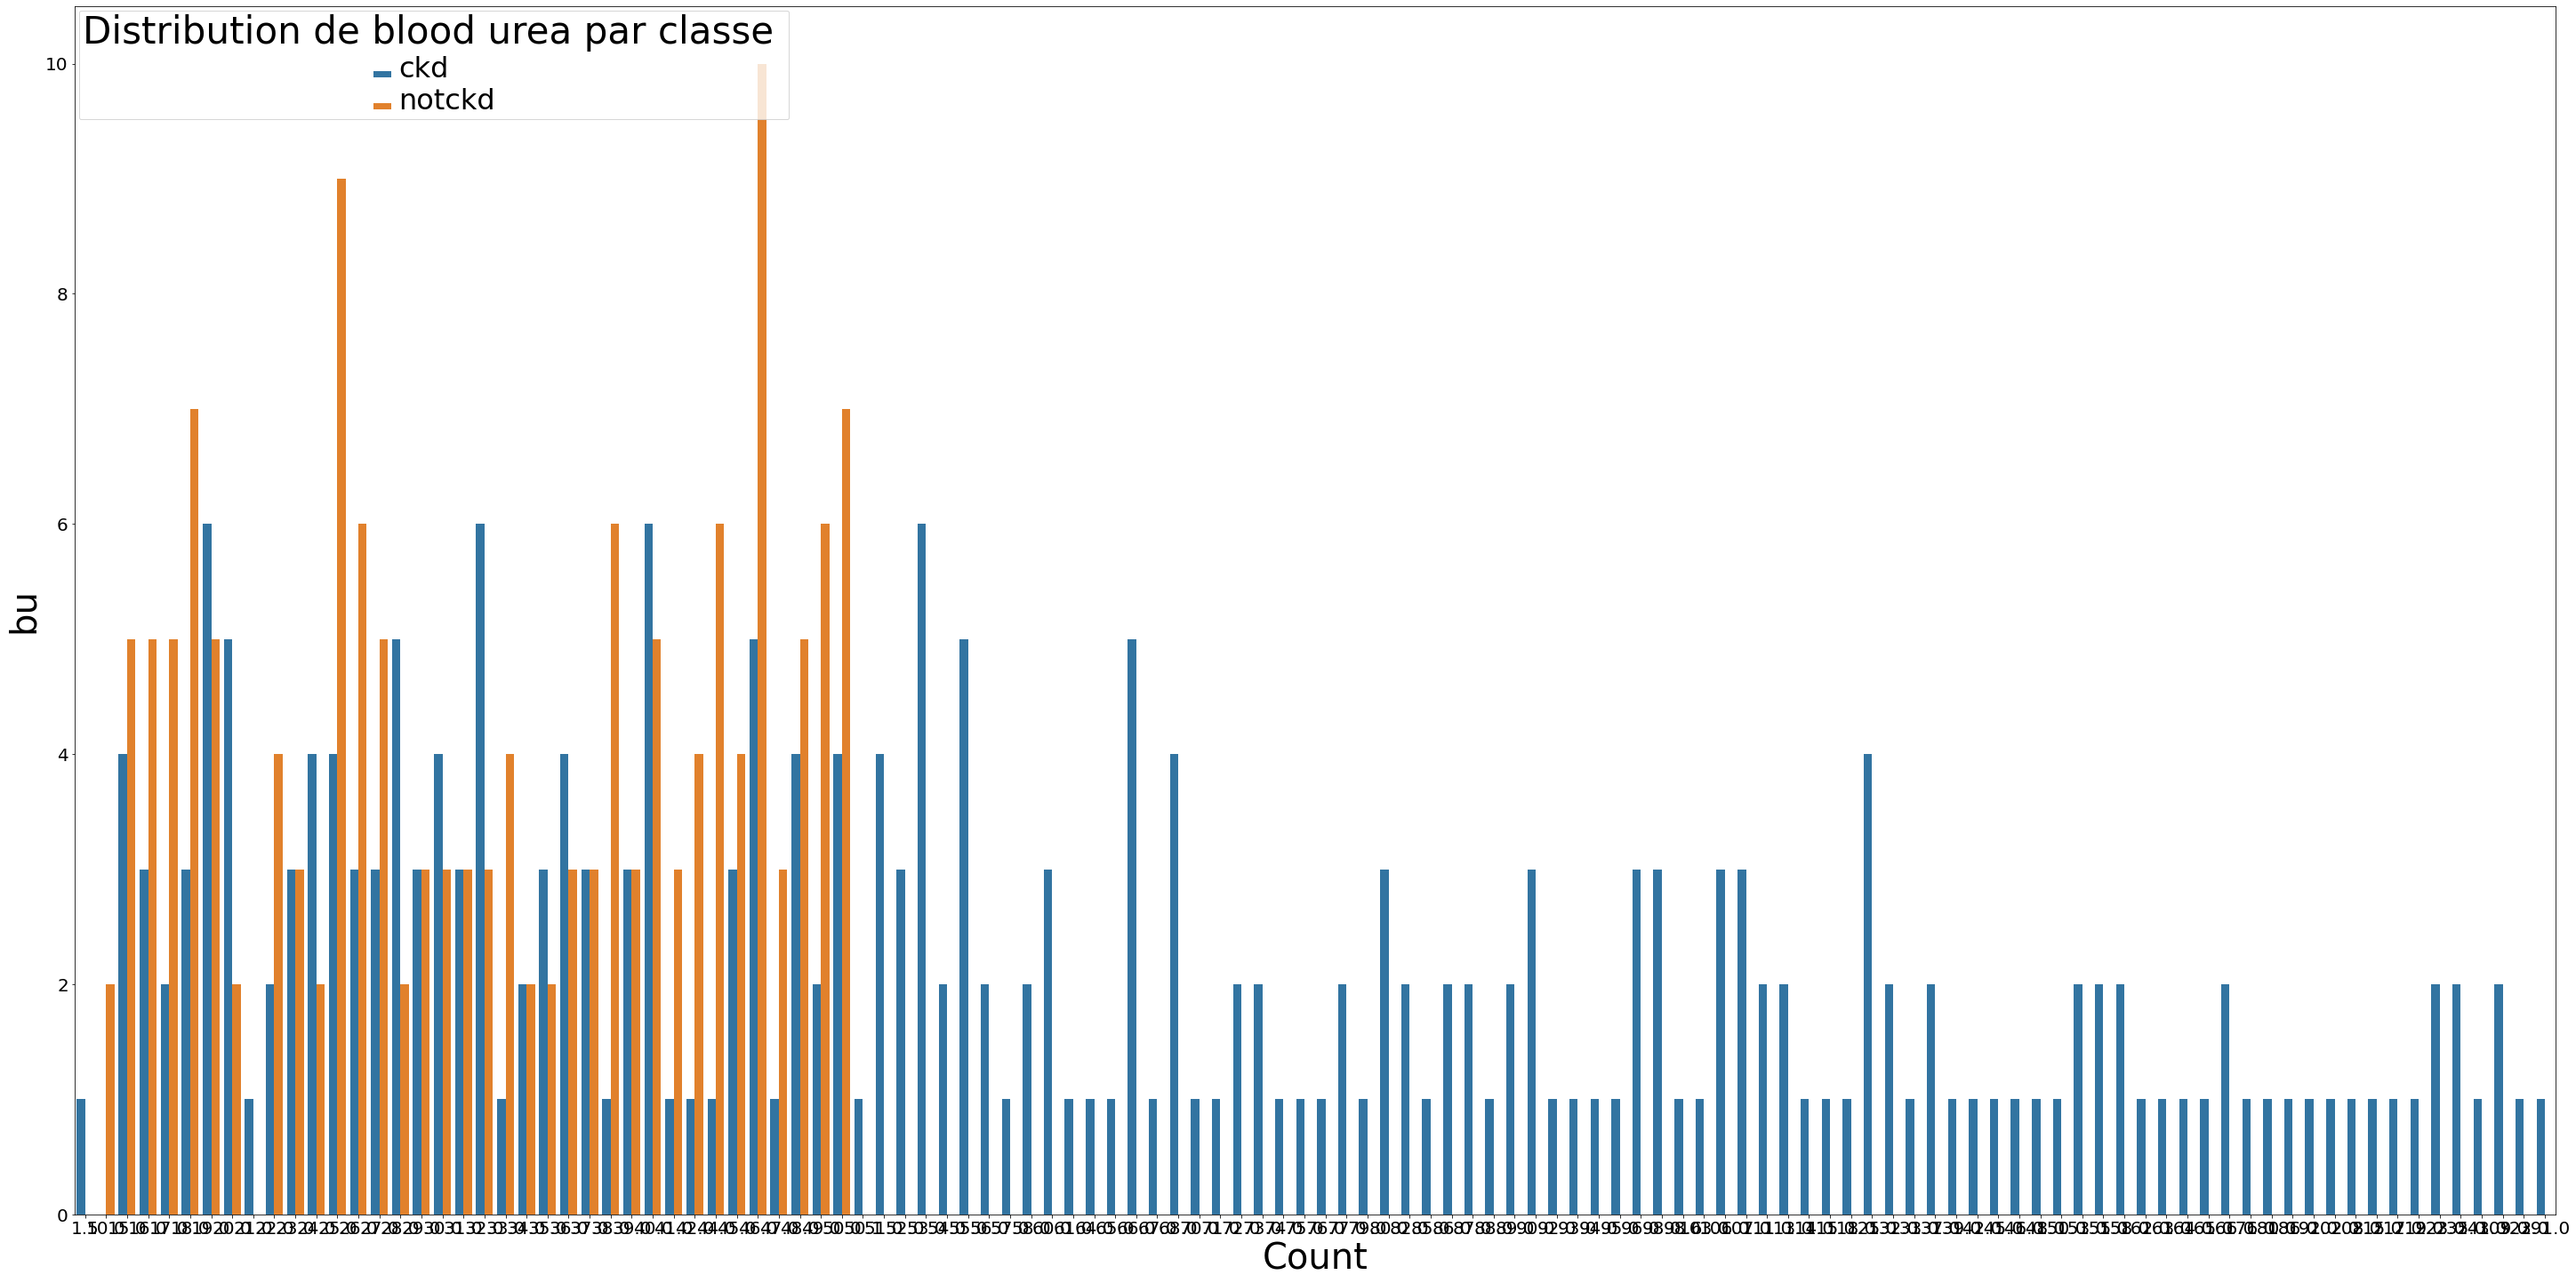

In [57]:
currentVariable='bu'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de blood urea par classe ",currentVariable)

In [58]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

bu     count
bu     1.000000 -0.437309
count -0.437309  1.000000

Il existe une corrélation négative entre les patient ayant le ckd et le Blood Urea, toutefois, relativement faible comme le confirme le graphique ci-après.

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

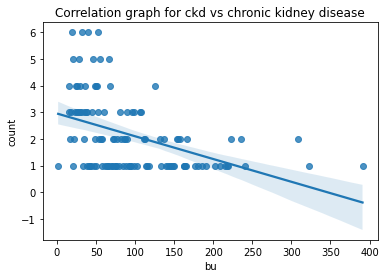

In [59]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby([currentVariable]).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = currentVariable, y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

In [61]:
PlottingFunctions.violin(CKD_dataframe,'bu')

Sur ce graphique, nous remarquons que plusieurs de patient CKD et pas CKD ont un blood urea inverieur a 100, peu de patient on une bu superieur a 100. Ceci ne nous met pas dans une situation ideale pour déterminer une correlation certaine entre la BU et le fait d'avoir la CKD.

### Relation entre le Serum Creatinine(sc) et le fait d'avoir ou pas une insuffisance rénale (+)

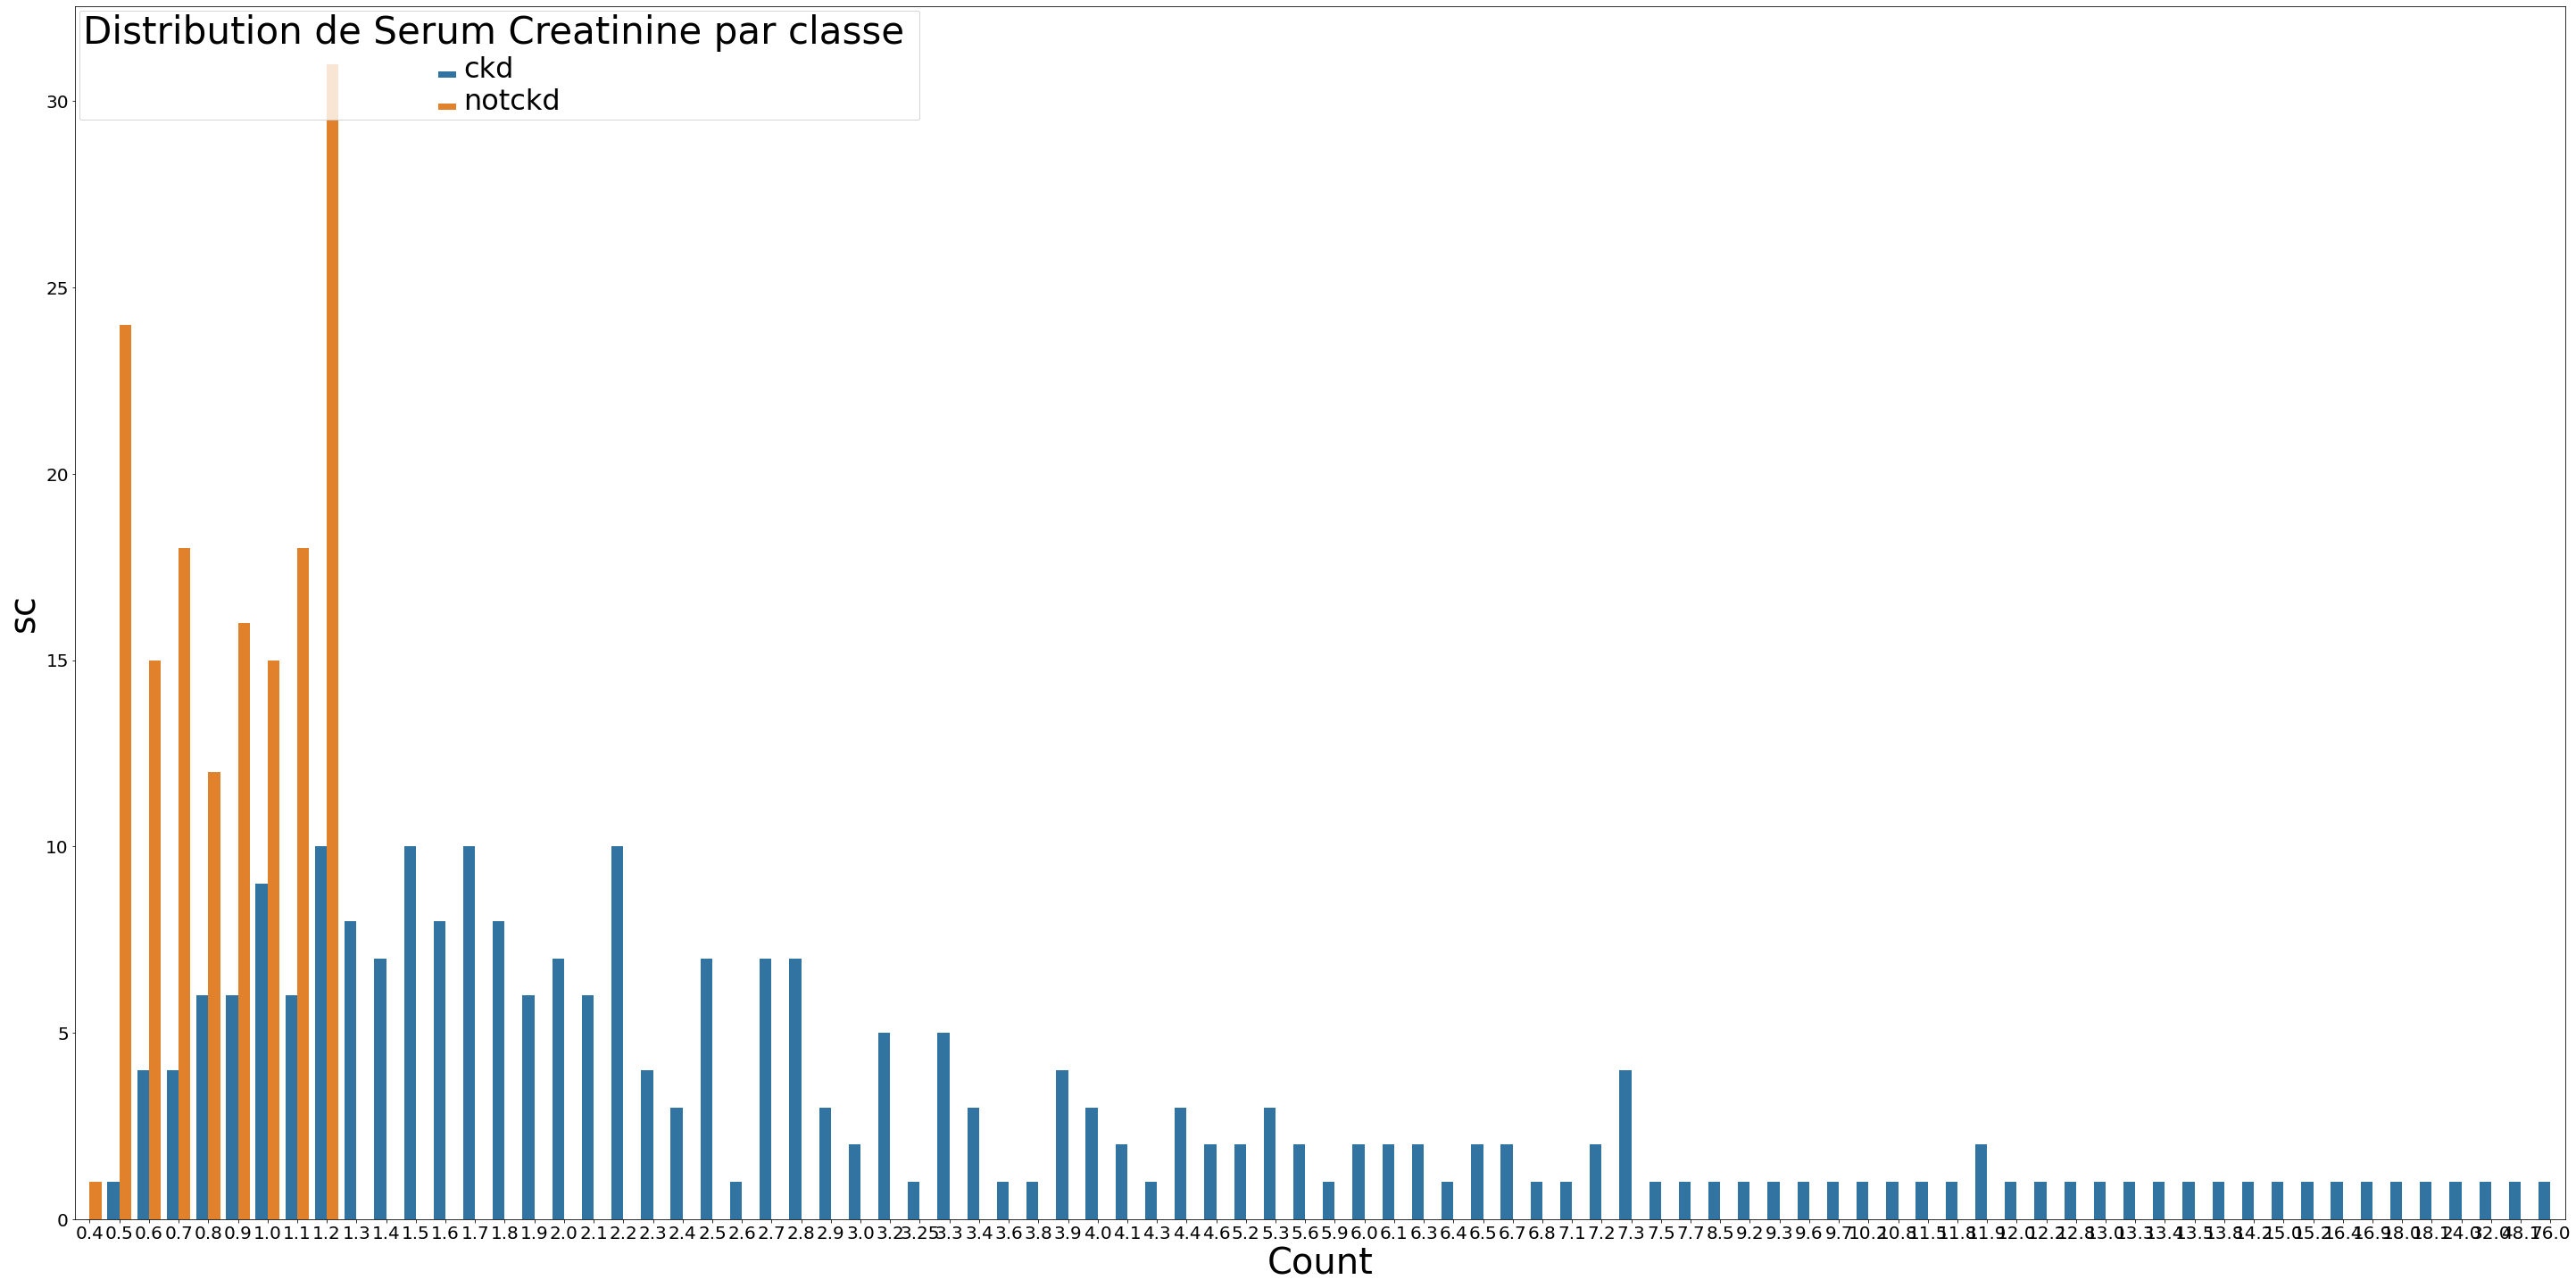

In [63]:
currentVariable='sc'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de Serum Creatinine par classe ",currentVariable)

In [62]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

bu     count
bu     1.000000 -0.437309
count -0.437309  1.000000

situaltion similaire que la précédente variable, les données dans la deuxième moitiée est quasi inéxistante, ce qui ne nous permet pas de trancher de manière ferme le fait qu'une corrélation existe. Nous poussons les investigations ... 

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

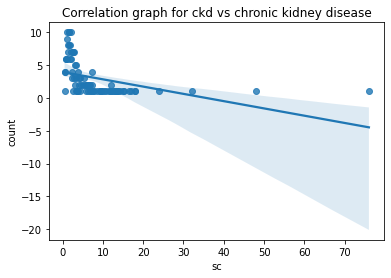

In [64]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby(['sc']).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = 'sc', y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

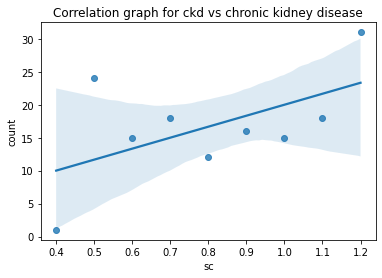

In [65]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'notckd'].groupby(['sc']).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = 'sc', y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Voyant que la relations pour les patients atteint de CKD est minime, nous estimons que la corrélation négative est limitée.

### Relation entre le Sodium (sod) et le fait d'avoir ou pas une insuffisance rénale (-)

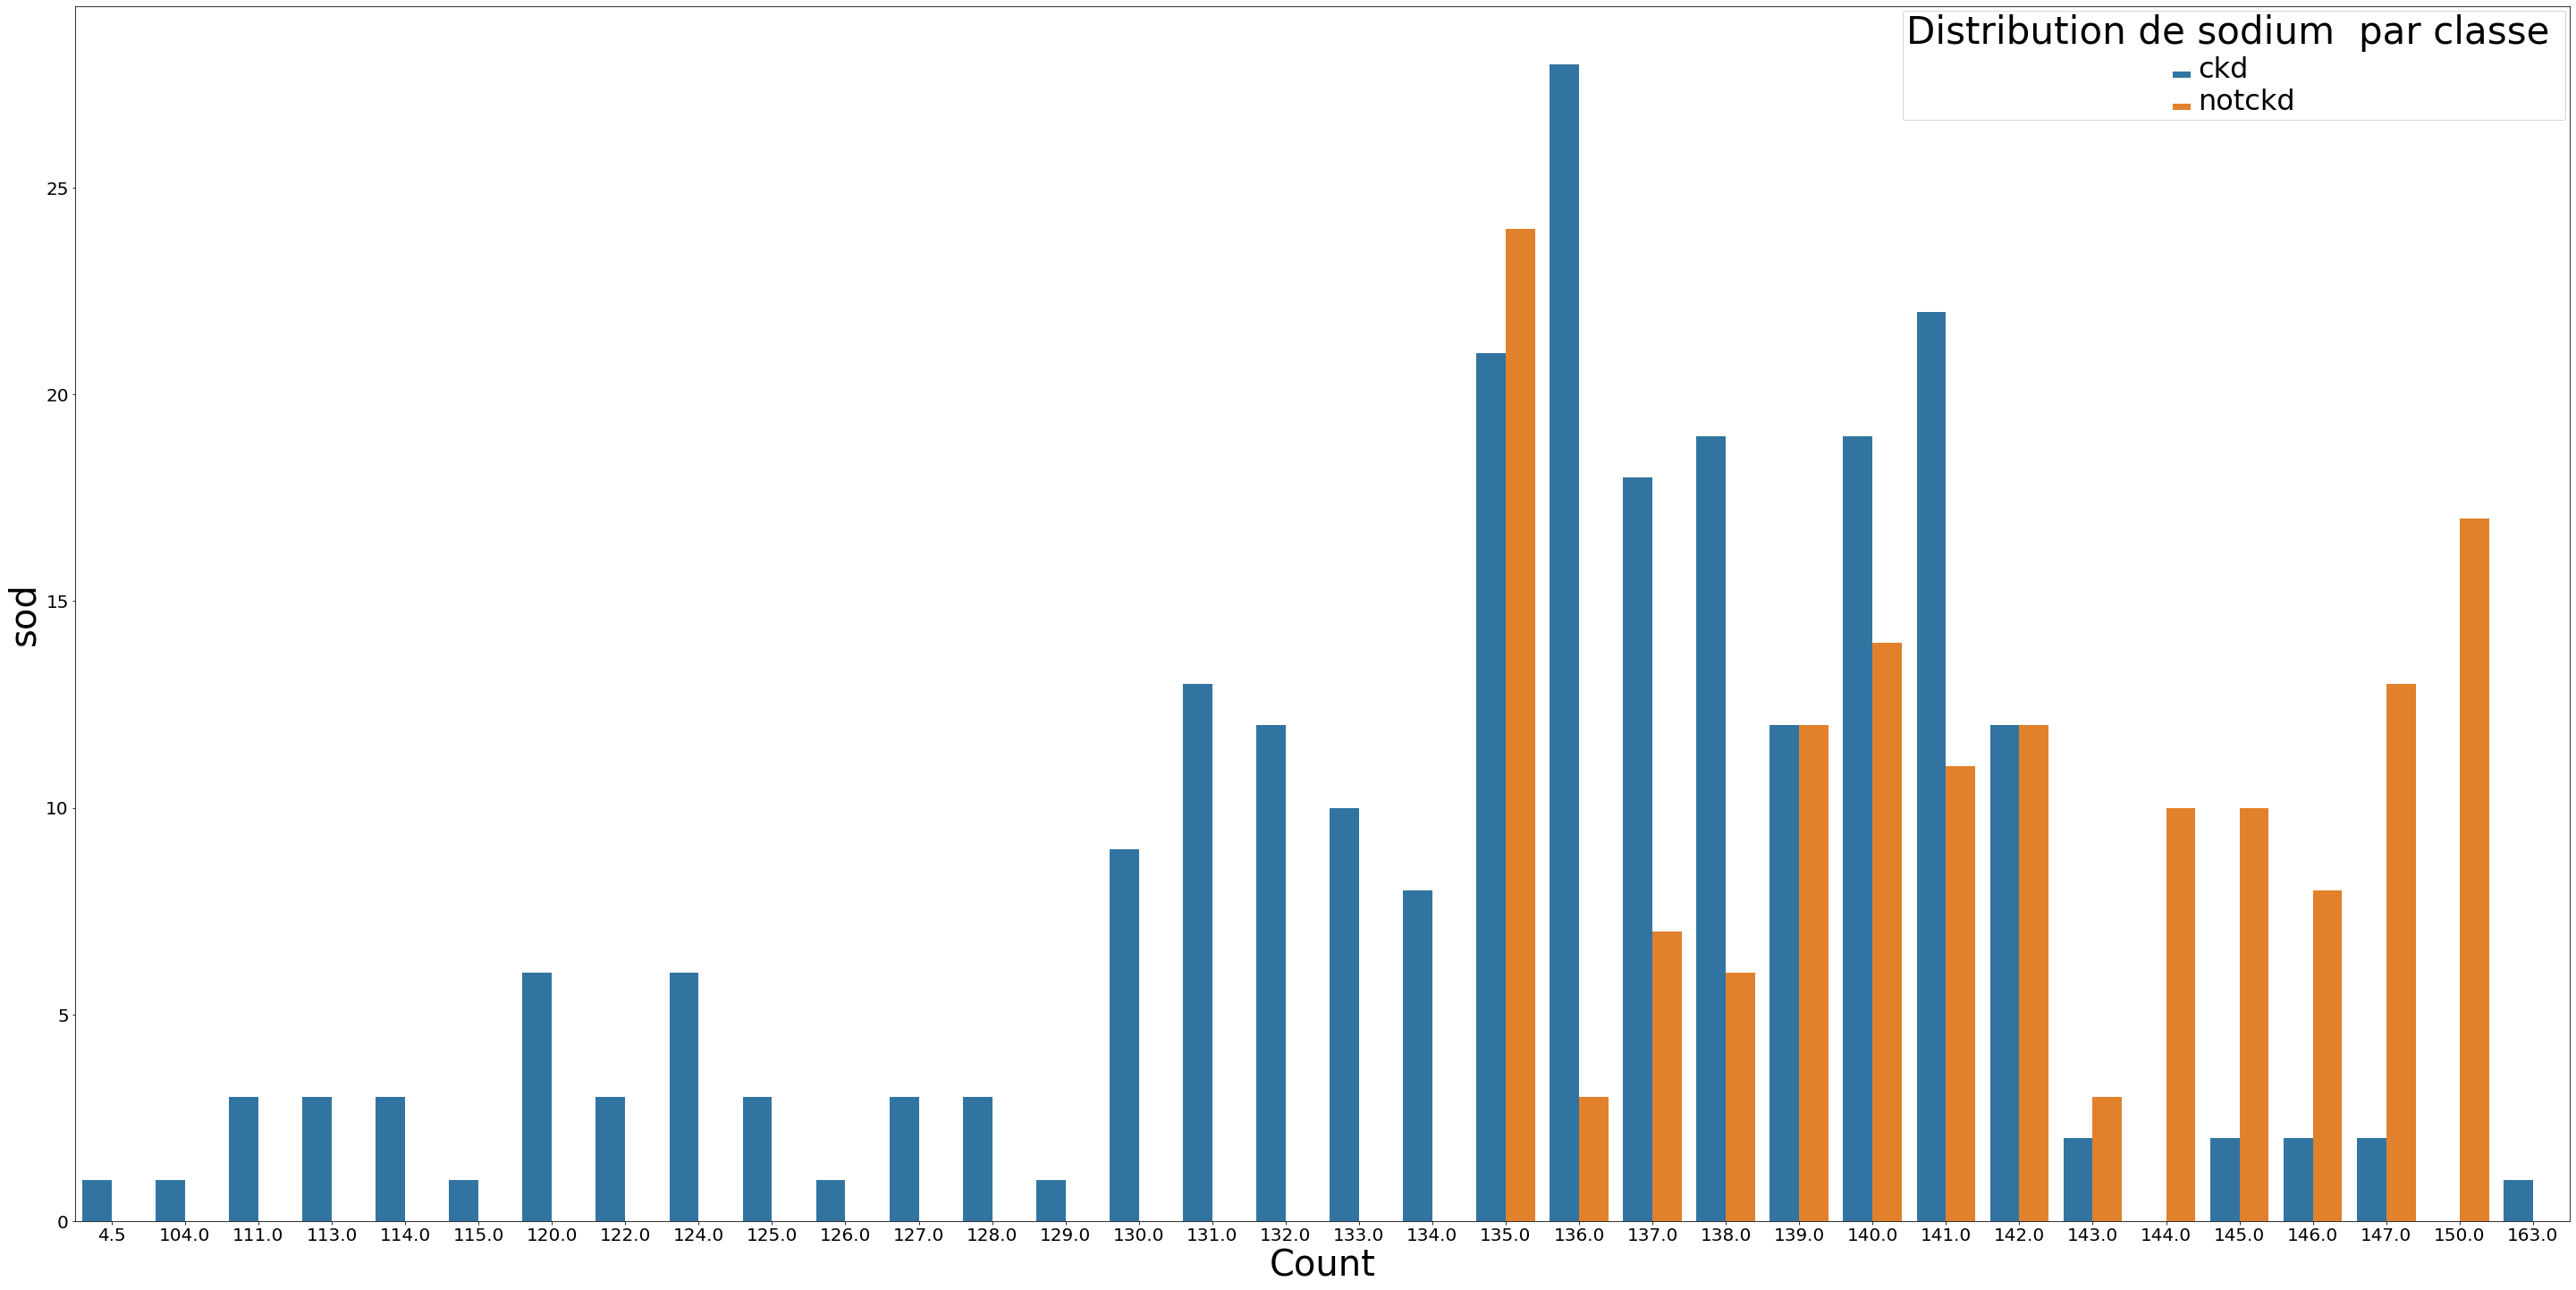

In [66]:
currentVariable='sod'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de sodium  par classe ",currentVariable)

In [67]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

sod     count
sod    1.000000  0.277721
count  0.277721  1.000000

Il existe une corrélation positive faible entre les deux variable comme le montre la valeur :0.28, le graphique suivant peut nous donner plus de détails : 

In [68]:
PlottingFunctions.violin(CKD_dataframe,'sod')

Nous remarquons que peu de patients CKD ont une concentration de sodium inferieur a la normale. De ce fait, tirer la conclusion qu'il existe une corrélation entre le CKD et le sodium serait très difficile a faire.

### Relation entre le Potassium (pot) et le fait d'avoir ou pas une insuffisance rénale (-)

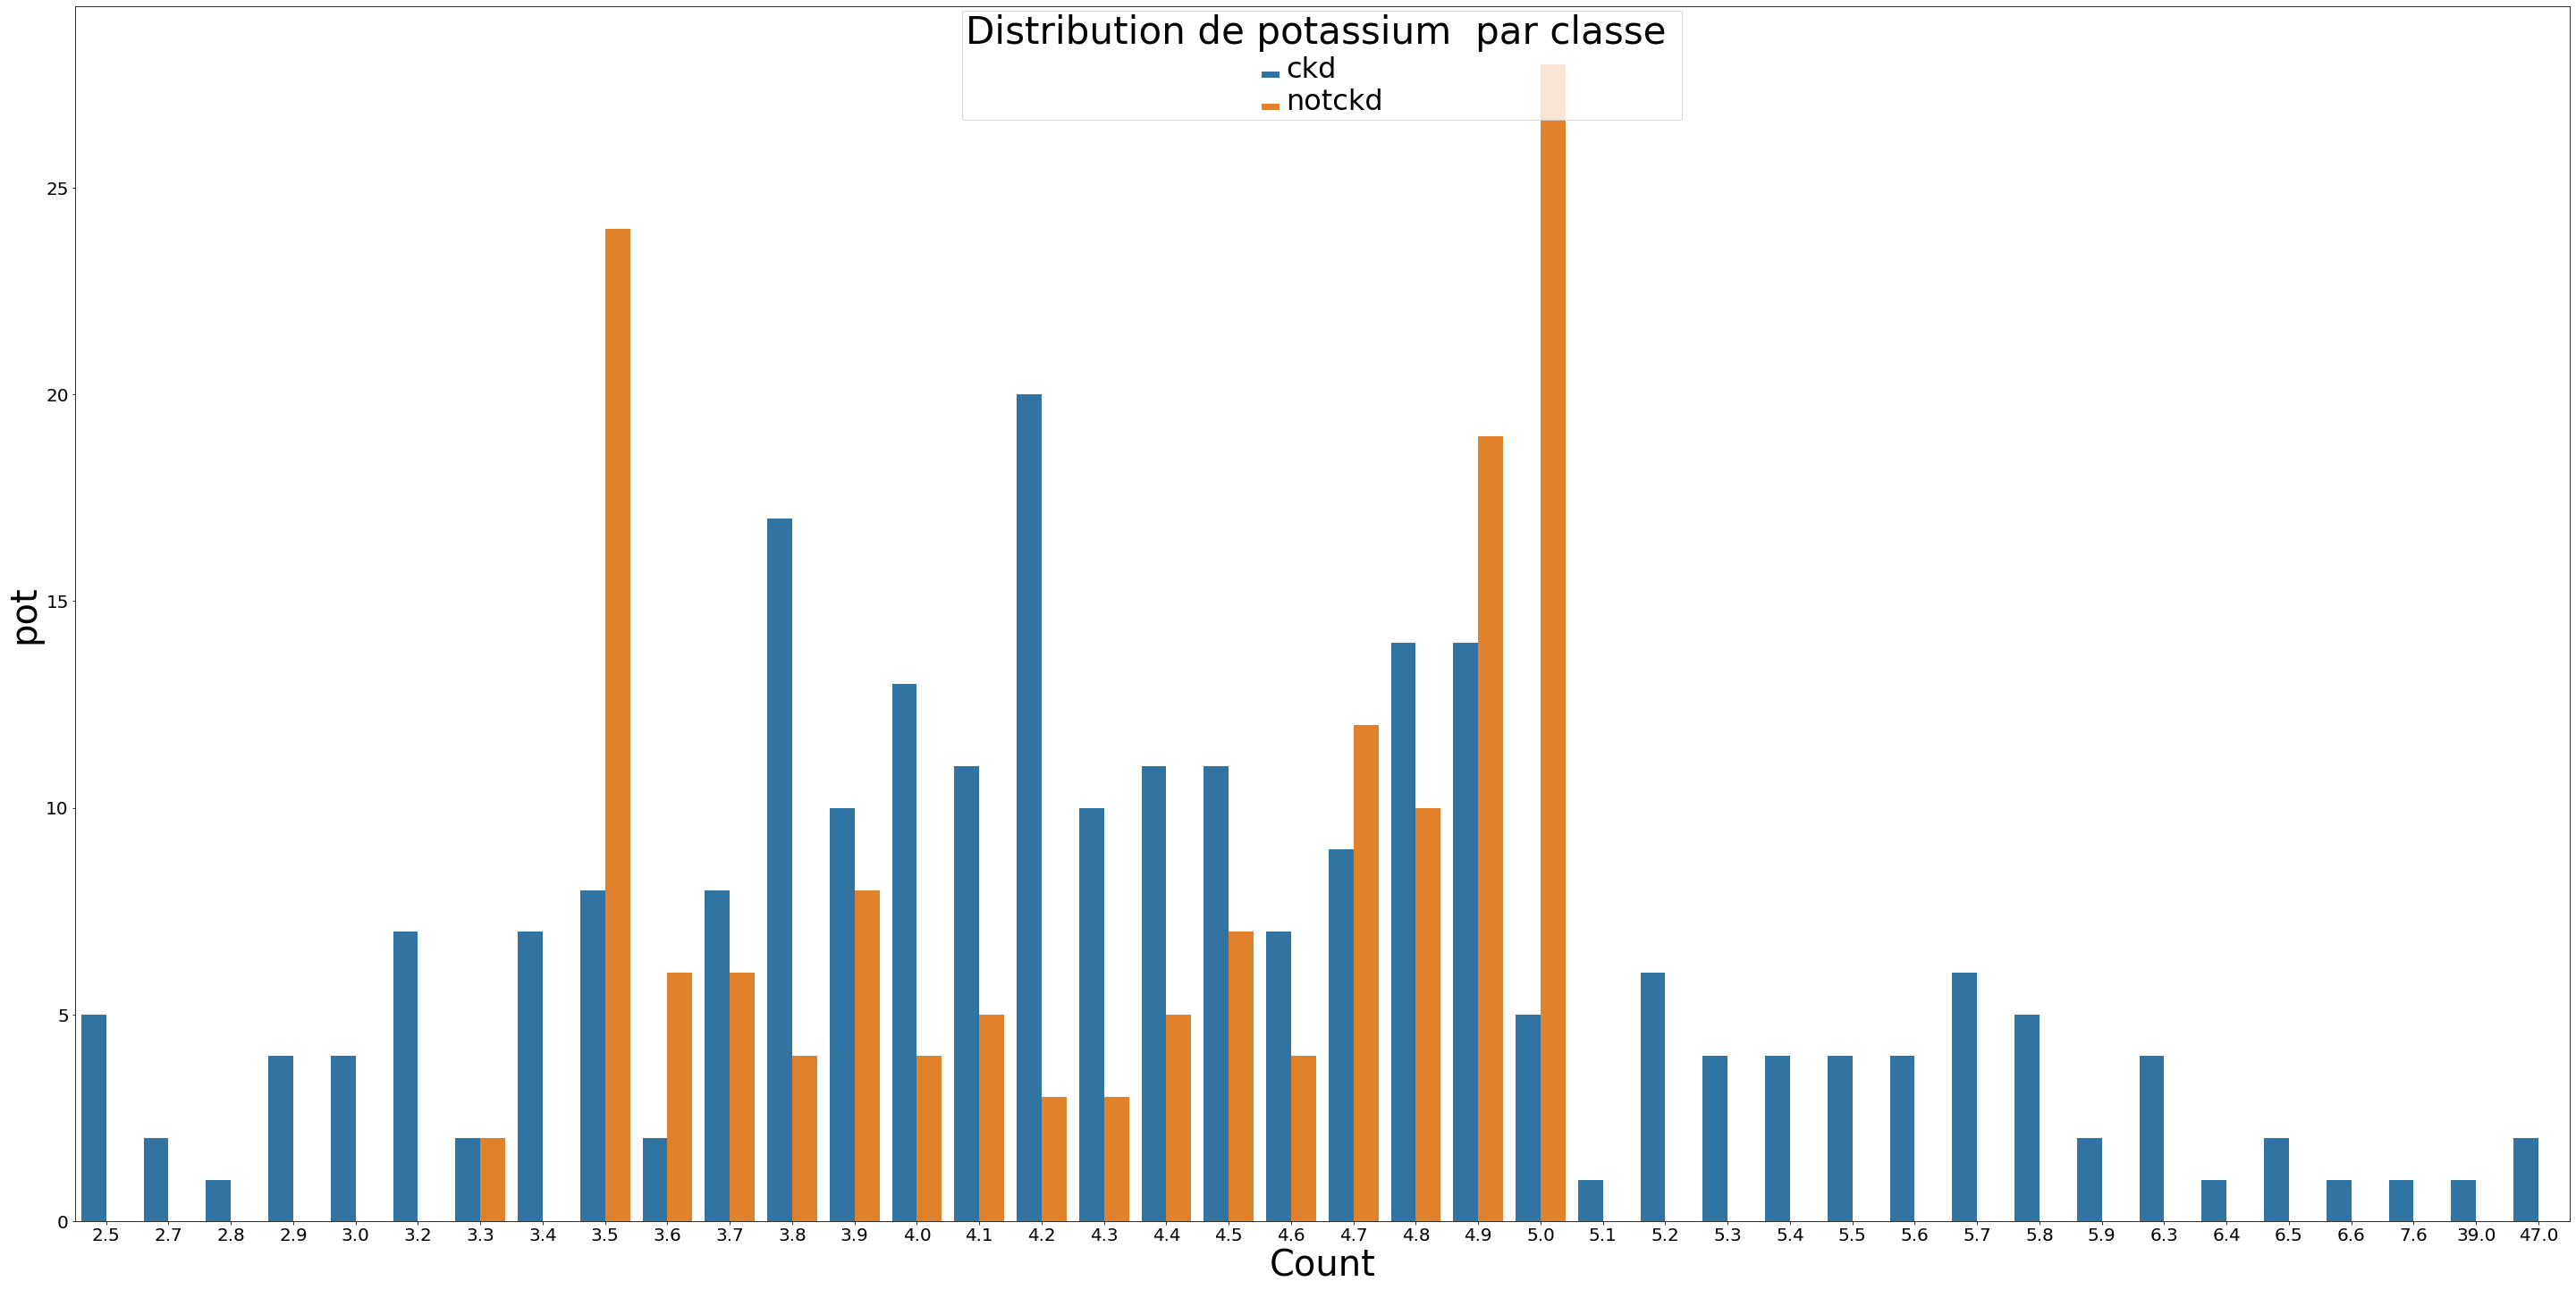

In [71]:
currentVariable='pot'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de potassium  par classe ",currentVariable)

In [72]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

pot     count
pot    1.000000 -0.258679
count -0.258679  1.000000

comme la variable précédente, la corrélation est assez faible, le graphique le montre aussi 

In [74]:
PlottingFunctions.violin(CKD_dataframe, currentVariable)

Trop peu de patient CKD qui ont une valeur de potatium superieur a 10 pour tirer une conclusion qu'il existe une corrélation entre ces deux variable. Malgré l'hypothèse initlale tiré a partir de recherches bibliographiques.

### Relation entre le Hemoglobin (hemo) et le fait d'avoir ou pas une insuffisance rénale (+)

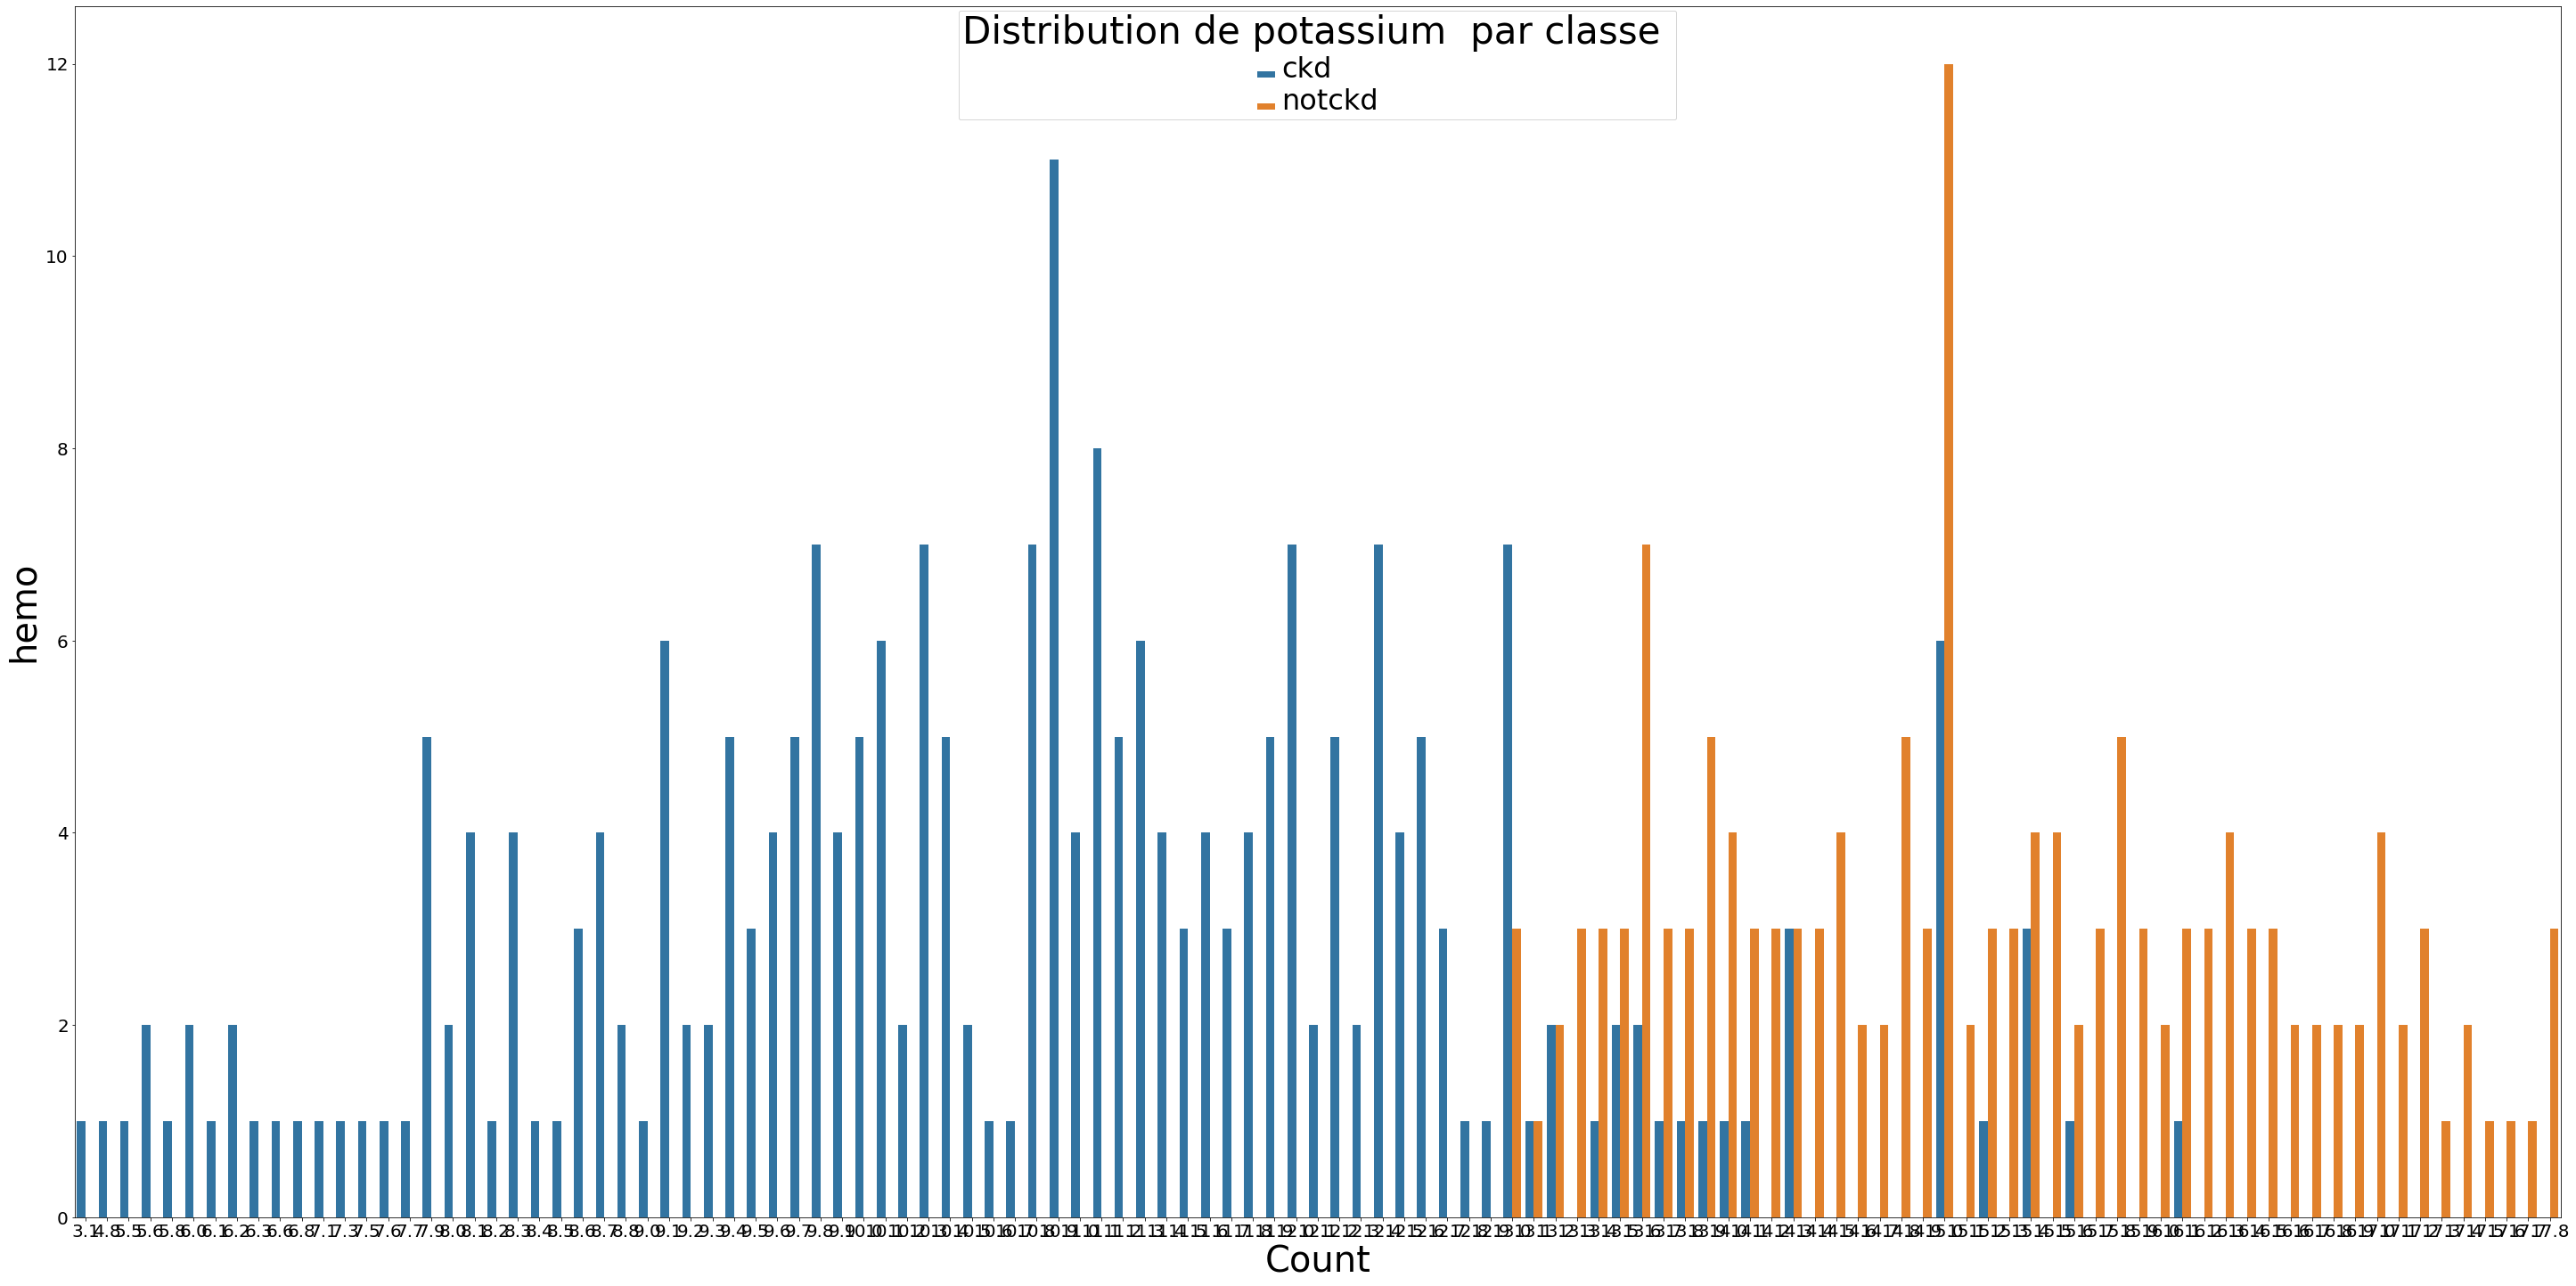

In [84]:
currentVariable='hemo'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de potassium  par classe ",currentVariable)

In [85]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

hemo     count
hemo   1.000000  0.163546
count  0.163546  1.000000

la corrélation est vraiment faible, toutefois, le graphique montre les choses autrement, nous allons faire encore pus d'investigation pour vérifier

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

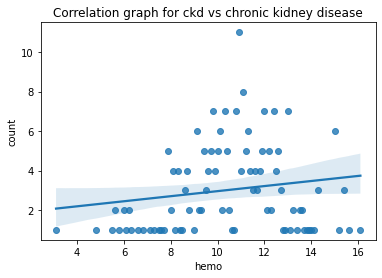

In [86]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby([currentVariable]).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = currentVariable, y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

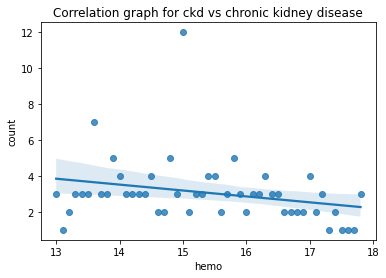

In [87]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'notckd'].groupby([currentVariable]).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = currentVariable, y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Effectivement, la distribution des patient avec CKD et sans CKD n'est pas visible dans ce graphique 

In [88]:
PlottingFunctions.violin(CKD_dataframe,'hemo')

Par rapport a ce dernier graphique, je suis très tenté de dire qu'il existe une corrélation entre ces deux variables.

### Relation entre le Packed Cell Volume (pcv) et le fait d'avoir ou pas une insuffisance rénale (+)

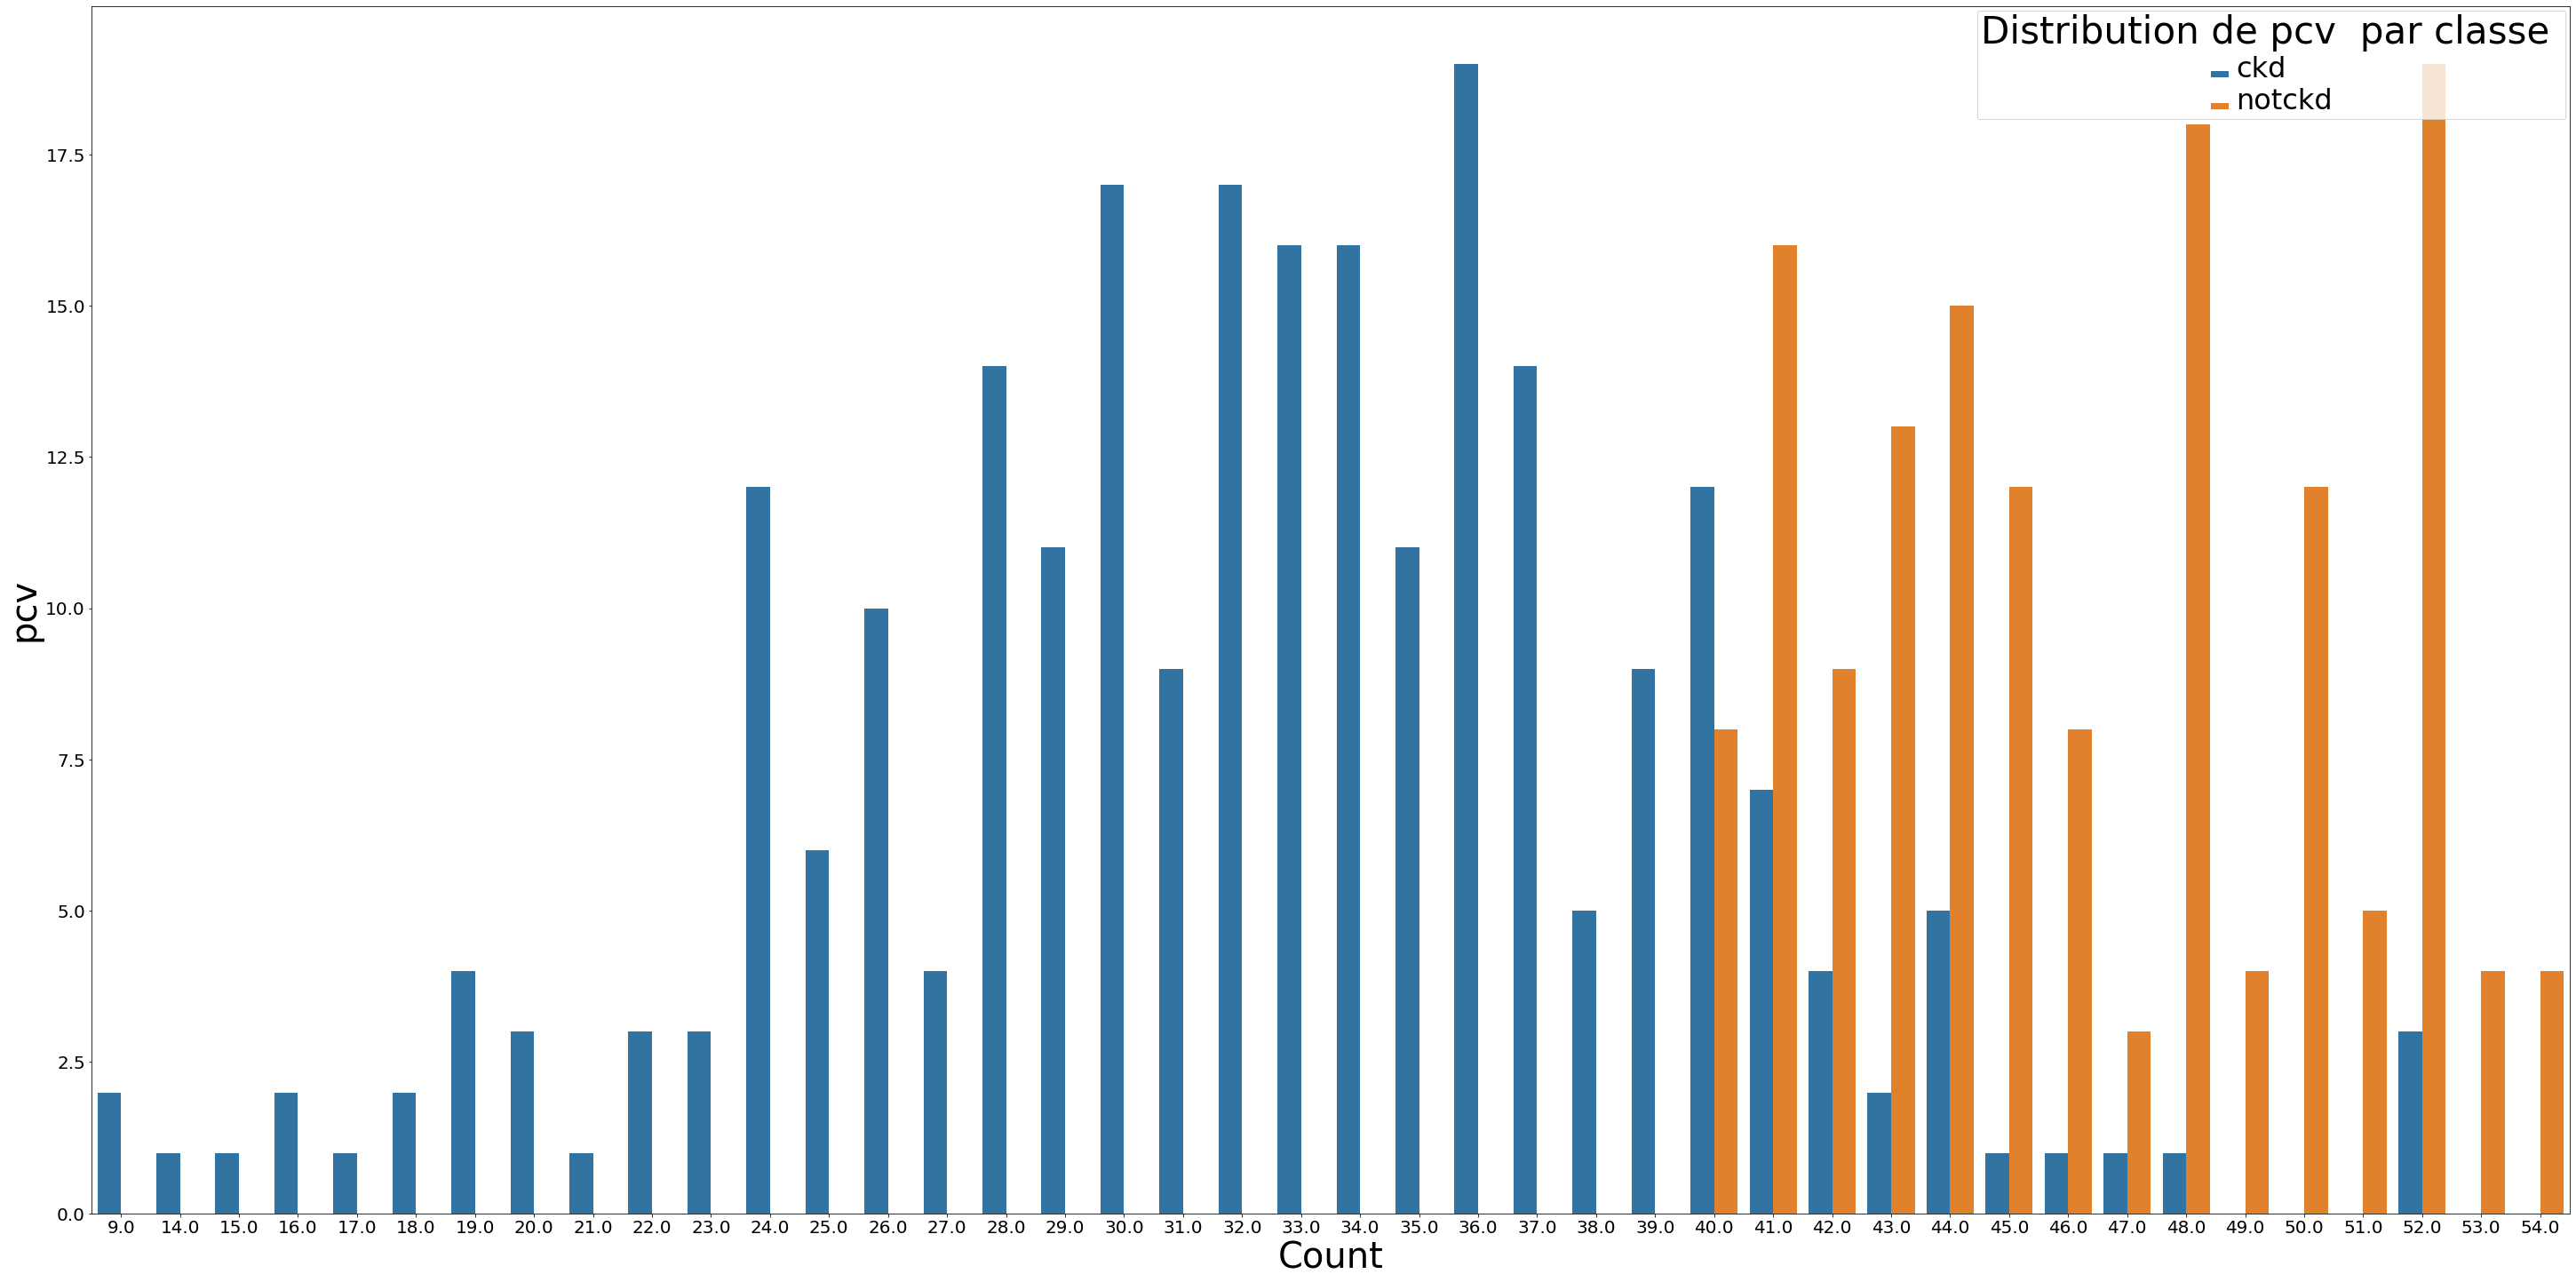

In [134]:
currentVariable='pcv'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de pcv  par classe ",currentVariable)

In [135]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

pcv     count
pcv    1.000000  0.135729
count  0.135729  1.000000

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

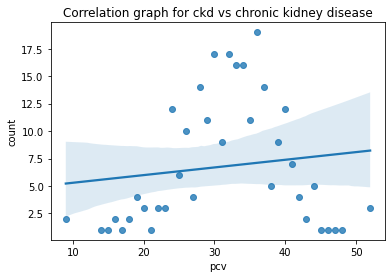

In [136]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby([currentVariable]).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = currentVariable, y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

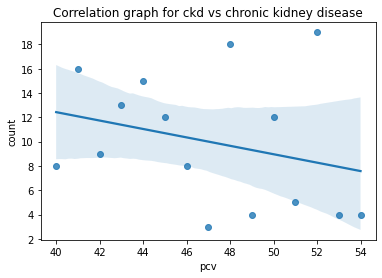

In [137]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'notckd'].groupby([currentVariable]).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = currentVariable, y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Après vérification, il est claire que la corrélation entre ces deux variable n'est pas très forte, voir inexistante. Voyons le graphique en violon pour avoir une meilleure visualisation

In [93]:
PlottingFunctions.violin(CKD_dataframe,'pcv')

Ce dernier graphique montre qu'il existe une corrélation entre ces deux variables surtout quand le pcv est inferieur a 40. Le fait que le regplot ne l'a pas forcément montré est que le nombre de patient qui disposent de ces valeurs ne sont pas assez important pour faire dégradé la droite.

### Relation entre le White Blood Cell Count (wbcc) et le fait d'avoir ou pas une insuffisance rénale (-)

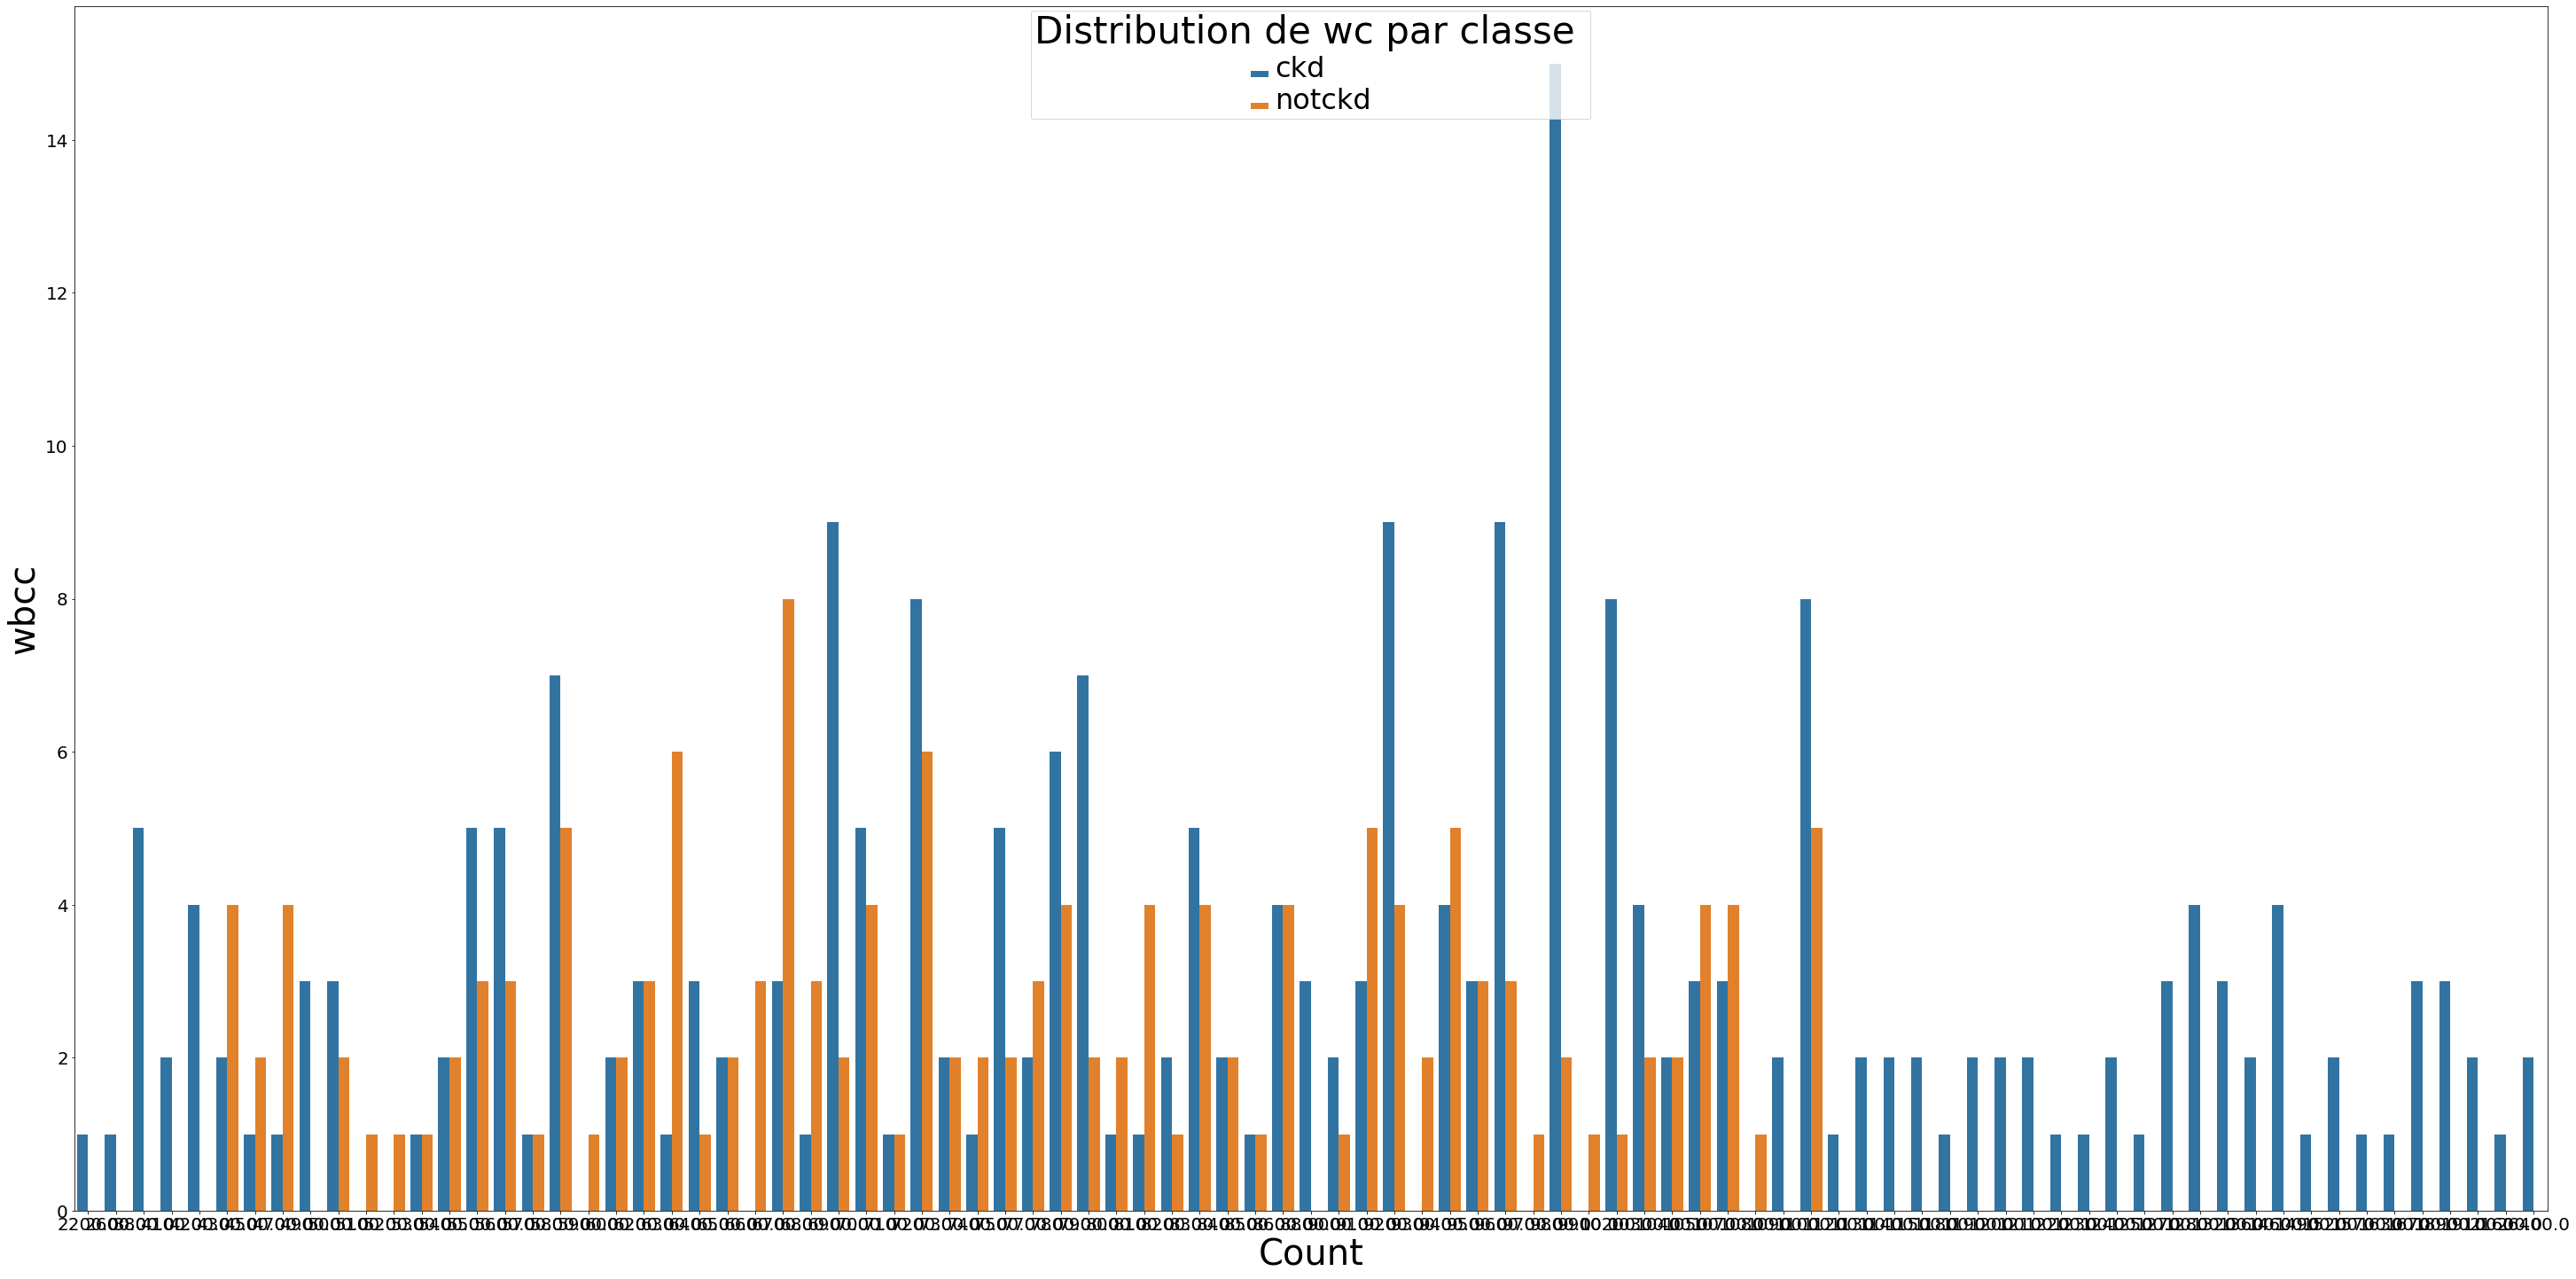

In [94]:
currentVariable='wbcc'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de wc par classe ",currentVariable)

In [95]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

wbcc     count
wbcc   1.000000 -0.110216
count -0.110216  1.000000

Très peu de corrélation pour cette variable aussi. Je m'avance sur le fait que l'infulance de cette variable sur le CKD est relativement faible.

### Relation entre le red blood cell count (rbcc) et le fait d'avoir ou pas une insuffisance rénale (-)



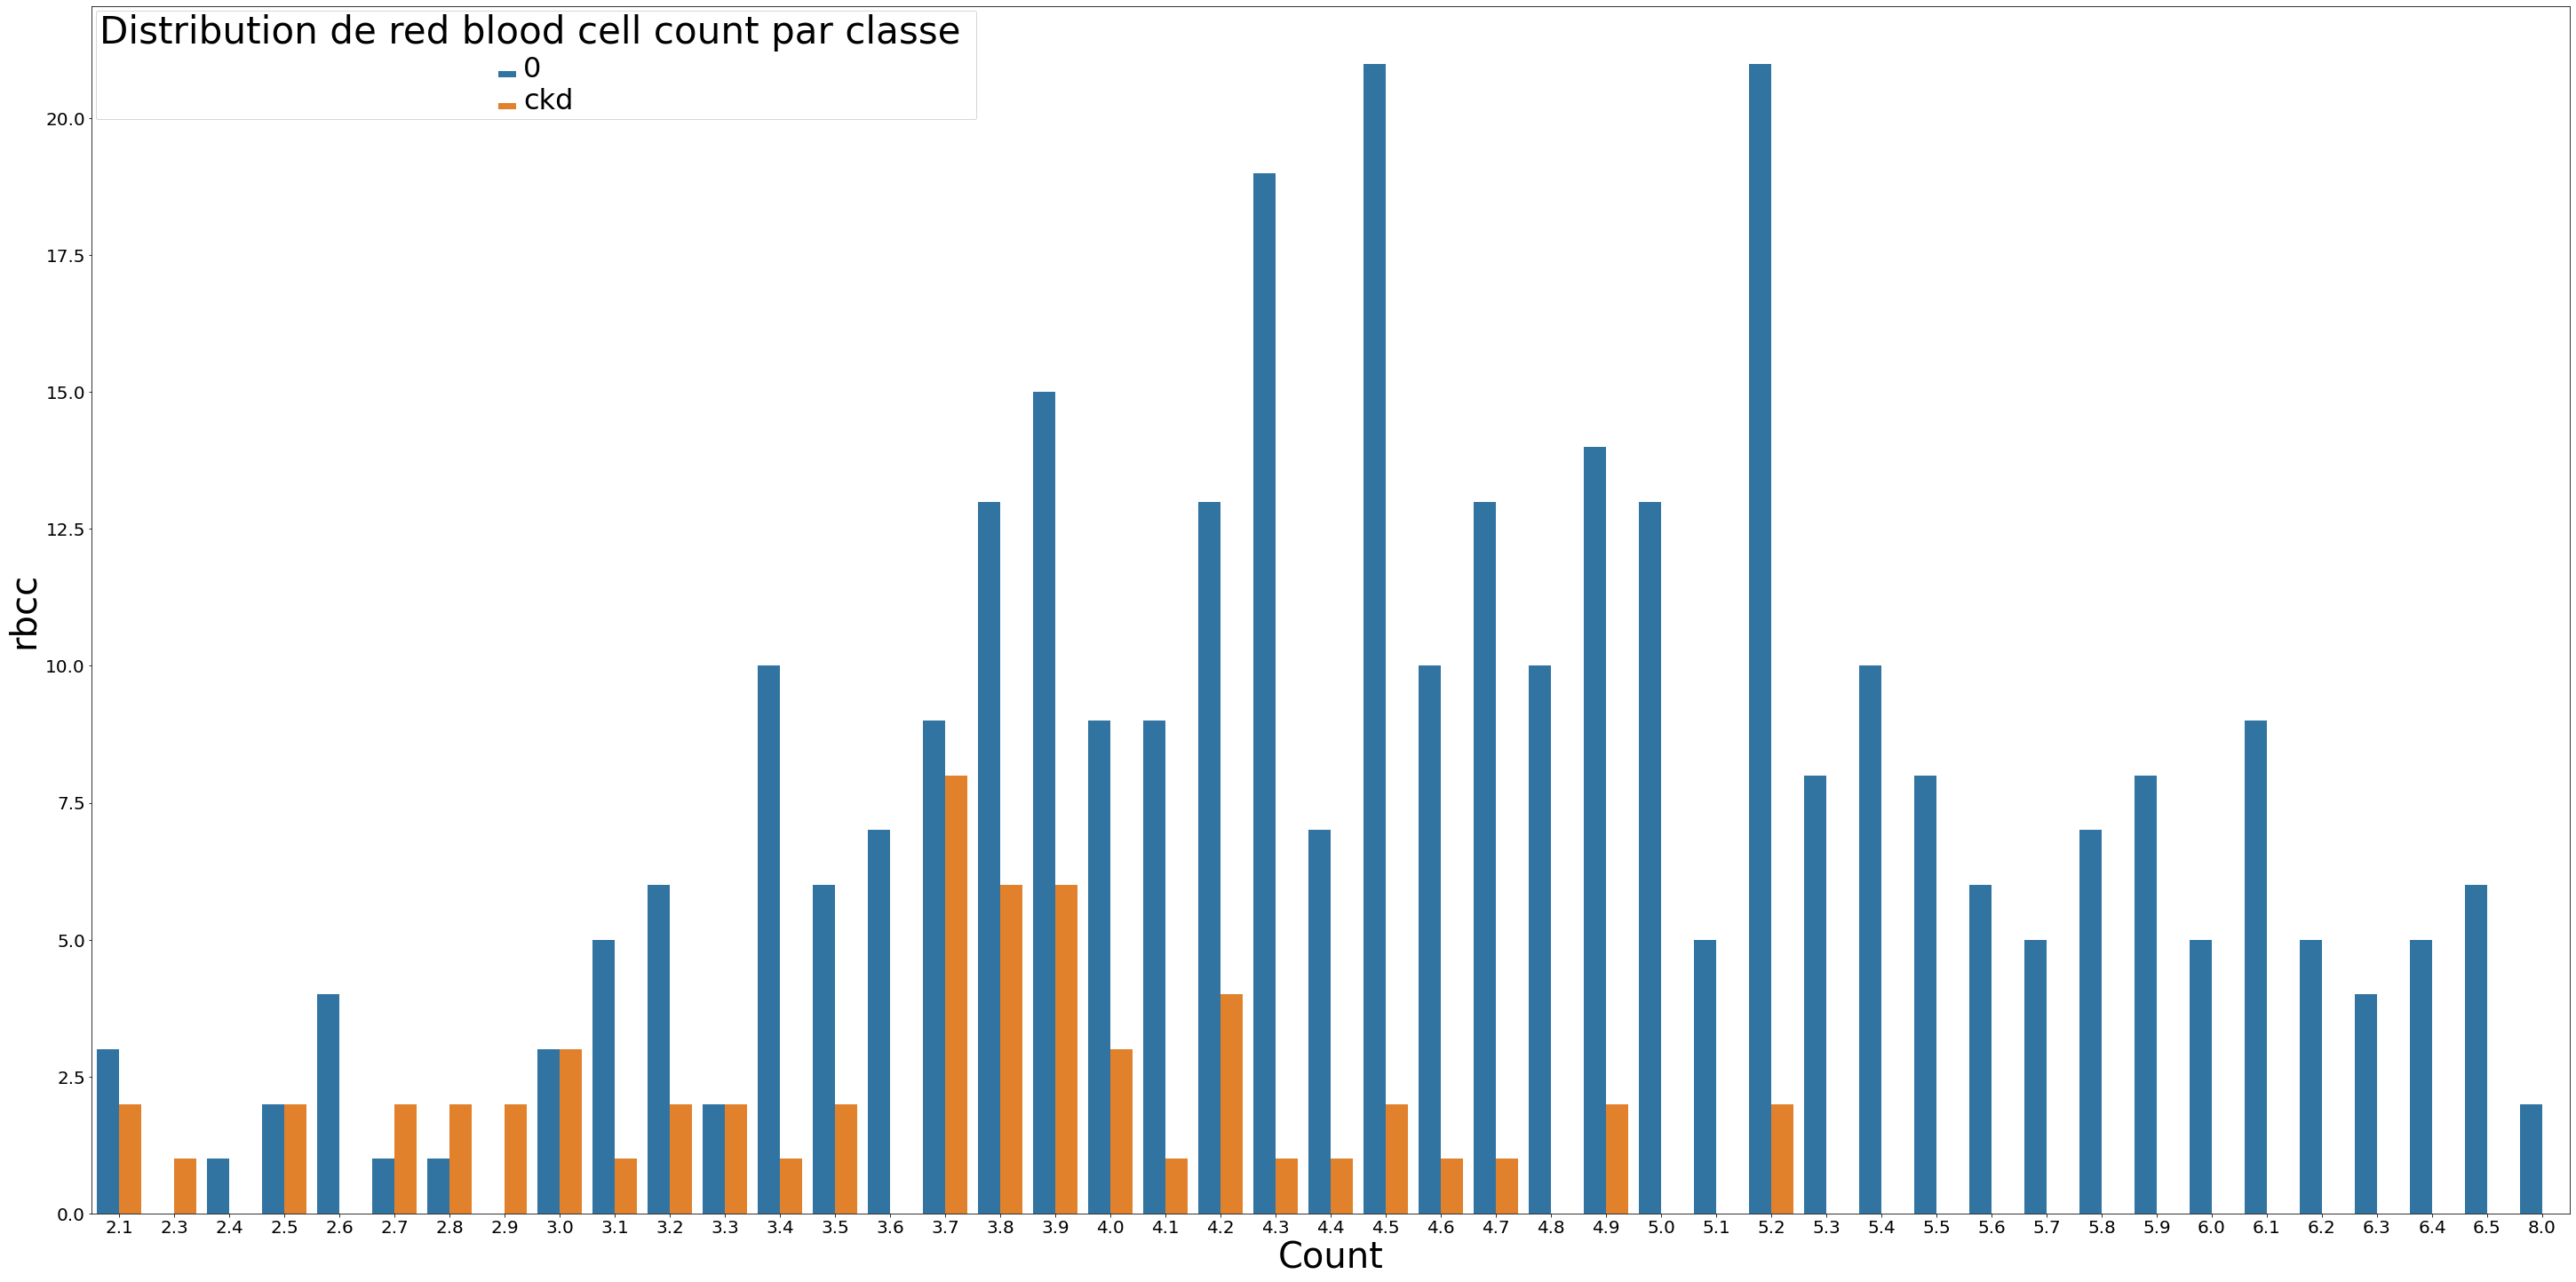

In [244]:
currentVariable='rbcc'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de red blood cell count par classe ",currentVariable)

In [96]:
AnalyseFunctions.CorrelationBetweenVariables(CKD_dataframe,'class',currentVariable)

wbcc     count
wbcc   1.000000 -0.110216
count -0.110216  1.000000

Une corrélation très limité, étonnait du fait que rbc est une variable très corrolée avec la class, j'aurai pensé que le count de cette variable aura une corrélation. Investiguons un peu plus 

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

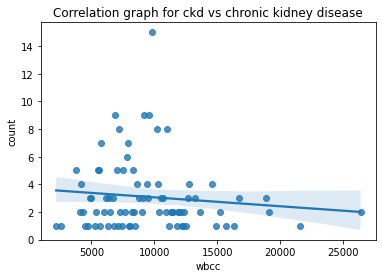

In [97]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'ckd'].groupby([currentVariable]).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = currentVariable, y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Text(0.5, 1.0, 'Correlation graph for ckd vs chronic kidney disease')

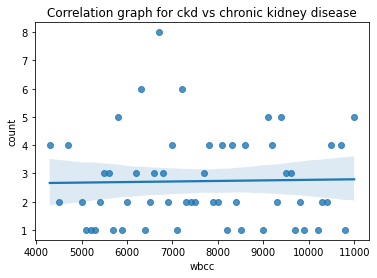

In [98]:
corr_y=CKD_dataframe[CKD_dataframe['class'] == 'notckd'].groupby([currentVariable]).size().reset_index(name = 'count')
sns.regplot(data = corr_y, x = currentVariable, y = 'count').set_title("Correlation graph for ckd vs chronic kidney disease")

Ces deux graphique montre que la corrélation est quasi inexistante du fait que la ligne droite n'a qusiment pas de tangente.

### Relation entre le htn  (hypertension) et le fait d'avoir ou pas une insuffisance rénale (+)

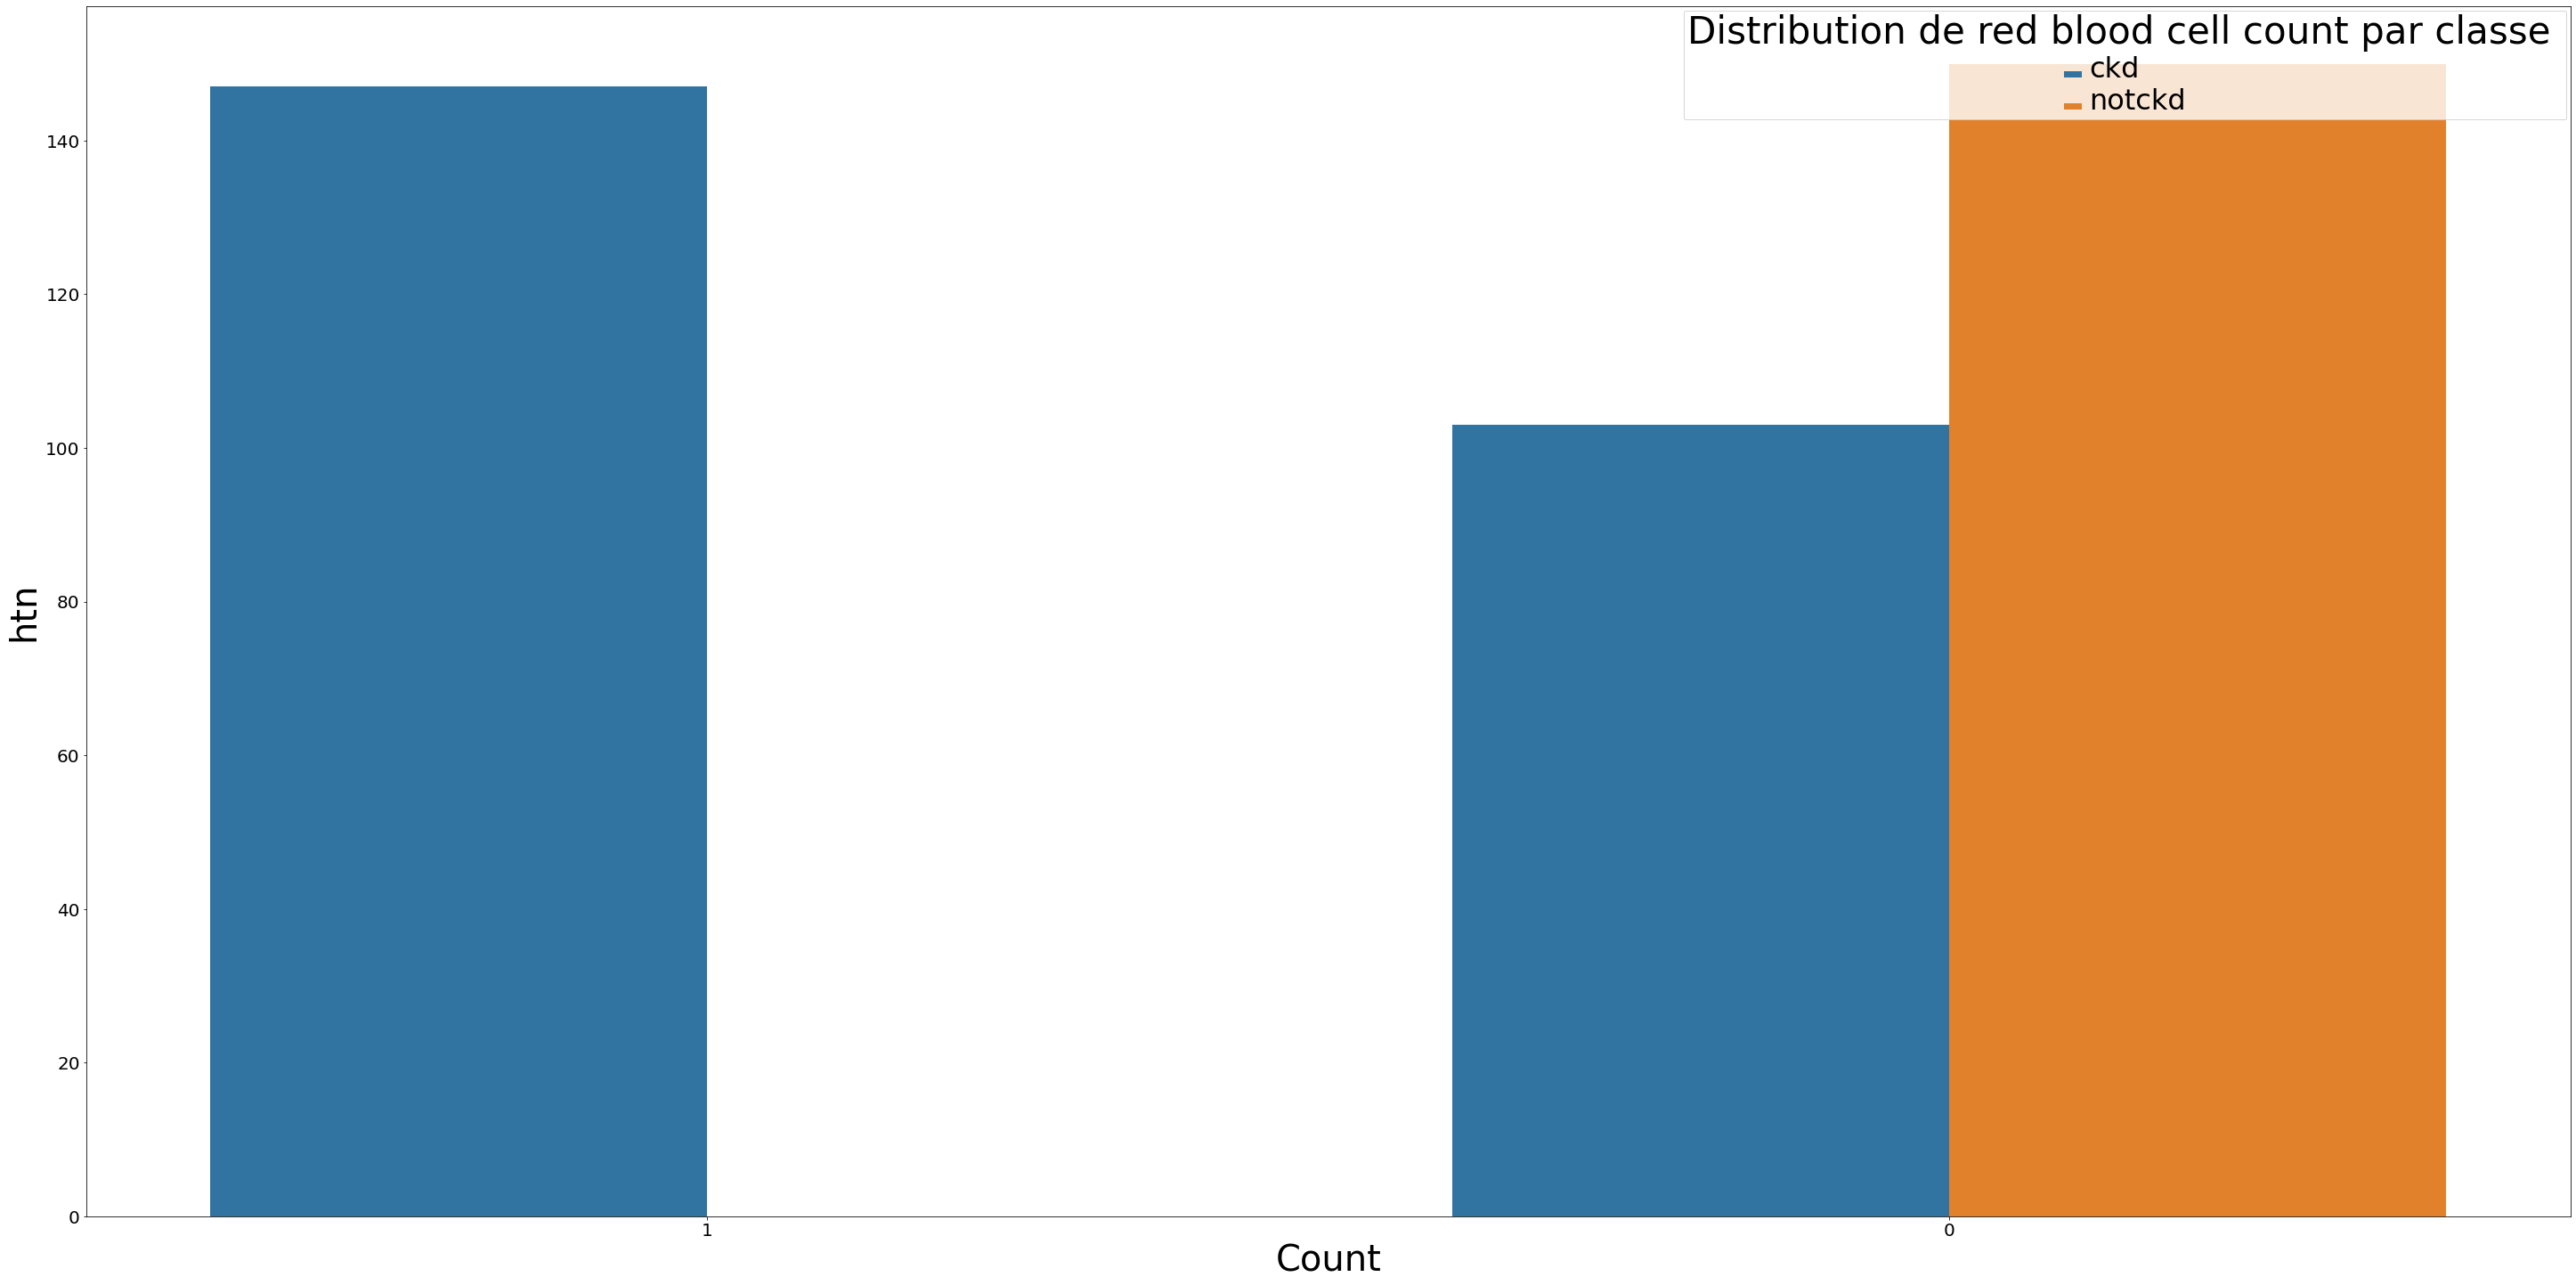

In [99]:
currentVariable='htn'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de red blood cell count par classe ",currentVariable)

Etant une valeur nominal, nous utilisons une approche statistique (p-value)

In [100]:
cont = pd.crosstab(CKD_dataframe["htn"],CKD_dataframe["class"])
scipy.stats.barnard_exact(cont)

BarnardExactResult(statistic=-11.808752699426199, pvalue=5.705070568496231e-33)

Ici, comme c'est une valeur nominale, nous avons utilisé un barnard_exact test pour extraire la p-value. Il existe une relation entre le ckd et l'hypertention.

Nous pouvons pousser nos investigation encre plus loins en montrant le graphique en violon

In [101]:
PlottingFunctions.violin(CKD_dataframe,'htn')


Ceci nous montre clairement qu'il existe une corrélation entre l'hypertention et le fait que les patient soient CKD. Une hypothèse de départ confirmé ! 

### Relation entre le diabetes mellitus (dm) et le fait d'avoir ou pas une insuffisance rénale (+)

Etant une valeur nominale, une approche similaire que lors de la variable précédente

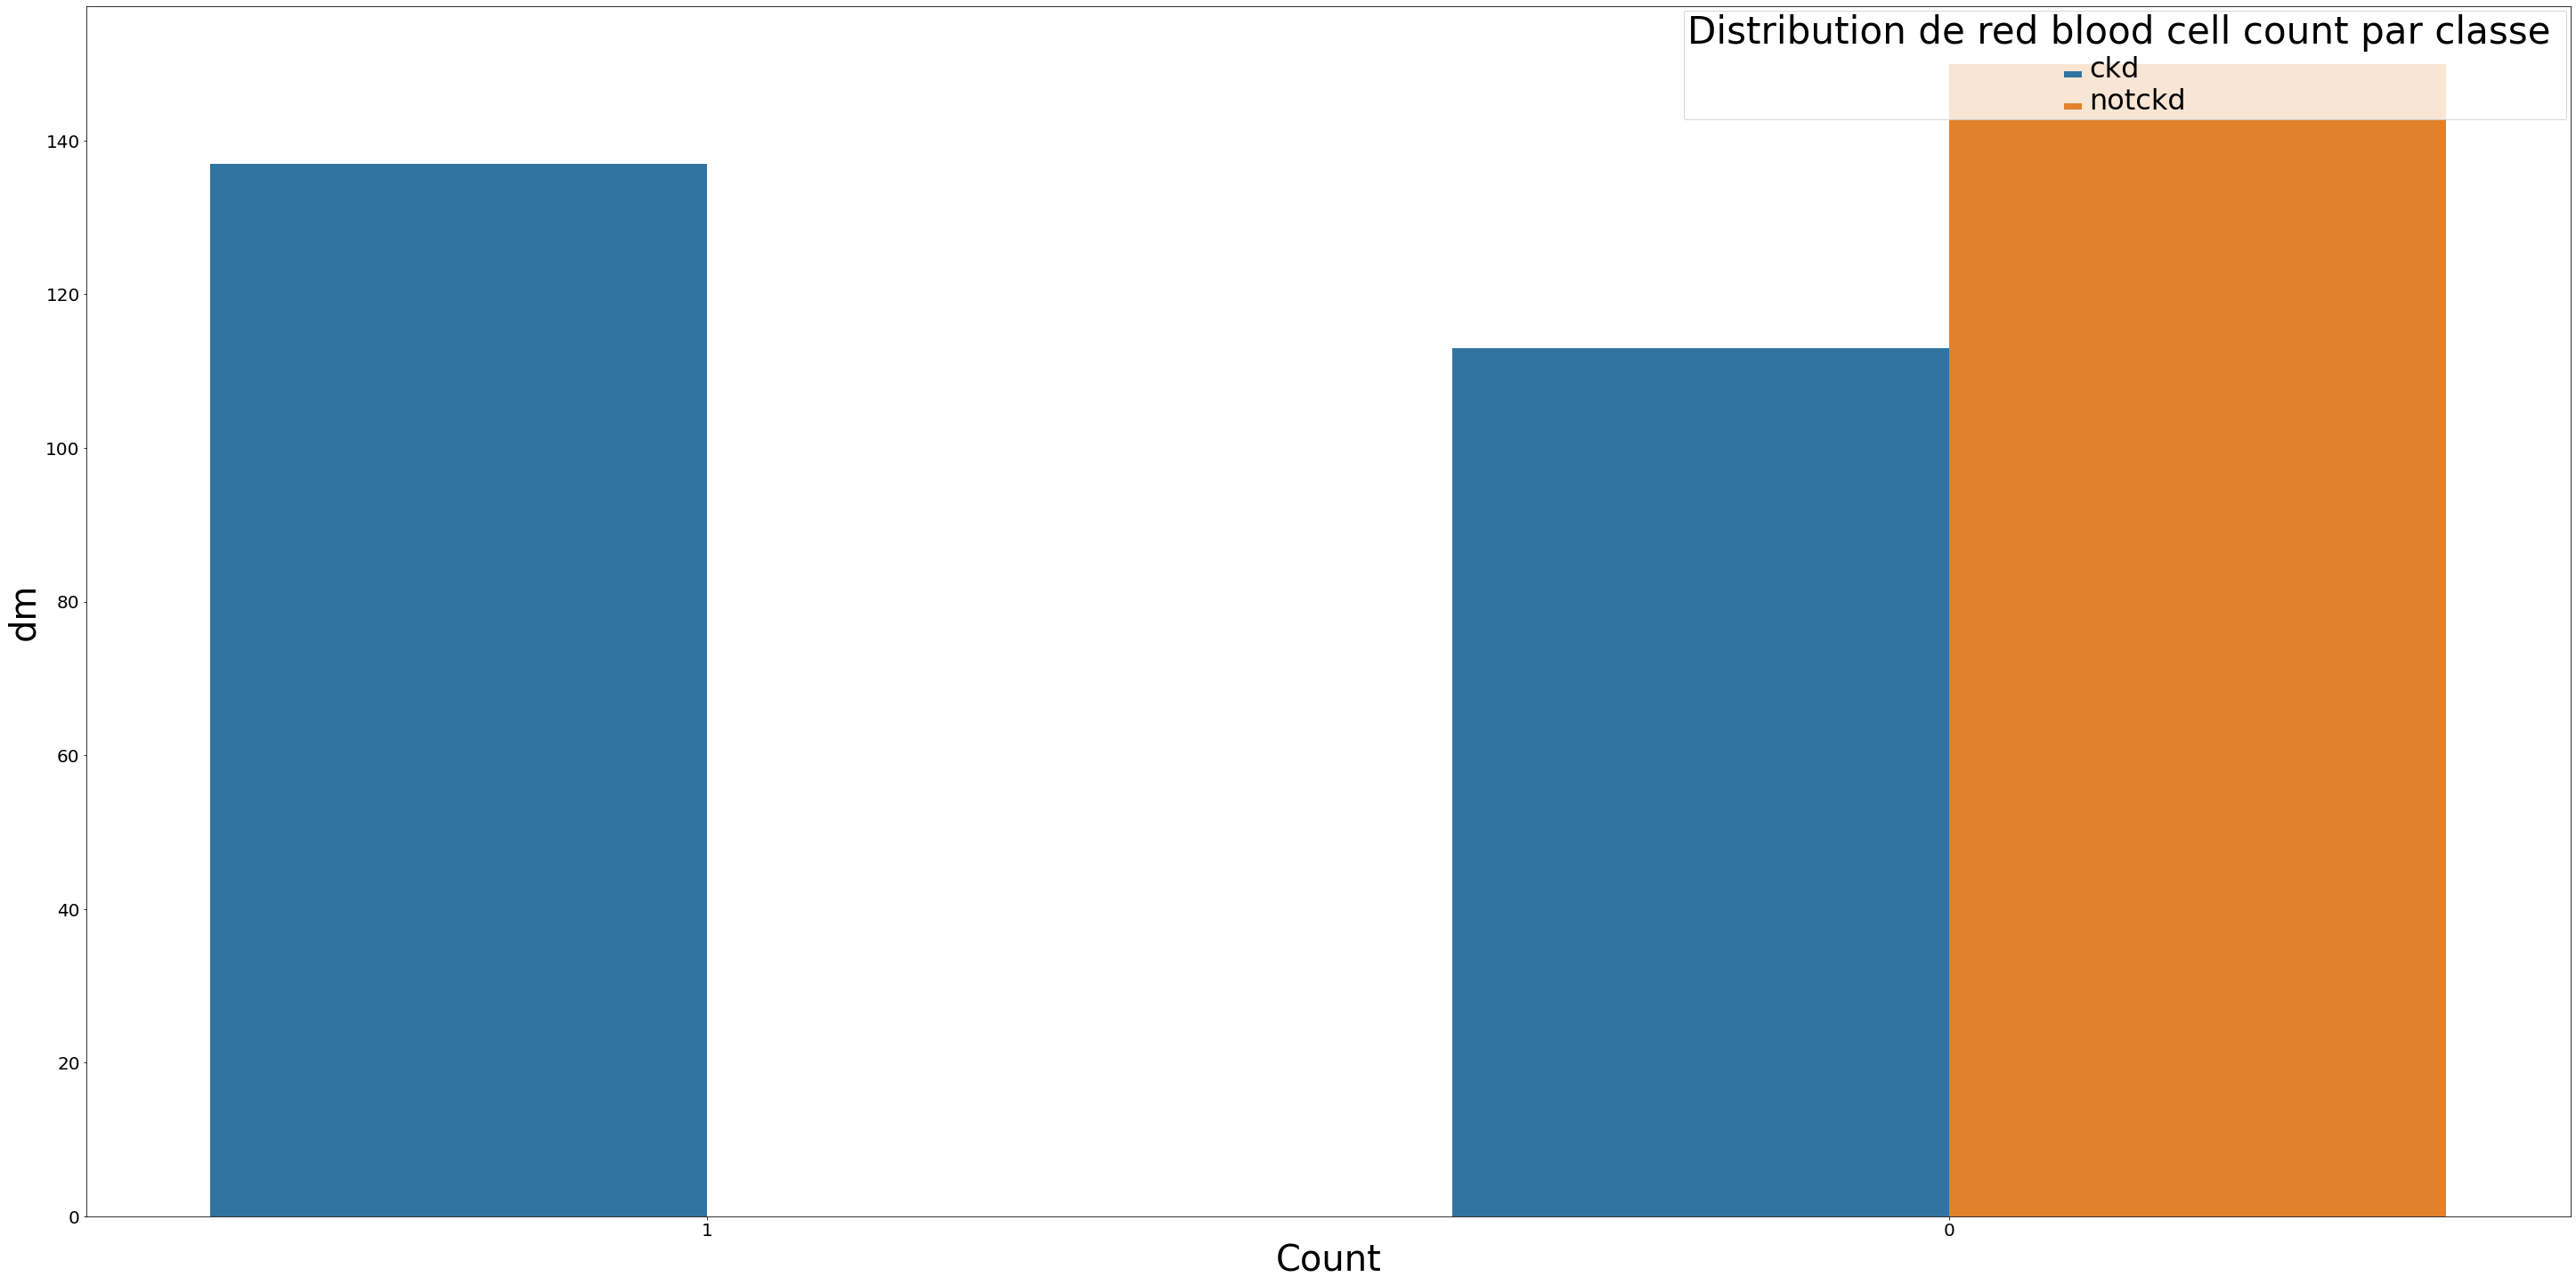

In [102]:
currentVariable='dm'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de red blood cell count par classe ",currentVariable)

In [103]:
cont = pd.crosstab(CKD_dataframe["dm"],CKD_dataframe["class"])
scipy.stats.barnard_exact(cont)

BarnardExactResult(statistic=-11.18119007113483, pvalue=1.023555022813908e-29)

Il est claire d'après le test de barnard et d'après la valeur retournée par la p-value qu'il existe une relation entre la CKD et le fait d'avoir une diabète mellitus.

### Relation entre le coronary artery disease (cad) et le fait d'avoir ou pas une insuffisance rénale (-)

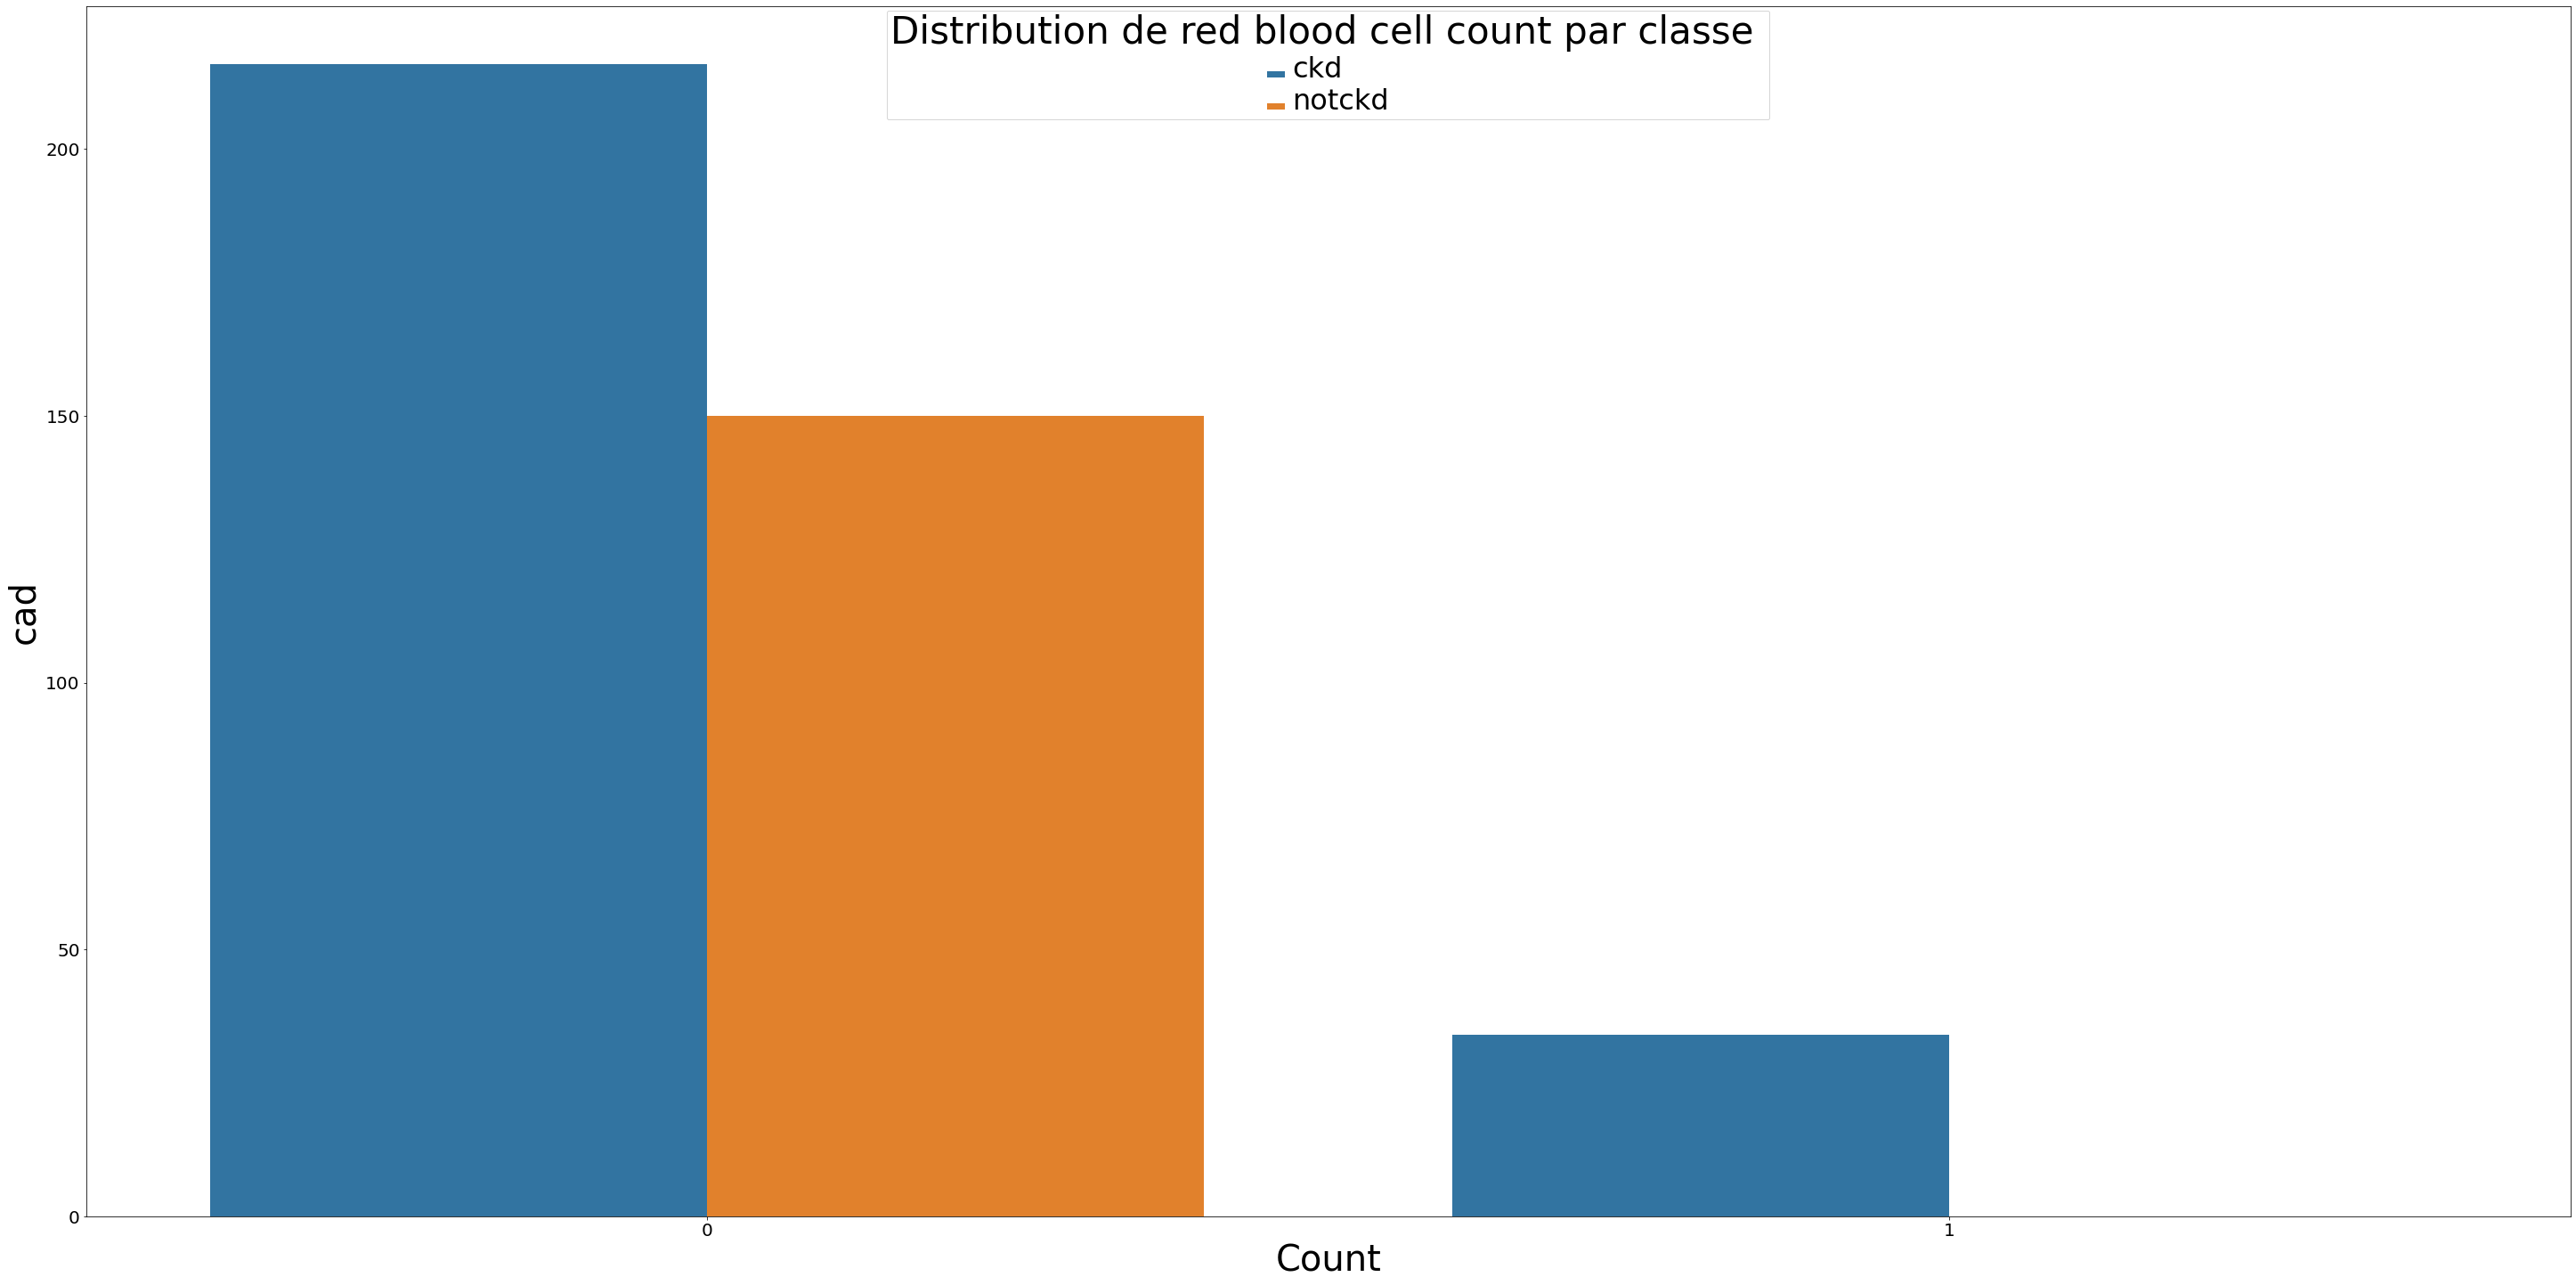

In [106]:
currentVariable='cad'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de red blood cell count par classe ",currentVariable)

In [107]:
cont = pd.crosstab(CKD_dataframe["cad"],CKD_dataframe["class"])
scipy.stats.barnard_exact(cont)

BarnardExactResult(statistic=-4.721766826857625, pvalue=2.2731533942915333e-06)

The p-value est moins que 0.05, de ce fait l'hypothèse de départ est réfutée. Ce qui montre qu'il existe une corrélation entre les patient atteint de CKD et la variable "cad". Toutefois, le fait de ne pas avoir autant de patient non CKD qui l'ont nous met dans une position délicate. Voyons le violin graphe :

In [108]:
PlottingFunctions.violin(CKD_dataframe,'cad')

Très peu, trop peu de patient CKD qui ont le coronary artery desease. Je penche sur le fait que la correlation entre ces deux variable existe, mais faible.

### Relation entre l'appetit et le fait d'avoir ou pas une insuffisance rénale (-)

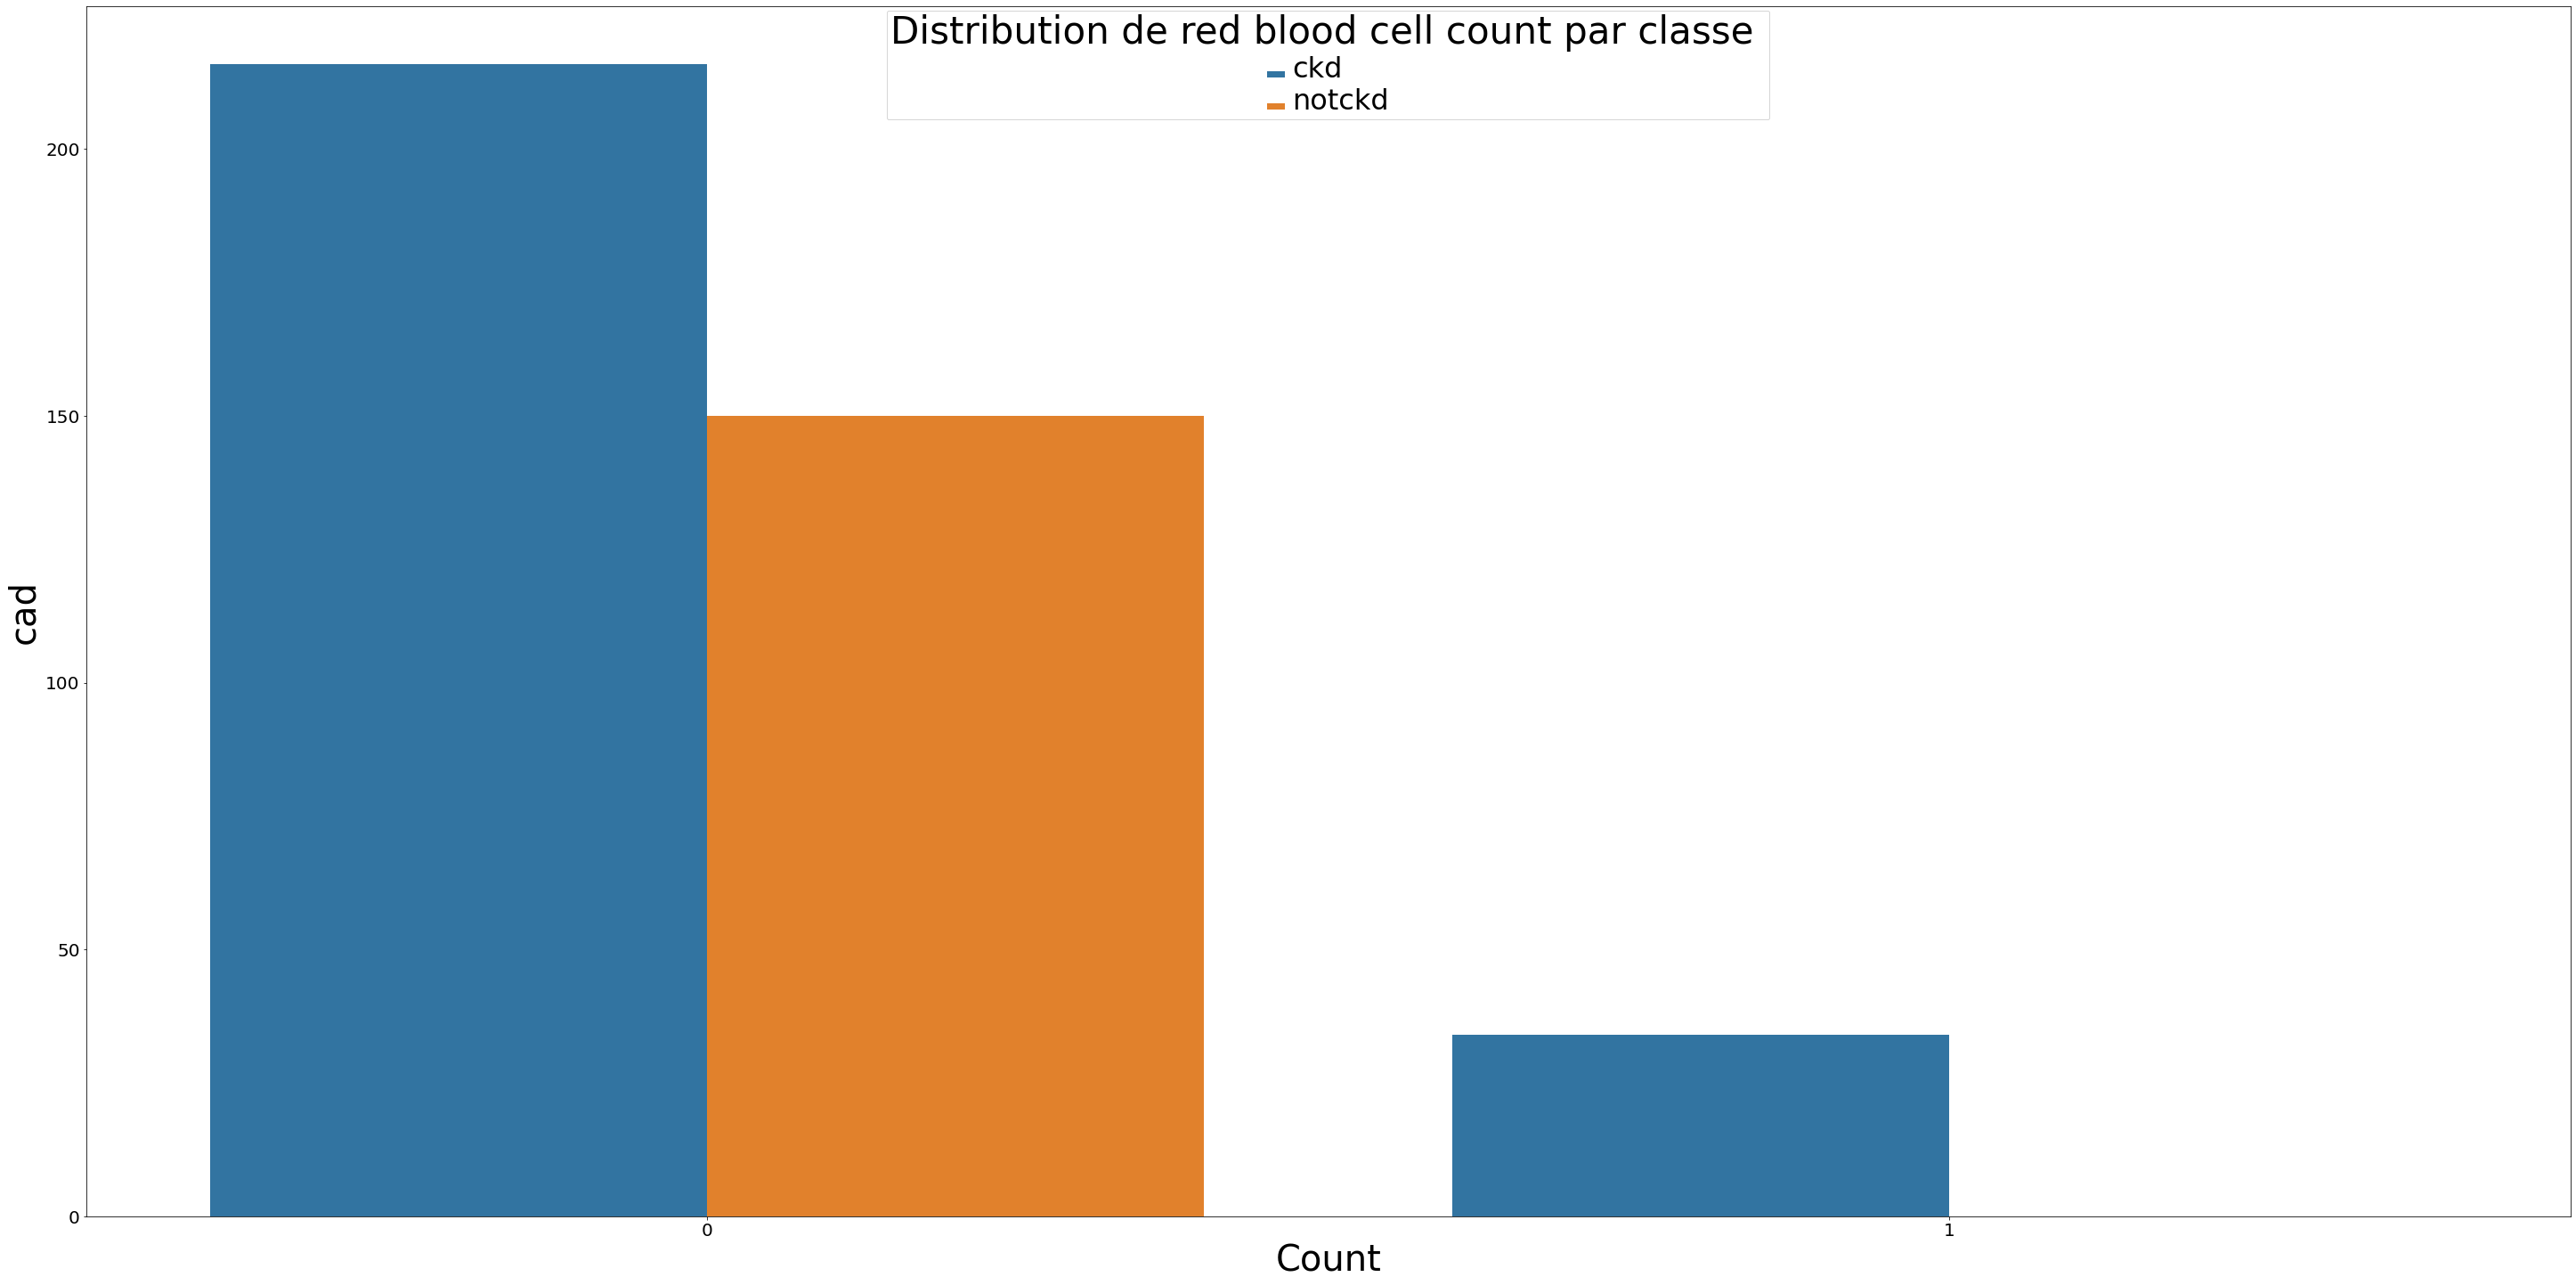

In [109]:
currentVariablecurrentVariable='appet'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de red blood cell count par classe ",currentVariable)

In [110]:
cont = pd.crosstab(CKD_dataframe[currentVariable],CKD_dataframe["class"])
scipy.stats.barnard_exact(cont)

BarnardExactResult(statistic=-4.721766826857625, pvalue=2.2731533942915333e-06)

The p-value est moins que 0.05, de ce fait l'hypothèse qu'il n y a pas de relation entre ces deux variable est réfutée. Nous pouvons avancer dnas un premier temps qu'il existe une relation entre ces deux variables. Toutefois, pour en avoir le coeur net, voyons le graphique en violon. 

In [112]:
PlottingFunctions.violin(CKD_dataframe,'appet')

Il existe quelques patient CKD qui affirme une perte d'appetit, toutefois, la majorité d'entre eux, comme les patient non ckd, n'expriment pas de perte d'appetit. 

Une faible corrélation entre ces deux varibles que je préfère ne pas conter dessus.

### Relation entre pedal edema (pe) et le fait d'avoir ou pas une insuffisance rénale (-)

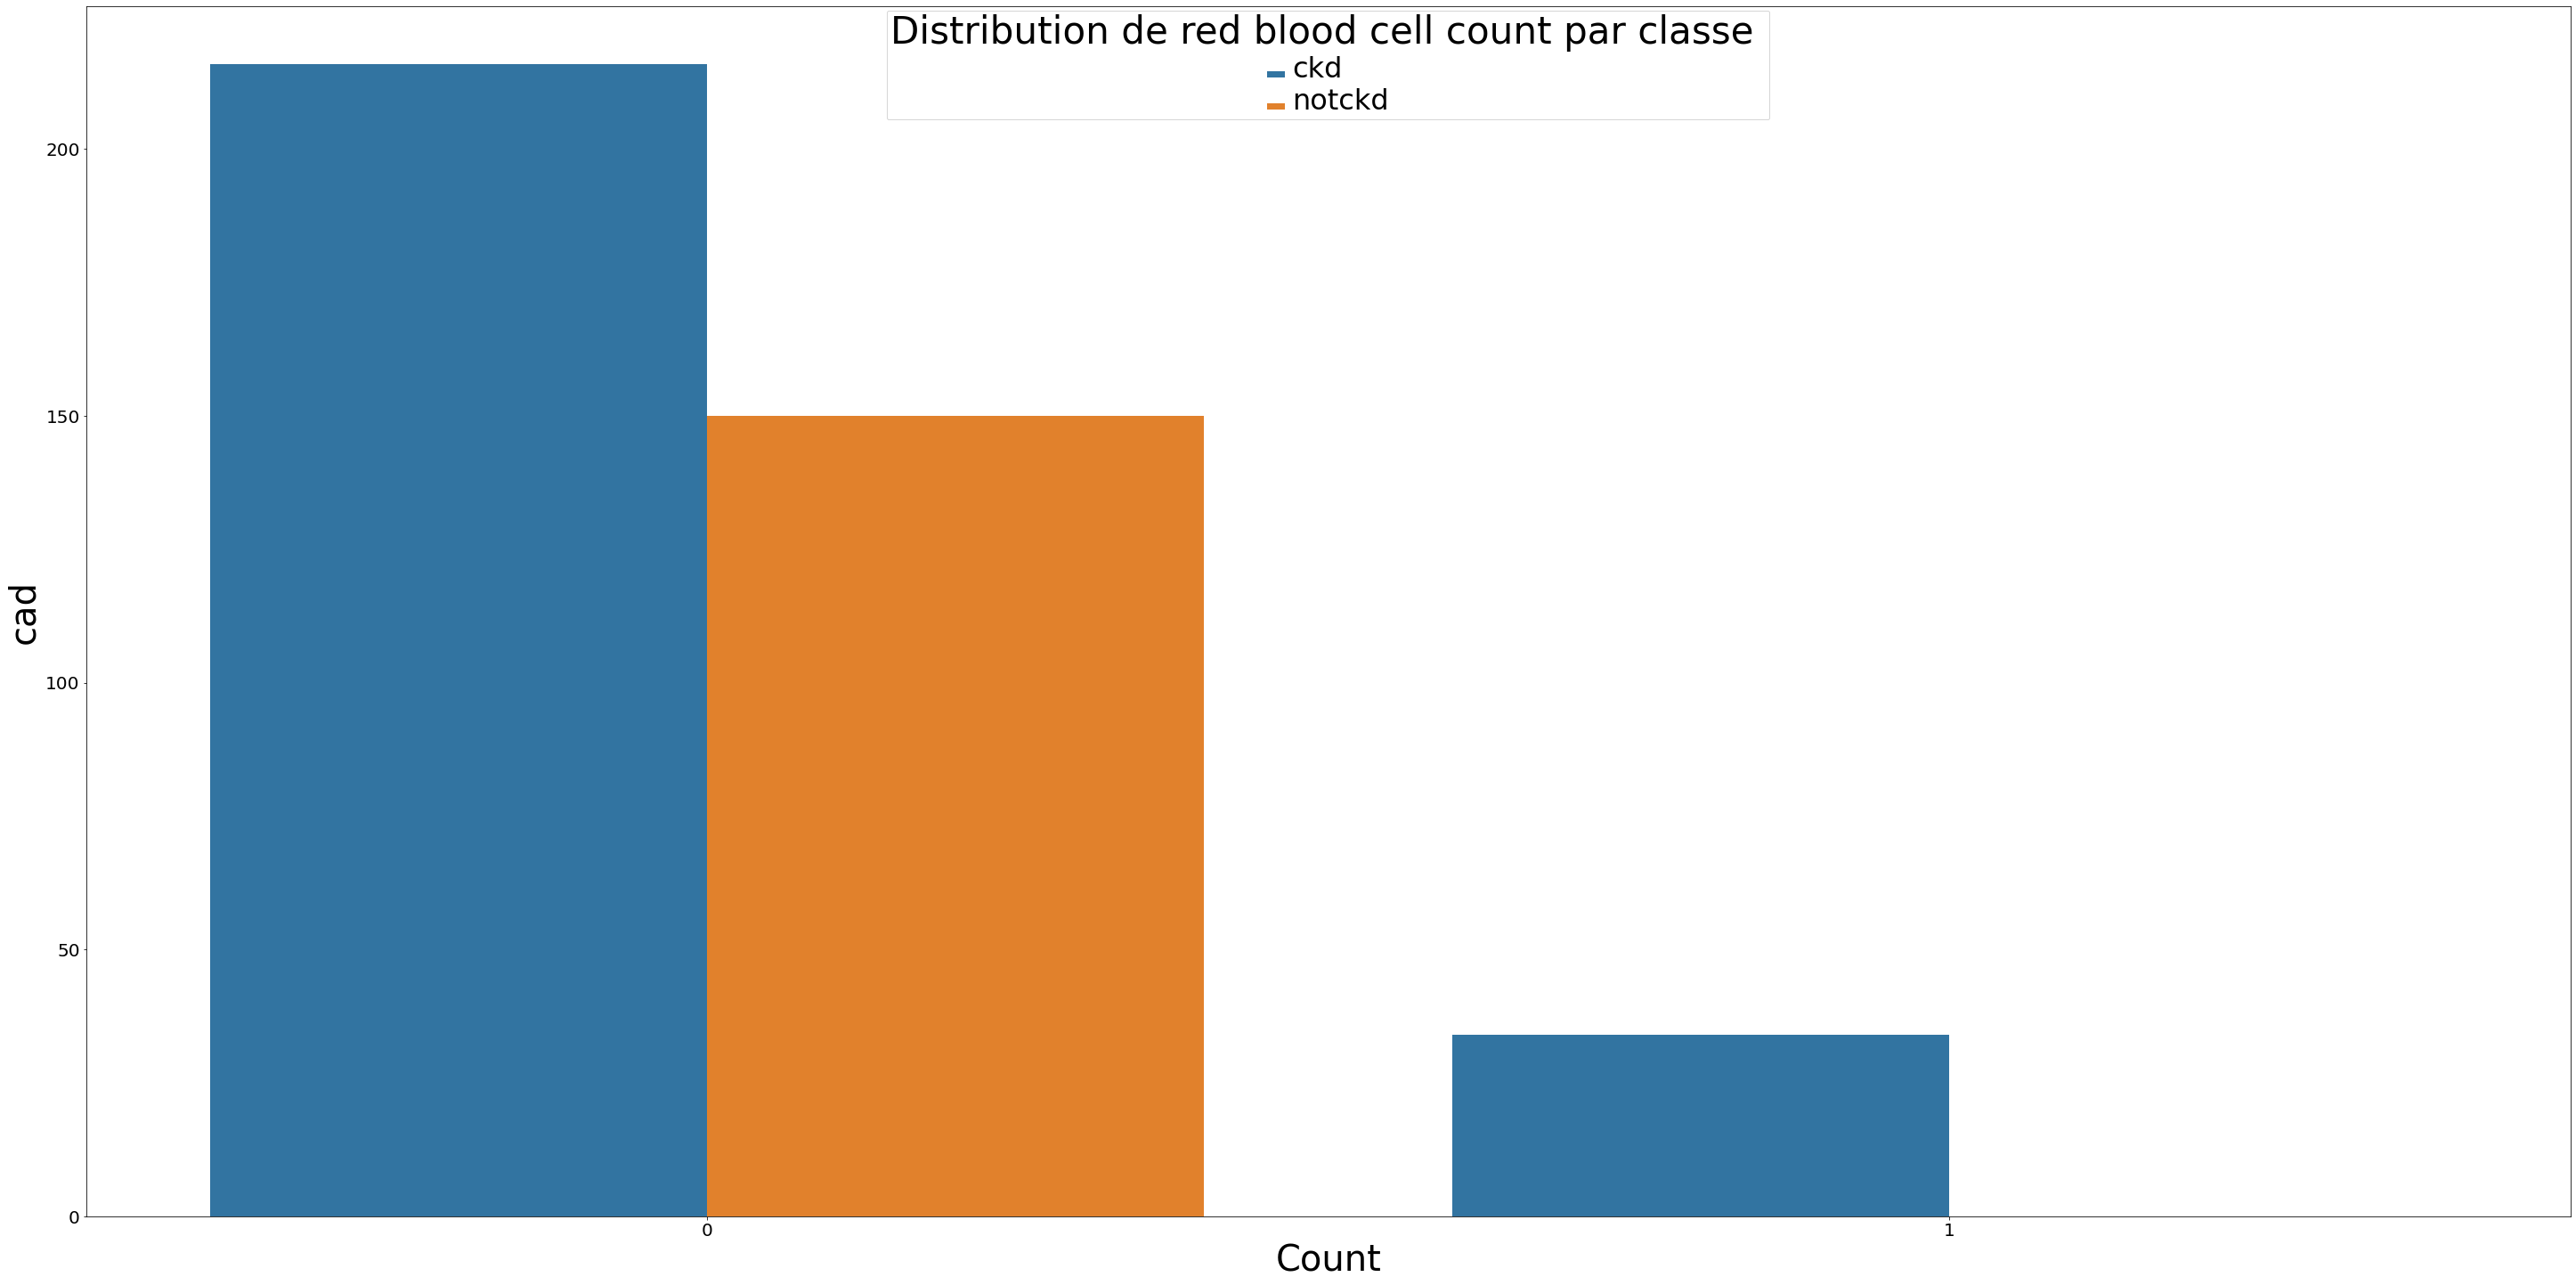

In [113]:
currentVariablecurrentVariable='pe'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de red blood cell count par classe ",currentVariable)

In [114]:
cont = pd.crosstab(CKD_dataframe[currentVariable],CKD_dataframe["class"])
scipy.stats.barnard_exact(cont)

BarnardExactResult(statistic=-4.721766826857625, pvalue=2.2731533942915333e-06)

The p-value est moins que 0.05, de ce fait l'hypothèse de départ est réfutée. Ce qui montre qu'il existe une corrélation entre les patient atteint de CKD et la variable le pedal edema. Toutefois, comme lors de l'analyse de la variable précédente, nous allons afficher le graphique violon.

In [115]:
PlottingFunctions.violin(CKD_dataframe,'pe')

Je préconise une analyse similaire que la variable précédente, la corrélation existe mais très faible pour y compter dessus.

### Relation entre pedal anemia (ane) et le fait d'avoir ou pas une insuffisance rénale (-)





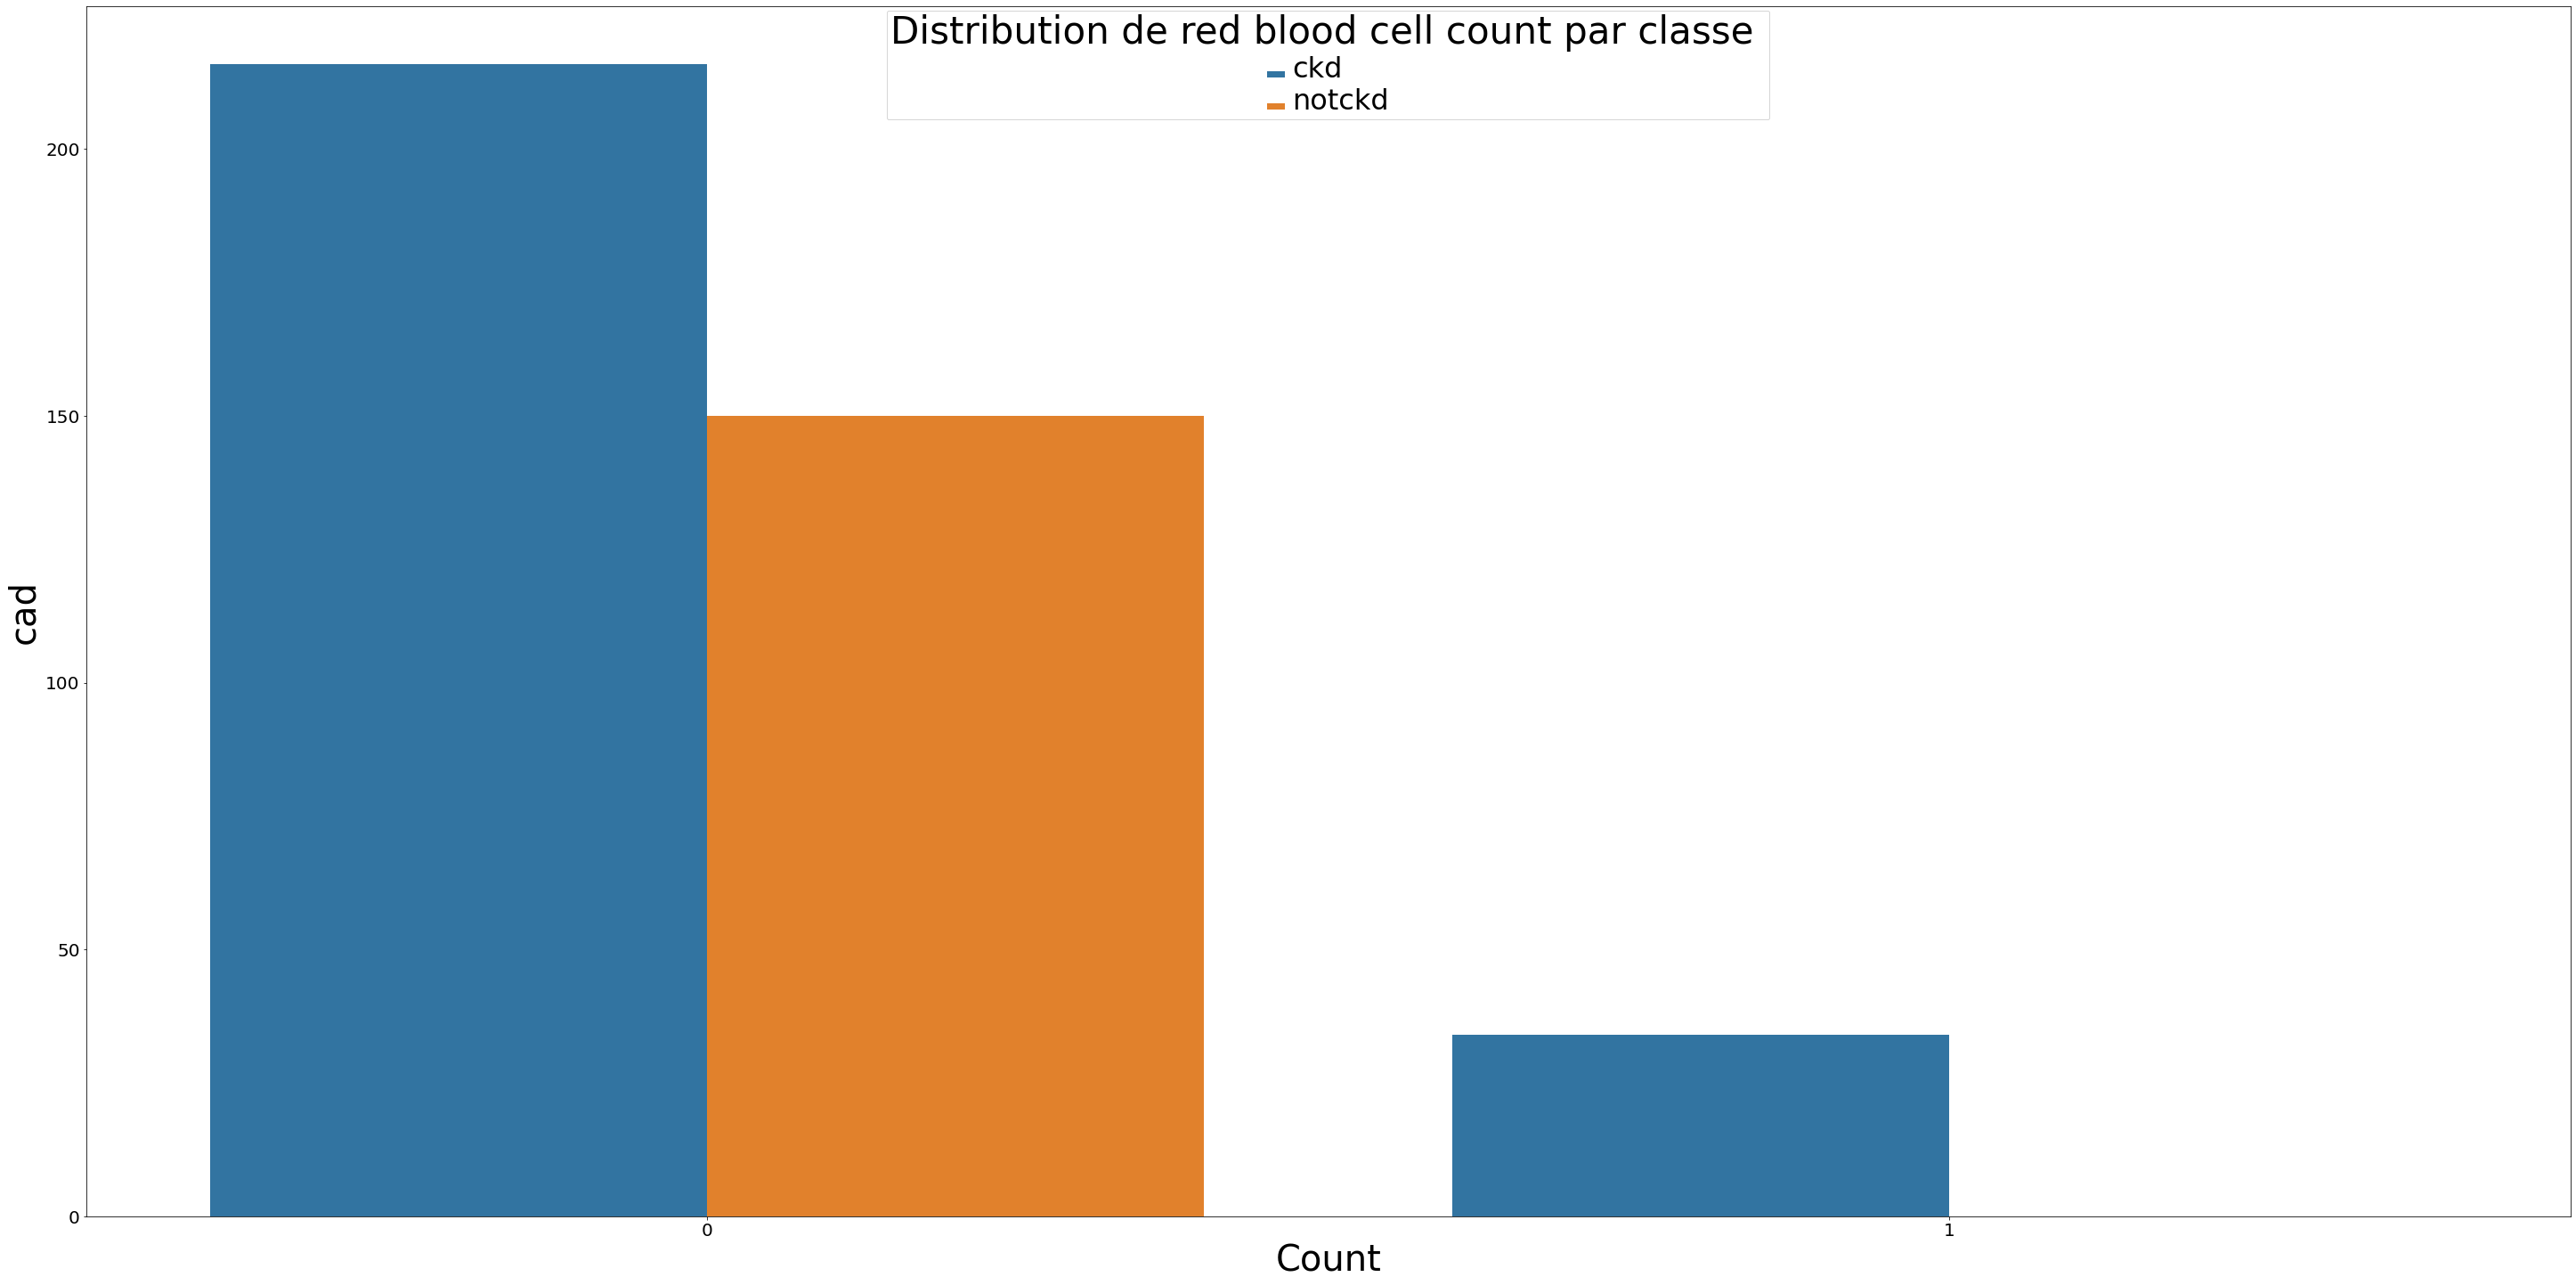

In [116]:
currentVariablecurrentVariable='ane'
PlottingFunctions.PlotDistribution(CKD_dataframe,currentVariable,"Distribution de red blood cell count par classe ",currentVariable)

In [117]:
cont = pd.crosstab(CKD_dataframe[currentVariable],CKD_dataframe["class"])
scipy.stats.barnard_exact(cont)

BarnardExactResult(statistic=-4.721766826857625, pvalue=2.2731533942915333e-06)

The p-value est moins que 0.05, de ce fait l'hypothèse de départ est réfutée. Ce qui montre qu'il existe une corrélation entre les patient atteint de CKD et la variable anémie. Toutefois, trop peut de valeur pour les patient qui ont la CKD et qui souffre de pedal anémia pour tirer une conclusion dont on peut compter dessus.

### Conclusion de cette sous section

après avoir effectuer ces corrélation, nous pouvons avancer que les attributs suivant dispose d'une corrélation avec le fait d'avoir une insufisance rénale


1. L'albumine
2. Le sucre
3. red blood cells ( cellules sanguines rouges )
4. pus cells
5. pus cell clumps
6. Hemoglobin
7. Packec cell volume (PCV)
8. l'hypertention
9. Le diabète



# Dernière approche logistic regression

Construction du model : 

In [118]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

X = CKD_dataframe.iloc[:,:-1]
y = CKD_dataframe['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, shuffle = True)

logreg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

Vérification des résultats obtenu par le training : 

In [119]:
print(logreg.score(X_train,y_train))
print(logreg.score(X_test,y_test))

0.9333333333333333
0.96


Extraction des coéefficients :

In [120]:
Coefs=pd.DataFrame(logreg.coef_, columns=X.columns)

Analyser les coefficients:

la lecture des coefficient se fait de la sorte :
Si l'attribut devait augmenter de 1 unité, la probabilité d'impacter la classe serai de exponnentiel au coef (e^coef)

Dans le cas de l'age par exemple 

In [121]:
Coefs['age']

0    0.014525
Name: age, dtype: float64

In [122]:
math.exp(Coefs['age'])

1.0146314157226706

Lorsque l'age augmente d'une valeur, la probabilité d'impacter la classe finale est de 1%

Nous allons maintenant classer les coefficients

In [123]:
Coefs=Coefs.apply(math.exp)

Le top 6 de cette dernière approche est : 

In [125]:
Coefs.transpose().sort_values(0,ascending=False)[0:6]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of Series.sort_values will be keyword-only



pcv      1.522517
hemo     1.231738
rbcc     1.098372
rbc      1.023511
appet    1.019765
pc       1.017350
dtype: float64

Ceci nous retourne le classement des facteurs risque du CKD

#relations entre les Facteurs risques pour extraire les types de CKD 

afin de pouvoir vérifier cela, vérifions la corrélation entre les variables du dataframe en générant la matrice de corrélation comme suit : 

Regardons maintenant la matrice de correlation de ces variables uniquement

In [126]:
CKD_dataframe.head()

age    bp     sg   al   su rbc pc pcc ba    bgr  ...   pcv    wbcc  rbcc  \
0  48.0  80.0  1.020  1.0  0.0   0  1   0  0  121.0  ...  44.0  7800.0   5.2   
1   7.0  50.0  1.020  4.0  0.0   0  1   0  0  273.0  ...  38.0  6000.0   4.1   
2  62.0  80.0  1.010  2.0  3.0   1  1   0  0  423.0  ...  31.0  7500.0   3.9   
3  48.0  70.0  1.005  4.0  0.0   1  0   1  0  117.0  ...  32.0  6700.0   3.9   
4  51.0  80.0  1.010  2.0  0.0   1  1   0  0  106.0  ...  35.0  7300.0   4.6   

   htn  dm  cad  appet  pe ane class  
0    1   1    0      1   0   0   ckd  
1    0   0    0      1   0   0   ckd  
2    0   1    0      0   0   1   ckd  
3    1   0    0      0   1   1   ckd  
4    0   0    0      1   0   0   ckd  

[5 rows x 25 columns]

In [127]:
corr = CKD_dataframe.corr()
corr.style.background_gradient(cmap='RdBu_r')

Après avoir analyser la matrice de coefficients, et en ne prendant en considération que les variables qui sont des facteurs risques du CKB. Il est claire que les variables suivantes sont corrélées: 


Groupe 1 : 
- specific gravity
- hemoglobin 
- Packed Cell Volume 
- red blood cell

Groupe 2 : 
- albumin
- Serum  Creatinine


Groupe 3 : 
- Sucre
- Blood clucose Random 

Mettant ansi en valeur le fait que le CKD peut provenir d'une de ces trois sources. 

# Conclusion

Après avoir effectuer plusieurs approches de vérification de corrélation entre les différentes variables pouvant amener a un patient d'avoir une isufisance rénale chronique, nous concluons avec les valeurs suivantes : 

Les variables qui on une corrélation positive sur le fait que les patient soit CKD sont :
- L'hémoglobin
- L'albumine
- red blood cell 

les variable qui ont une corrélation négative parcontre sont : 
- packed_cell_volume
- serum_creatinine
- specific gravity


En ce qui concerne la relation entre les variables, nous avons extrait, grace a la matrice de corrélation entre toutes les variables, les relations suivantes : 

Groupe 1 : 
- specific gravity
- hemoglobin 
- Packed Cell Volume 
- red blood cell

Groupe 2 : 
- albumin
- Serum  Creatinine


Groupe 3 : 
- Sucre
- Blood clucose Random 

The End